# IMPORT

In this notebook I did not normalized images before evolving, just when predicting

In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
import pickle
import time
from skimage.measure import compare_ssim
import tensorflow as tf
from keras.models import Model,load_model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.utils import to_categorical
import keras
import random

Using TensorFlow backend.


In [2]:
#Set seeds
random.seed(1)
np.random.seed(1)

# GLOBAL VARS

In [3]:
INDIVIDUALS = 50
P_CROSS = 0.6
P_MUTATION = 0.01
CIFAR_IMG= 32

# THE DATA

In [4]:
from keras.datasets import cifar10

# The data, split between train and test sets:
(x_train_C, y_train_C), (x_test_C, y_test_C) = cifar10.load_data()
print('x_train shape:', x_train_C.shape)
print(x_train_C.shape[0], 'train samples')
print(x_test_C.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
num_classes=10
epochs=10
img_shape=32 
y_train_C = to_categorical(y_train_C, num_classes)
y_test_C = to_categorical(y_test_C, num_classes)


input_shape=(32,32,1)

x_train_C = x_train_C.astype('float32')
x_test_C = x_test_C.astype('float32')
x_train_C /= 255
x_test_C /= 255


print('x_train shape:', x_train_C.shape)
print('Number of images in x_train', x_train_C.shape[0])
print('Number of images in x_test', x_test_C.shape[0])
print('y_train shape:', y_train_C.shape)
print("input shape: ",input_shape)


# CONVERT TO GRAY SCALE

import matplotlib.pyplot as plt
import numpy as np

def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

x_train_C = grayscale(x_train_C)
x_test_C = grayscale(x_test_C)

# now we have only one channel in the images
img_channels = 1



x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
Number of images in x_train 50000
Number of images in x_test 10000
y_train shape: (50000, 10)
input shape:  (32, 32, 1)


# READ PICKLE FILES

In [5]:
with open('../../Subsets/subset_cifar', 'rb') as f:
    original = pickle.load(f)
    adversarial= pickle.load(f)
    original_y = pickle.load(f)
    adversarial_y = pickle.load(f)

In [6]:
print(f"Original shape {original.shape}")
print(f"Adversarial shape {adversarial.shape}")
print(f"Original labels shape {original_y.shape}")
print(f"Adversarial labels shape {adversarial_y.shape}")

Original shape (914, 32, 32, 1)
Adversarial shape (133, 32, 32, 1)
Original labels shape (914, 1)
Adversarial labels shape (133, 1)


# LOAD THE MODEL

3. CNN v2

This network is made for CIFAR 10. The network is taken from [this blog]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) . In this version below I didn't use some things used in the blog e.g. z-score and data augmentation.


This network has training accuracy: 0.8940 , validation accuracy: 0.8245.

**NOTE:** Training really slow, try to avoid it.

In [7]:
# Network 3 
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np

input_shape = (CIFAR_IMG,CIFAR_IMG,1)
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
 
model.summary()


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


'''
history = model.fit(x=x_train_C,y=y_train_C, epochs=150, batch_size=64, validation_data=[x_test_C,y_test_C])

score= model.evaluate(x_test_C, y_test_C,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save_weights("CNN_CIFAR10_net3.h5")
files.download('CNN_CIFAR10_net3.h5')
'''

                                                                                               

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

# GENETIC ALGORITHM FUNCTIONS

In [8]:

def computing_SSIM(individual,target):
    return compare_ssim(individual.reshape(CIFAR_IMG,CIFAR_IMG), target.reshape(CIFAR_IMG,CIFAR_IMG))

def calculate_fitness(model,ind,target_image,label,l1=0.2, l2=0.8, N=50, num_classes=10):
  # predict the population
  predictions=model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1) / 255.0)  
  # po is the ground truth prediction, so for label = 0, it will be prediciton[0]
  predictions=predictions[0]
  po=predictions[label]
  # set that value to 0
  predictions[label]=0
  # take next highest one
  pd = np.max(predictions)
  diff=pd-po
  return l1*computing_SSIM(ind.reshape(CIFAR_IMG,CIFAR_IMG),target_image.reshape(CIFAR_IMG,CIFAR_IMG)) +l2*(diff)
  


def pop_fitness(model,pop,target,label):
    return [calculate_fitness(model, p, target, label) for p in pop]

def flatten(imgs):
    # flatten all images in np array or list
    return np.array([im.flatten() for im in imgs])

def gaussian_noise():
    # draw one sample of noise from zero mean 1 variance Gaussian
    return np.random.normal(0, 10)

def p_noise(x):
  if 0.01 > np.random.uniform():
    return x + gaussian_noise()
  else:
    return x
    
def add_noise(image):
    noise_v=np.vectorize(p_noise)
    return noise_v(image) #np.array([x + gaussian_noise() if P_MUTATION > np.random.uniform(0.0, 1.0) else x+0 for x in image])

def k_crossover(im1, im2, k=1):
    c1, c2 = [], []
    # get k crossover points
    points = sorted([np.random.randint(0, CIFAR_IMG*CIFAR_IMG-1, 1) for p in range(k)])
    points = sorted([np.random.randint(0,CIFAR_IMG*CIFAR_IMG-1,1) for p in range(k)])
    im_1_split = np.split(im1, [int(p) for p in points])
    im_2_split = np.split(im2, [int(p) for p in points])
    
    # alternate between lists to realise crossover (theres got to be a more clever way to do this)
    for i in range(k+1):
        if i % 2 == 0:
            c1.append(im_1_split[i])
            c2.append(im_2_split[i])
        else:
            c1.append(im_2_split[i])
            c2.append(im_1_split[i])
    return np.concatenate(c1, axis=0), np.concatenate(c2, axis=0)

def tournament(pop, model, ground_truth, target, k=3):

    indices = np.random.choice(range(len(pop)), k, replace=False) #we get 3 indxes [2 34 46]    
    individuals = pop.take(indices,axis=0)
    scores = pop_fitness(model,np.expand_dims(individuals.reshape(individuals.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3), ground_truth.reshape(CIFAR_IMG,CIFAR_IMG), target)
    index_max = np.argmax(scores)
    winner = individuals[index_max]
    return winner


def check_adv_termination(ind, label,ground_truth, model):
  # individual - the best one from the generation
  # label - class we want
  # ground_truth - the image (32,32)
  # model we are using 
  dist = 1-compare_ssim(ind.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG))
  predictions= model.predict(ind.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0)
  predicted_label= np.argmax(predictions[0])
  if label != predicted_label and dist < 0.001:
    print("FOUND ADVERSARIAL")
    print(f"Fitness of the adversarial {calculate_fitness(model,ind,ground_truth,label)}")
    return ind
  return []

def init_pop_from_sample(n,img,label):
    x = np.array([add_noise(img) for i in range(n)])
    return x.reshape(n, CIFAR_IMG*CIFAR_IMG)



Functions from the past, just didn't want to erase them yet

In [9]:
'''
def check_adverserial(pop, model, fitness, target,ground_truth):
    #print(f"this is adversarial function")
    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))
    #print(f"These are predictions made here {preds}")
    for ind, pr in zip(pop,preds): 
      #print(f"prediction for an individual {pr}")
      preds=np.argmax(pr)
      #print(f"getting the index of highest value in predictions {preds}")
      #setting the value to 0
      pr[0]=0
      #print(f"this is our target {target}")
      #print(f"this is out ground_truth {ground_truth.shape}")
      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))
      #print(f"these are the fitness values {fitness}")
      next_highest = np.argmax(pr)
      #print(f"getting the next highest value {next_highest}")
      if next_highest != target and fitness > 0.98:
          return ind, True
      return None, False

def init_pop(n, num, data, labels):
    indices = np.where(labels==num)[0]
    n_indices = np.random.choice(indices, n, replace=True)
    sample = np.take(data, n_indices, axis=0)
    return sample, np.full((n), num, dtype=int) # return sample+array of labels


Cyrils model

def save_trained_model(model, filename='SVC_model.sav'):
    pickle.dump(model, open(filename, 'wb'))
    
def load_trained_model(filename='SVC_model.sav'):
    return pickle.load(open(filename, 'rb'))

'''

'\ndef check_adverserial(pop, model, fitness, target,ground_truth):\n    #print(f"this is adversarial function")\n    preds=model.predict(pop.reshape(pop.shape[0],28,28,1))\n    #print(f"These are predictions made here {preds}")\n    for ind, pr in zip(pop,preds): \n      #print(f"prediction for an individual {pr}")\n      preds=np.argmax(pr)\n      #print(f"getting the index of highest value in predictions {preds}")\n      #setting the value to 0\n      pr[0]=0\n      #print(f"this is our target {target}")\n      #print(f"this is out ground_truth {ground_truth.shape}")\n      fitness=computing_SSIM(ind.reshape(28,28),ground_truth.reshape(28,28))\n      #print(f"these are the fitness values {fitness}")\n      next_highest = np.argmax(pr)\n      #print(f"getting the next highest value {next_highest}")\n      if next_highest != target and fitness > 0.98:\n          return ind, True\n      return None, False\n\ndef init_pop(n, num, data, labels):\n    indices = np.where(labels==num)[0]\n 

In [10]:
''' my part of the code ''' 
''' I know it is ugly, I will fix it . this is the intial version'''
# from Goorge Clooney paper
def quadrant_crossover(parent_1,parent_2):

  # reshape parents
  parent_1,parent_2= parent_1.reshape((CIFAR_IMG,CIFAR_IMG)), parent_2.reshape((CIFAR_IMG,CIFAR_IMG))
  # quadrants for both parents
  p1,p2,p3,p4,q1,q2,q3,q4 = [],[],[],[],[],[],[],[]
  child1, child2 = [],[]
  # getting random (x,y) point in 2D matrix
  x,y = np.random.randint(0,CIFAR_IMG-1), np.random.randint(0,CIFAR_IMG-1)  

  # choose which quadrant we want to crossover
  N = np.random.randint(0,3)
  #make quadrants
  for i in range(CIFAR_IMG):
    if (i<=x):
      p1.append(parent_1[i][:y+1])
      p2.append(parent_1[i][y+1:])
      q1.append(parent_2[i][:y+1])
      q2.append(parent_2[i][y+1:])
    else:
      p3.append(parent_1[i][:y+1])
      p4.append(parent_1[i][y+1:])
      q3.append(parent_2[i][:y+1])
      q4.append(parent_2[i][y+1:])

  if (N==0):
    ch1 = connect_quadrants(p1,q2,q3,q4)
    ch2 = connect_quadrants(q1,p2,p3,p4)
  elif (N==1):
    ch1 = connect_quadrants(q1,p2,q3,q4)
    ch2 = connect_quadrants(p1,q2,p3,p4)
  elif (N==2):
    ch1 = connect_quadrants(q1,q2,p3,q4)
    ch2 = connect_quadrants(p1,p2,q3,p4)
  else:
    ch1 = connect_quadrants(q1,q2,q3,p4)
    ch2 = connect_quadrants(p1,p2,p3,q4)

  return ch1,ch2

def connect_quadrants(q1,q2,q3,q4):
  left = np.concatenate((q1,q3))
  right = np.concatenate((q2,q4))
  image = np.concatenate((left,right),axis=1)
  return image.flatten()


def multi_crossover(parent1,parent2,target):
  pop= []
  # 2-k crossover
  pop.append(k_crossover(parent1, parent2))
  # Gorge Clooney crossover
  pop.append(quadrant_crossover(parent1,parent2))
  # uniform crossover
  pop.append(k_crossover(parent1, parent2,1))
  # SSIM similarity 
  flattened_list = [y for x in pop for y in x] # need to flatten the list because pop is list of lists, cause every crossover function returns 2 obj
  ssim = [computing_SSIM(ind,target) for ind in flattened_list ]
  # taking the index of largest two score
  id1=np.argmax(ssim)
  ssim[id1]=0
  id2 = np.argmax(ssim)
  #returning parents
  return flattened_list[id1],flattened_list[id2]
  


In [11]:
def return_best_individual(pop,fitness):
  index = np.argmax(fitness)
  best = pop[index]
  return best, np.max(fitness)

In [12]:
def choose_better_child(ch1, ch2,ground_truth,label,model):
  # I named it better child, but we choose by this parents as well
  ch1_f = calculate_fitness(model,ch1.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  ch2_f = calculate_fitness(model,ch2.reshape(CIFAR_IMG,CIFAR_IMG),ground_truth.reshape(CIFAR_IMG,CIFAR_IMG),label)
  # change this into ternary operator
  if ch1_f>ch2_f:
    return ch1
  else:
    return ch2              


# THE MAIN LOOP

In [13]:
'''
This not necessary when using subset 
'''
'''
X = flatten(x_train)
X_t = flatten(x_test)
print(f"X train shape {X.shape}")
print(f"X test shape {X_t.shape}")
print(f"y train shape {y.shape}")
print(f"y test shape {y_t.shape}")
'''

'\nX = flatten(x_train)\nX_t = flatten(x_test)\nprint(f"X train shape {X.shape}")\nprint(f"X test shape {X_t.shape}")\nprint(f"y train shape {y.shape}")\nprint(f"y test shape {y_t.shape}")\n'

Initial fitness: 
 [-0.6003421846829813, -0.6014233009400011, -0.6021710252132082, -0.6010787395273278, -0.6017296644445892, -0.6006246064342724, -0.6016371008769117, -0.6015986491587476, -0.6013498892158472, -0.5999955458140832, -0.601020590562576, -0.6017574466266108, -0.602747413741685, -0.6017573611414601, -0.6005499628970601, -0.6009253942964956, -0.6012076525904644, -0.6017729240012388, -0.601591565086971, -0.6002356500571928, -0.6020833207438715, -0.6014473382482549, -0.6047364836056387, -0.6036656071764964, -0.6028087296464472, -0.6002553189157103, -0.6011277407964598, -0.600873706128894, -0.6002998612753933, -0.5999804860611871, -0.6004737955634604, -0.6011875444301396, -0.6008069189157474, -0.6019352034546327, -0.6000528284646404, -0.6013990531717441, -0.600529128618289, -0.6021990828935389, -0.5999799240095858, -0.6013059022818715, -0.6010262546795597, -0.6028610166065058, -0.6013173335334538, -0.6016748774691136, -0.6015680422549939, -0.6016282783645052, -0.6015389422224486

C:\Users\Lora\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Generation 10
Max fitness value -0.5385316320916113
Generation 20
Max fitness value 0.9626071239256715
Generation 30
Max fitness value 0.9682646748526212
Generation 40
Max fitness value 0.9685429622653756
Generation 50
Max fitness value 0.9694849242273833
Generation 60
Max fitness value 0.970560776118902
Generation 70
Max fitness value 0.970560776118902
Generation 80
Max fitness value 0.9707049351285556
Generation 90
Max fitness value 0.9708532586803347
Generation 100
Max fitness value 0.9710157066288327
Generation 110
Max fitness value 0.9710157066288327
Generation 120
Max fitness value 0.9710157066288327
FITNESS DID NOT IMPROVE FOR 30 GENERATIONS
Best adversarial image we could find: 

Left: adversarial 	 Right: ground truth


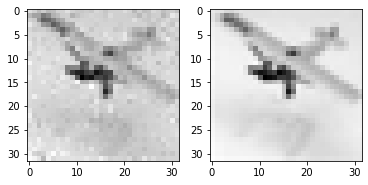

True label: 0
predicted label: 2
Time:  589.484081029892  seconds
Initial fitness: 
 [-0.5076743594019857, -0.4994340959454938, -0.5158391906795688, -0.5076134274974891, -0.43756226478884497, -0.5028183944027379, -0.473508883610214, -0.48923136721858074, -0.4313002805886003, -0.5066850962379168, -0.4906449368214554, -0.570241415984146, -0.5251045663415002, -0.5406426515495969, -0.37157237459364045, -0.4728400822553004, -0.4929399212378024, -0.5569727348652099, -0.492309583604144, -0.43171697026086375, -0.4913193763047593, -0.4903419945160977, -0.48357041638009257, -0.5175109181876085, -0.5215478801787071, -0.37834295272873186, -0.5061589504263251, -0.44632215500291544, -0.5177636070713137, -0.51113896836826, -0.5219497362799351, -0.5209514706554593, -0.48787624705438376, -0.4135619937341056, -0.5104471004898316, -0.48045687424596056, -0.5162446380396959, -0.4171909743144462, -0.5012638425371103, -0.48604323122623216, -0.45909666240378266, -0.5090031937189337, -0.40824524307155136, -0.5

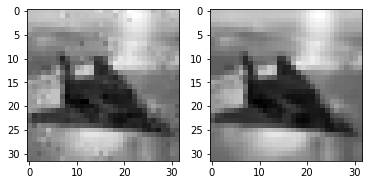

True label: 0
predicted label: 8
Time:  318.6181654930115  seconds
Initial fitness: 
 [-0.2575827948188626, -0.2912947840077842, -0.3662452584086191, -0.3386362542419883, -0.326223732007039, -0.31148317250157764, -0.31154492440719517, -0.2669089367417334, -0.36987858658637257, -0.29948063341507697, -0.4083788365936208, -0.47478551057179375, -0.39489236486959195, -0.3884799126913894, -0.25112912345175753, -0.39525491588840467, -0.46151846220858894, -0.17023347636009548, -0.158436401955671, -0.43214428755296563, -0.3725908145418837, -0.4190157660664454, -0.34049507037486315, -0.2208206989228692, -0.2667874876645867, -0.2355727553141302, -0.1626524511689547, -0.34855514246052566, -0.36833660962711035, -0.26478003191548233, -0.3945362218605889, -0.25728050141813164, -0.3172119028272087, -0.2945127547986666, -0.35022191410295317, -0.3384482540401179, -0.2796891553486549, -0.20105440656721724, -0.32867698058136163, -0.16396079509482725, -0.3507669543683669, -0.3409615659439865, -0.4328610981

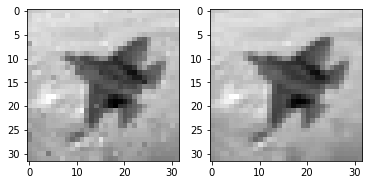

True label: 0
predicted label: 2
Time:  199.99530482292175  seconds
Initial fitness: 
 [-0.5941387755908831, -0.5954913769416156, -0.5965380292032774, -0.5969151452065051, -0.5914305497365342, -0.5930732501502023, -0.5942835689752426, -0.5955803787115277, -0.5978436495653466, -0.5903572184146231, -0.5917395595076191, -0.5898400256781446, -0.5945116459745317, -0.5945916826947517, -0.5950346684161287, -0.5960639110459699, -0.5931714831607572, -0.5945474768201712, -0.5958371349699452, -0.5954347915704614, -0.5967336897646374, -0.5908015900844591, -0.594372285712302, -0.5921174222930252, -0.5924445769923642, -0.5952689588737448, -0.591217360635893, -0.5909972299830026, -0.5941437402694535, -0.5919231916434361, -0.5925013481680664, -0.5976281132599351, -0.5951399563665691, -0.594898309638586, -0.5936822226415474, -0.5959422055588351, -0.5950294107447454, -0.593127734733776, -0.5946042250967012, -0.5933995556302084, -0.5937898129723239, -0.583773815309993, -0.5932627362569317, -0.59099616474

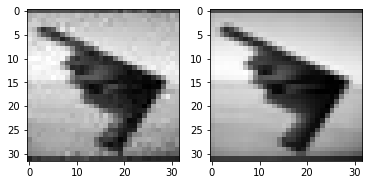

True label: 0
predicted label: 2
Time:  406.410683631897  seconds
Initial fitness: 
 [-0.5641351243311187, -0.5416876011654872, -0.5424472714303383, -0.5552512457530314, -0.5422229480257367, -0.5596828957581018, -0.5413891925129847, -0.542863043321431, -0.5392978107879172, -0.5445198078288629, -0.5120271256255058, -0.5521671750329181, -0.5336642359662914, -0.5589932223225955, -0.5354109633321856, -0.5527507342961455, -0.5105779304838868, -0.5666705833753019, -0.540758029537999, -0.4988404239700519, -0.548499877174, -0.5422245355290938, -0.5040013216962319, -0.5473195304070035, -0.55042258637551, -0.5486544133827725, -0.5239423255312156, -0.5647993017954434, -0.5267420766060573, -0.5721602102779358, -0.5003819931098519, -0.5229458981653864, -0.5288490005934431, -0.48696468206644333, -0.5722036723834699, -0.5002611159769669, -0.5141595687075602, -0.5000781601157391, -0.547006972477711, -0.5026511379452168, -0.5194778826678699, -0.5657606547684131, -0.5630790260502617, -0.5432837407540092

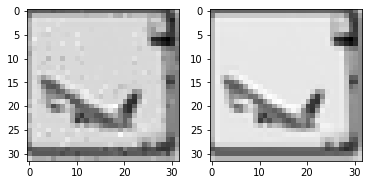

True label: 0
predicted label: 2
Time:  112.97407865524292  seconds
Initial fitness: 
 [-0.5941577732863681, -0.5981922105281983, -0.5977894328931141, -0.5941134372883552, -0.6075001204295059, -0.5976988034633964, -0.5977697535595511, -0.601057675977483, -0.6105498346252758, -0.596119348787272, -0.6160160817404509, -0.6082764694941227, -0.6175118543808096, -0.610782897993527, -0.6078303491329713, -0.6028343124327997, -0.5748477966561913, -0.5970532906238184, -0.6121118595897707, -0.5934150385824365, -0.6062196651935599, -0.6045699145795396, -0.6086386653840463, -0.5982315837100542, -0.598171156958339, -0.5912410200347489, -0.6056189999010925, -0.5939514092999644, -0.6195194703648006, -0.5987253662195574, -0.6020796502459312, -0.5809125882310873, -0.6231479197922595, -0.6085011701964573, -0.5852971906287769, -0.6024965130100467, -0.599077593358387, -0.6023122958709978, -0.6013895477011219, -0.6027051772222215, -0.5967711788893674, -0.593855375530641, -0.597854282244153, -0.6039080587648

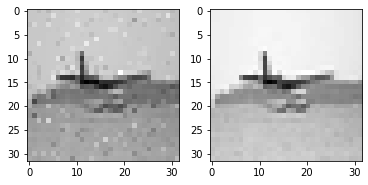

True label: 0
predicted label: 8
Time:  117.29840564727783  seconds
Initial fitness: 
 [-0.6014173374194126, -0.6051420876105226, -0.6031503903965886, -0.6030518715204606, -0.6011068721683515, -0.603719720135169, -0.6005047865617381, -0.6033020846610779, -0.6015543745728484, -0.6017210386424908, -0.6000413693924103, -0.6047746418763343, -0.6061031875288374, -0.6051866462747757, -0.6060388749609525, -0.605967152770172, -0.6094419423221712, -0.6007648533888621, -0.6018691460501715, -0.6001978272125367, -0.6119086713231239, -0.6007404993998684, -0.6009730278424253, -0.6042545630307636, -0.6039507365141631, -0.6060224505912215, -0.6011540860873982, -0.6016944635538628, -0.6008625444404221, -0.6000331249797084, -0.6018444956705766, -0.6016963080923987, -0.5999790321707639, -0.600410897667951, -0.6068744937899191, -0.601281900708053, -0.602060236108872, -0.6049848625358112, -0.609294266699837, -0.6003110206854595, -0.6055663918109032, -0.5996449294014845, -0.6038759538463812, -0.600573382154

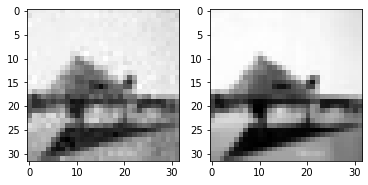

True label: 0
predicted label: 8
Time:  465.05548191070557  seconds
Initial fitness: 
 [-0.5984595130077475, -0.595422761797072, -0.5966805650899223, -0.5960920215455403, -0.596161767894209, -0.5959809000954235, -0.5971861206234762, -0.5973414433717529, -0.5968566381138257, -0.5944145000702026, -0.5973370848553745, -0.592142376268948, -0.5879783251029814, -0.598260843348465, -0.5965789885712032, -0.5955727736352965, -0.5970119449449202, -0.5963352266059043, -0.5959184128855987, -0.595204345274696, -0.5958511967348474, -0.5953569613918193, -0.5963054082579606, -0.5960382194595042, -0.5958244108139847, -0.5955719483464188, -0.5975238626998497, -0.596551299962465, -0.5954783998417215, -0.5925629229203382, -0.5962051665925944, -0.5965774132017936, -0.5945519061784565, -0.5961408806718633, -0.5948829862371231, -0.5940249018467789, -0.5965407877316584, -0.5956916713107626, -0.5955087843826071, -0.5958030850674494, -0.593203494046854, -0.5932469042182363, -0.5961573883539903, -0.5955853536838

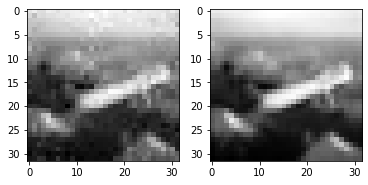

True label: 0
predicted label: 4
Time:  915.9149558544159  seconds
Initial fitness: 
 [-0.5771364793770535, -0.5812094386882427, -0.5774607381678982, -0.5691421929891956, -0.5927120051583489, -0.5705746766897479, -0.5668555119906734, -0.572037246169676, -0.5777650621715427, -0.5921227180556806, -0.5838221704521439, -0.5783953598093934, -0.5855326740386839, -0.5837454862536384, -0.5736767548851284, -0.5728056347669943, -0.5886440276989449, -0.5812607876508895, -0.5782692108183376, -0.5779118350224887, -0.575207650175324, -0.5677694405027793, -0.579810855337163, -0.575580669649622, -0.5780998411562702, -0.5530317157400676, -0.5898876813906405, -0.572951410727299, -0.5661181387336296, -0.5879783088561341, -0.5742098938577678, -0.5499026617044729, -0.5835935950337664, -0.5653839778488345, -0.5605649886298807, -0.5826314381812626, -0.5537341569948102, -0.5709785938020688, -0.576423517357634, -0.580254997208366, -0.5800282786516102, -0.5787209528976494, -0.5782922130381216, -0.58109910076296

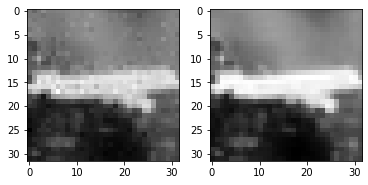

True label: 0
predicted label: 8
Time:  456.109658241272  seconds
Initial fitness: 
 [-0.18906741359120918, -0.19708017120929627, -0.24601340538076147, -0.10260599328132253, -0.014077589564918197, -0.17244564032861676, -0.14863528115636607, -0.28739214553993575, 0.07761958515124782, -0.20151048110308667, -0.23466454520346655, -0.2650937101202189, -0.1412020768199849, -0.3140741322541911, -0.011419603193147831, -0.13113812577201975, 0.22241592487885806, 0.25828220692525433, 0.005277435708605671, -0.014898848079132332, -0.23109483091345934, -0.005687346347934413, -0.1914175616244661, -0.15936583304883178, -0.09704371716326204, -0.06817006023690847, -0.08709358620431043, -0.19741278901812492, -0.2998543680583281, -0.1452707004829906, -0.050663870991347615, -0.18801249017378222, -0.011875844465183472, -0.07264045734521182, 0.13668021076029785, 0.10499927912760043, -0.34074939636483315, -0.14097334031429962, -0.24115689867893148, -0.227209932003321, 0.48158412208791146, -0.2628033876523733,

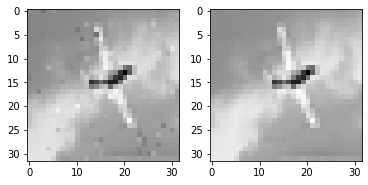

True label: 0
predicted label: 2
Time:  210.39886021614075  seconds
Initial fitness: 
 [-0.5340373308773294, -0.5369789881080762, -0.5119637919627625, -0.5122920842563313, -0.5308194485356704, -0.5183666434281925, -0.3816850966275487, -0.5429934156949119, -0.5583288054700497, -0.4827787882848513, -0.5488510361893597, -0.5454954763070194, -0.4890582074646864, -0.4638076821003153, -0.4376146724891014, -0.5649117281160333, -0.5483097675320971, -0.510713325264395, -0.5429589986345046, -0.486417409960627, -0.5361128626095817, -0.5708337566639115, -0.5033011492741856, -0.5259815144666959, -0.5357498215700274, -0.48977176217913165, -0.5271404464252781, -0.5028630724287033, -0.4769727944040225, -0.4715394588392823, -0.5241605647425635, -0.48286738354973857, -0.48407785427666183, -0.5187697834019703, -0.5564117958770338, -0.5218494237428503, -0.5673070996941796, -0.5164475845416426, -0.5480677423969299, -0.4444498963989719, -0.5010705933781334, -0.5348253746642657, -0.5594680068910104, -0.55311

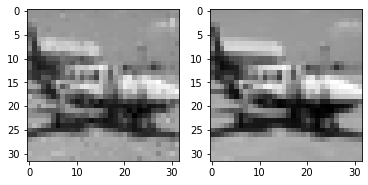

True label: 0
predicted label: 9
Time:  483.9814896583557  seconds
Initial fitness: 
 [0.36721433289464933, 0.3971453493595841, 0.42975729192970435, 0.42646921708359475, 0.37698623374116275, 0.4045362769636417, 0.5034149916059486, 0.4524744010440228, 0.4503222702200122, 0.544077454611767, 0.5456744356802203, 0.3723892226904538, 0.46901176000154904, 0.458039848010501, 0.6289704484644378, 0.6278397728054436, 0.4612442143989838, 0.4734227580003295, 0.3839369234740635, 0.442196487052859, 0.4623107254669957, 0.3653506854447712, 0.37073973349836, 0.361548205718767, 0.40251987904311887, 0.36316035370659233, 0.4429364882258997, 0.562686889773206, 0.3732983431504044, 0.5834605333190017, 0.707041297674232, 0.39310450678462666, 0.40606263229823925, 0.46233231970707117, 0.33959066355923184, 0.3570170048516652, 0.46343512413247623, 0.5200804882393023, 0.3648522433932231, 0.4499303804338208, 0.36527009990812825, 0.05720897169221115, 0.4911679268183998, 0.4668569323633795, 0.4040832500997381, 0.44560

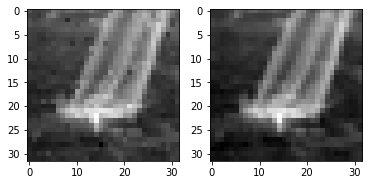

True label: 0
predicted label: 2
Time:  229.43995761871338  seconds
Initial fitness: 
 [-0.12148917772483886, -0.1910805028287716, -0.3033854022136261, -0.1782402277934487, 0.0038645414344999907, -0.29709133761721834, -0.3132152060769883, -0.3342014368353724, -0.4245944668516545, -0.2953657100214353, -0.14141231970428636, -0.22044530144859173, -0.3921206515831153, -0.2689679843355089, -0.14371770444191764, -0.24130524506781467, -0.21536432272879108, -0.2782136351401644, -0.1416760615024195, -0.2578448266549164, -0.09592392992154469, -0.14276491691771673, -0.25065038148213714, -0.1701777287115487, 0.03556129371291006, -0.13590024004362278, -0.22020999083211362, -0.42746903940660747, 0.05484005497520489, -0.12924183684403695, -0.27180436691356585, -0.4111418140177533, -0.32787258025818644, -0.08530253079765496, -0.26097551006632913, -0.2886059379269895, -0.32210320687702687, -0.20914583298447537, -0.2540046633403741, -0.2879786444245011, -0.08205680091860054, -0.30435452977469357, -0.267

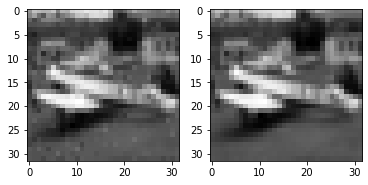

True label: 0
predicted label: 8
Time:  301.3283803462982  seconds
Initial fitness: 
 [-0.6012238965221693, -0.604677421504985, -0.6017528718988433, -0.6016921169642979, -0.6003322976744339, -0.6005864519926487, -0.6002551112973475, -0.6019146672376152, -0.6009431200175156, -0.6008150957169871, -0.6014757719350647, -0.6032688333458078, -0.6016192833370633, -0.6020834246947164, -0.60030840027313, -0.6017489373869891, -0.6002886618355797, -0.6016315893543018, -0.6012795273142902, -0.6027067412210686, -0.601911375513296, -0.6010963864198403, -0.6010130309731686, -0.6005128408166942, -0.6022995481006914, -0.6012222454747094, -0.6004155131050797, -0.6011973540848825, -0.602041988386635, -0.6007060996036211, -0.6020082246439383, -0.6016660680007966, -0.6009146491732653, -0.6023096428978685, -0.6005150200024918, -0.6037986730512356, -0.6004456940577676, -0.6014167760759906, -0.6014397375588227, -0.6032460892199819, -0.601539691996718, -0.6018623818040668, -0.603898757139992, -0.60020520750501

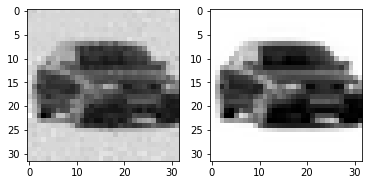

True label: 1
predicted label: 8
Time:  798.1792912483215  seconds
Initial fitness: 
 [-0.5172733686127685, -0.5616765060392216, -0.5689138097377343, -0.5413053544906136, -0.5283574418194437, -0.5675723662691667, -0.5583057144881443, -0.5169938378103385, -0.5254732179776285, -0.535707447726931, -0.5587675508147156, -0.5557259422603551, -0.47776375349227784, -0.4188870144214826, -0.5492671507206307, -0.4909655885642148, -0.5208191999081867, -0.5399968707266364, -0.47007269790808814, -0.5539772811191864, -0.5587755439302908, -0.4562183064601546, -0.5205729808295432, -0.5369076558089327, -0.548323598651231, -0.5731502645948213, -0.5333574564560344, -0.5548361826308441, -0.5279219476604848, -0.5442904088992118, -0.5765650561713523, -0.5069419596341532, -0.5524684936316286, -0.5532079498335288, -0.5637374071495118, -0.5481213661198974, -0.5588683788875953, -0.5796619074098784, -0.5440299101772199, -0.5403981869707848, -0.5232645936043299, -0.5548158493708765, -0.5501640557528036, -0.5290930

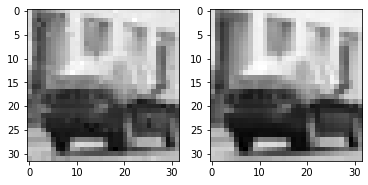

True label: 1
predicted label: 9
Time:  212.06827783584595  seconds
Initial fitness: 
 [-0.6023641392721782, -0.600667623440525, -0.6020332427639844, -0.6030491738833151, -0.6048400999040039, -0.6067097619474556, -0.600462430873282, -0.6008312529921969, -0.6014520827777083, -0.6011570099520517, -0.6008918902949294, -0.6009091573378955, -0.600220181973038, -0.6019347645275597, -0.601144316332398, -0.6012290836208642, -0.600916806902146, -0.6019006840493859, -0.6009706120562005, -0.6021273561929363, -0.6008066864496395, -0.602215366161877, -0.6030311262281876, -0.6026017030715437, -0.6100605583779749, -0.6037885325986796, -0.6026472998476888, -0.6047692758028385, -0.6003032808044815, -0.60412384539086, -0.6029871429522484, -0.6000413569238097, -0.6021655224838679, -0.6013463174634308, -0.6003798355316372, -0.6012886892838335, -0.6023825644536722, -0.6017510767539465, -0.6037899466142765, -0.6020022450451339, -0.6026842963768362, -0.6012928957958921, -0.6005303928155772, -0.60059487809631

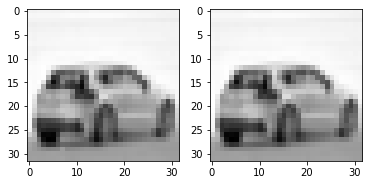

True label: 1
predicted label: 1
Time:  117.99642705917358  seconds
Initial fitness: 
 [0.3668416434104206, 0.7484425799745108, 0.357954365386035, 0.29162869729031254, 0.43368470612004495, 0.43073286219809415, 0.4828500187062004, 0.3607423600792711, 0.29045883495476194, 0.36308644686933134, 0.38905270133728886, 0.5286701707116037, 0.3592757895151607, 0.1578692297686687, 0.3765795872545136, 0.4955051593946128, 0.49742331626446223, 0.49831332852734567, 0.34719651332802925, 0.24241825218923635, 0.4275291756750921, 0.28703850740192927, 0.3146530137081982, 0.24654415907348243, 0.3576818115753339, 0.3118298668597455, 0.361644288478277, 0.3952823451383594, 0.3850542045038281, 0.3418965313918992, 0.4156321066648313, 0.3282788519438844, 0.3017396864543581, 0.6832887175010882, 0.4756667054700183, 0.39323591496444177, 0.1691601062932947, 0.3830189612496955, 0.4962157277486541, 0.29141538244878307, 0.46779088896400467, 0.24555646499594874, 0.09663932098953945, 0.311078917610432, 0.2957828433702599

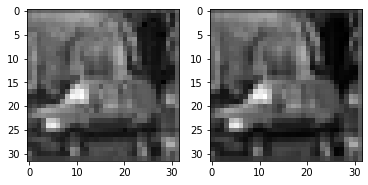

True label: 1
predicted label: 7
Time:  190.94977355003357  seconds
Initial fitness: 
 [0.5150602176198391, 0.5867104108307083, 0.5211988111738741, 0.379024582444032, 0.42424750501534203, 0.5110869531835546, 0.6380366228871533, 0.4950058591278095, 0.5317264847290126, 0.5341445090365948, 0.5614651418732429, 0.6342273783580424, 0.586633570312038, 0.6099777555391358, 0.650950084538255, 0.5730874486902996, 0.6448759165757569, 0.5367001498203976, 0.5738454670278949, 0.6099482207695859, 0.3872218038302607, 0.39178583364798736, 0.6185397729485308, 0.5557643566039976, 0.6231100882915805, 0.6508603370024705, 0.4629120331961048, 0.5410544744183958, 0.5399852268430663, 0.6564643511186127, 0.5213168415427751, 0.6628023873235078, 0.6378349515910844, 0.5781030311682899, 0.5718372503986483, 0.4669190734938846, 0.5617807630319289, 0.6100961877480625, 0.6163639335140033, 0.5518638735062893, 0.42566349480875454, 0.4100477620824473, 0.549319450811566, 0.4779939249415925, 0.45082606459932556, 0.4839729716

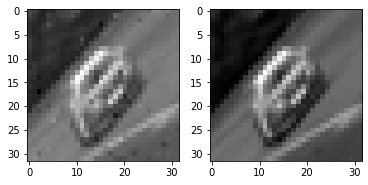

True label: 1
predicted label: 6
Time:  185.8579671382904  seconds
Initial fitness: 
 [-0.5943244876091907, -0.5882536426448162, -0.5850637174142957, -0.5928903388433865, -0.5955733858913483, -0.5841287754563285, -0.593402432499705, -0.5939233249241397, -0.5946893332754317, -0.5935929087516272, -0.5933927914200282, -0.5918596450500917, -0.5888458818059816, -0.5861334250836865, -0.5956725306689743, -0.5912285560963164, -0.598475826297832, -0.591565333204995, -0.5937510818218421, -0.5936493492026271, -0.5876764498736704, -0.5937808111287199, -0.595494678905101, -0.5886889911235144, -0.5943582367749835, -0.5964029263889045, -0.5917547007971771, -0.5831094633329865, -0.5796246507460443, -0.5871116740810982, -0.594189368358245, -0.5814766081550615, -0.5946403454053472, -0.5950028031641128, -0.5955551948964483, -0.597195927492226, -0.5911908496220712, -0.5923143381624366, -0.5934829985384565, -0.5936077364889802, -0.594808678463837, -0.593159221278186, -0.5916052028604777, -0.596626512353819

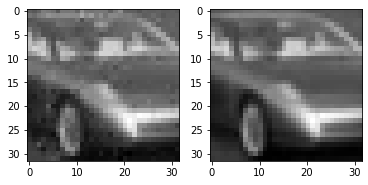

True label: 1
predicted label: 0
Time:  273.07034277915955  seconds
Initial fitness: 
 [-0.6000531407312868, -0.6000138685730171, -0.6000632322458701, -0.6000661430512418, -0.6001367773530484, -0.6000312683935864, -0.6000971435702218, -0.6000236866861024, -0.6000424679231683, -0.6001232467444544, -0.6000365124090861, -0.6000673275228086, -0.6000267106779819, -0.6000109594783645, -0.6000239198382318, -0.60004049133832, -0.6000987460556879, -0.6000253614544738, -0.6001103110933009, -0.6000501838081865, -0.6000353967474527, -0.6000772384916047, -0.600034660954325, -0.6000306696174404, -0.6000765788528208, -0.6000331755990068, -0.6000589208788765, -0.6000654435269323, -0.6000632719350842, -0.6000044727694354, -0.6000073408636843, -0.6000507886252553, -0.6000430304815282, -0.6000432070382313, -0.6001897974464905, -0.6000375251103226, -0.6001000150571727, -0.60005947242204, -0.6000203958330388, -0.6000309113655977, -0.6000612486048826, -0.6000708690312319, -0.6000667047245343, -0.60001811503

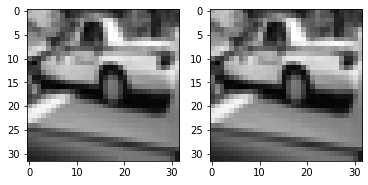

True label: 1
predicted label: 1
Time:  117.2061083316803  seconds
Initial fitness: 
 [-0.6004994420932193, -0.6003170836371895, -0.6005243012157852, -0.6008475632577668, -0.6003164689007816, -0.6012412241447092, -0.6005812218529797, -0.6006521987376188, -0.6015879081767923, -0.6030182817008631, -0.6003931157502902, -0.6000642524308932, -0.6007176386990183, -0.6009653717589281, -0.6000531330035441, -0.6000847482065554, -0.6012952791096795, -0.6020286989956636, -0.6001012842837705, -0.6013516447488196, -0.6001121401667147, -0.6001280196112669, -0.6004570398738047, -0.6000259216975358, -0.6000581528276938, -0.6010593978847848, -0.6014489743133216, -0.6000988162264568, -0.6016526977922948, -0.6013699885580482, -0.602198756394311, -0.600067295528862, -0.6000691976512627, -0.6014805426009697, -0.600099455715058, -0.6010517565912548, -0.600626324695034, -0.6001862241732623, -0.6000711876748754, -0.6000568789597018, -0.6001738290630609, -0.6000626406013959, -0.6000721476041223, -0.60241199713

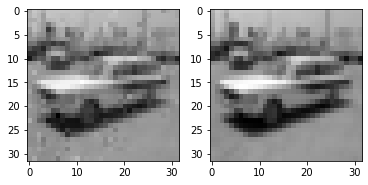

True label: 1
predicted label: 0
Time:  286.47729754447937  seconds
Initial fitness: 
 [-0.6000652429970138, -0.600011155808708, -0.6000435149030985, -0.6000099437080584, -0.6000392908938144, -0.6000654966603283, -0.6000268931000786, -0.6000263205849075, -0.6000620389513651, -0.6001191272925772, -0.6000826322432231, -0.6000855252365513, -0.6000214922690233, -0.6000703306292707, -0.6000141756705178, -0.6000900573218717, -0.6000189568668068, -0.6000565860901673, -0.6000326812685138, -0.6000183032876591, -0.6000320603829451, -0.6000988935155757, -0.6001092868957391, -0.600028053358973, -0.6000905402271439, -0.6000540536929795, -0.6000593198469312, -0.6000180734959808, -0.6000534407998541, -0.6000311380321899, -0.600007802387938, -0.6000802634240121, -0.6001237562229934, -0.6000593364124736, -0.600061346573201, -0.6000518730760135, -0.6000913400873498, -0.6000455833093323, -0.6000535178011481, -0.6000124152527275, -0.6000315484954368, -0.6001186241518393, -0.6001424291706389, -0.6000169446

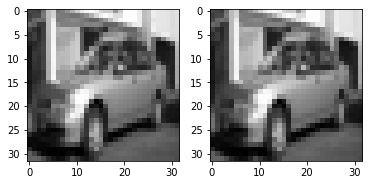

True label: 1
predicted label: 1
Time:  126.0211763381958  seconds
Initial fitness: 
 [-0.6004108245387958, -0.5996287231644927, -0.5994919576604093, -0.5995424476677055, -0.5996682809129552, -0.5994677672666049, -0.5998548319304585, -0.5998449814218587, -0.5997753165450365, -0.5994363059144969, -0.5996795571699362, -0.6000725653440242, -0.5996005865059963, -0.5999681660192331, -0.5998144090011663, -0.5991888851155269, -0.5997879418742232, -0.599514360513855, -0.5998148115239686, -0.5997277075513628, -0.599360937983892, -0.5993163327123447, -0.5990138628814298, -0.5994359301634763, -0.5997286136013726, -0.5994996884332062, -0.6000471903205008, -0.598203757591876, -0.6000165347197953, -0.5993638824234694, -0.5998988707153443, -0.5999259660953927, -0.5996293689645028, -0.5991819193959956, -0.5998082575151901, -0.5993829937443597, -0.599592465481614, -0.5999724560299934, -0.6000452878523881, -0.5996124124557729, -0.5997700854155155, -0.5997402433661737, -0.599558982085107, -0.599580317699

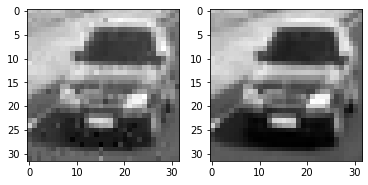

True label: 1
predicted label: 9
Time:  224.3880877494812  seconds
Initial fitness: 
 [-0.6000431090300447, -0.600241580808515, -0.600265483563531, -0.6000998376608044, -0.6002233745088774, -0.60009892533163, -0.6001791288765546, -0.600033352718075, -0.6001695923881958, -0.6002226123111392, -0.6000543151548978, -0.6001292077221835, -0.6000633419348698, -0.6000396736157532, -0.6001078826292359, -0.6000364918637908, -0.6000729127614233, -0.6004232374428475, -0.6001377319910435, -0.6000822142367489, -0.6001379245167934, -0.6000519307561999, -0.6001317282061748, -0.6001352853040526, -0.6000434029099642, -0.6007494928822836, -0.6000561144825002, -0.6001283894134979, -0.6000988076286637, -0.6000494710409726, -0.6000753737903793, -0.6001095692857793, -0.6001118173388061, -0.6002328623011702, -0.6002417282098915, -0.6002371091782166, -0.6000820562099384, -0.6002896567975519, -0.6000891773018859, -0.6001121077219215, -0.6000618598792085, -0.6000232850267795, -0.6000520145832995, -0.600342566358

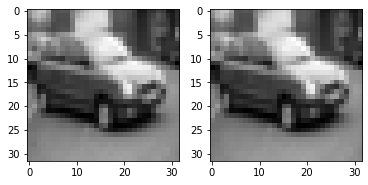

True label: 1
predicted label: 1
Time:  114.57906436920166  seconds
Initial fitness: 
 [-0.6003599808462794, -0.6000047881630325, -0.6004127458706289, -0.6000450110108831, -0.6001524896440444, -0.6000517631254558, -0.6000814527421496, -0.6001597185919899, -0.6001648631514113, -0.6001399464278641, -0.6003738253577142, -0.6003037166953737, -0.6000877707798367, -0.6006251169370442, -0.6002195326502826, -0.600332382786667, -0.600152908005323, -0.6001867428635078, -0.6000973302320417, -0.6002350061254698, -0.6001272818947052, -0.6001367014875312, -0.6000615458761739, -0.6001699968490412, -0.6003094013042813, -0.6000602366327034, -0.6002609687940876, -0.6001516085638484, -0.6005404296905718, -0.6003283011043938, -0.6002439763635571, -0.6000971508263656, -0.6001453798180043, -0.6000576514173709, -0.600716081059709, -0.6000722725345315, -0.6000423030995088, -0.6000307381890089, -0.6003105900344595, -0.6000177846869502, -0.6000362465508374, -0.6000561758997875, -0.6003870403451823, -0.600187667

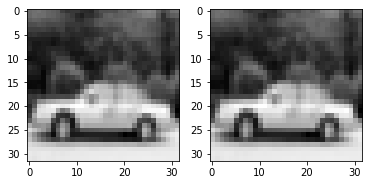

True label: 1
predicted label: 1
Time:  117.2768292427063  seconds
Initial fitness: 
 [-0.5905918512208129, -0.5965680014847373, -0.5962275834329547, -0.59044850069075, -0.5809304683248614, -0.5943484323533194, -0.5943248523491171, -0.5940695650472264, -0.5940314065120792, -0.5958083786073304, -0.5927817786649711, -0.5927963396956146, -0.5866569316356359, -0.5962215752242156, -0.5899687223190441, -0.5920755756359543, -0.5907881161607431, -0.5944212510023636, -0.5880677100961929, -0.5960090225222823, -0.5837046984322815, -0.5944002435371525, -0.5916754890441697, -0.5917338695285163, -0.5917717543511252, -0.5931686675649573, -0.5926326320413254, -0.5810023899427278, -0.5910141148463481, -0.5934232093368992, -0.5951124645058552, -0.5838170316731034, -0.5933686854206642, -0.5953783564388, -0.5923307394561451, -0.5939357808618432, -0.5915655673478658, -0.592286806657334, -0.588742895028893, -0.5878661117366969, -0.5929137195805367, -0.5940352020005221, -0.590712745177036, -0.593664349609674

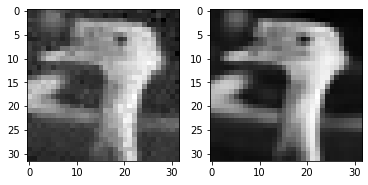

True label: 2
predicted label: 3
Time:  879.7805593013763  seconds
Initial fitness: 
 [0.8212756904287111, 0.7185038052167637, 0.5184836541078732, 0.6247249349735078, 0.6965153382998336, 0.6408713318133188, 0.6434875175418437, 0.7893086960748859, 0.6858594380222535, 0.7337774054405514, 0.6663482803092826, 0.4200074463292252, 0.7239101916633489, 0.7211115038690636, 0.7908066870593132, 0.8219002133731799, 0.5527456704559671, 0.6929115349540939, 0.5985239536040514, 0.6785812146273453, 0.6113582616044825, 0.7334897927200348, 0.6156190874337579, 0.4789720712320687, 0.42391227742976073, 0.7796527276095153, 0.6462072805034774, 0.5387792868862904, 0.5004375834860256, 0.6445096457234476, 0.7643399707662226, 0.6424833794710789, 0.7548083564433615, 0.4016380221456858, 0.5539381824683266, 0.5938985063837678, 0.6569789012303463, 0.5824223555678085, 0.5770168787221658, 0.6862822347565234, 0.5234906658467827, 0.666925482762669, 0.6398669144734644, 0.6345486986152008, 0.6766492372647863, 0.58162792338

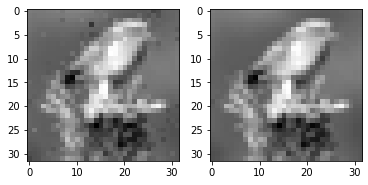

True label: 2
predicted label: 6
Time:  181.04795837402344  seconds
Initial fitness: 
 [-0.1898099868784014, -0.17297424504135472, -0.21952120036418557, -0.16024563985257176, -0.15148363188805702, -0.26493529199936244, -0.29154299649215265, 0.09659589742610308, -0.24483041528470778, -0.22845967824183586, -0.2306493531198823, -0.1748238302440271, -0.13877228420867008, -0.15792204232375254, -0.2724771138323965, -0.28317990006530647, -0.2674394912635893, -0.2825775719737328, -0.2808704518265024, -0.25062263445381133, -0.08192536998623545, -0.20892036285241736, -0.24624467222941993, -0.125750071962222, -0.19773017619638997, -0.18052473860830326, -0.24773488706935104, -0.07724878108042688, -0.14714799573994491, -0.135666174212625, -0.22718479999457444, -0.22615880864767682, -0.26302638069534856, -0.22099681172999125, -0.2153304123844726, 0.1906851177478107, -0.08113516605168156, -0.12656725775579739, 0.16733469736877848, -0.19049911466147976, -0.12274883517929319, -0.19762754677809374, -0.1

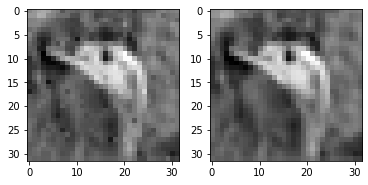

True label: 2
predicted label: 6
Time:  171.3753068447113  seconds
Initial fitness: 
 [-0.16545326002049326, -0.054968532735650555, -0.35181448384394876, -0.24668462860101678, -0.4015147844160876, -0.2501775295789769, -0.16752623845256495, -0.24117309303339607, -0.23878773051853022, -0.15402202074828736, -0.2643905133273995, -0.239506399043036, -0.12209466304965932, -0.11235537925174491, -0.43203962719003597, -0.32435959678672444, 0.0021542986935486064, -0.1651363969063063, -0.22767950080357863, -0.2972199762346025, -0.23736082743860176, -0.17659843354195948, -0.27587809962441523, -0.4747578320226201, -0.1590369655701806, -0.3805264592720108, -0.3245455146266012, -0.47812916957361995, -0.29249113787526015, -0.2194445672780597, -0.4175361199580798, -0.2421074152463305, 0.01315900826677524, -0.32357099804455614, -0.13961183856228424, -0.380922160434529, -0.22072016910329068, -0.16556963371646127, -0.40594069316523795, -0.27452539092481365, -0.10923447208068648, -0.2598650339811311, -0.22

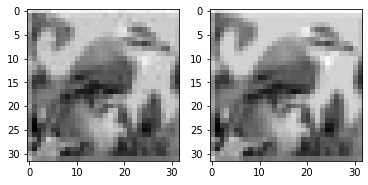

True label: 2
predicted label: 5
Time:  309.31746554374695  seconds
Initial fitness: 
 [-0.5998678717560451, -0.6000115055546288, -0.5997405128449583, -0.6003040020755872, -0.6004904953515766, -0.6003675457373168, -0.6001415387327484, -0.5998240767541863, -0.6002134467792821, -0.6004798900335201, -0.5997369891440918, -0.599820768878682, -0.5999764138485413, -0.6016596232161309, -0.6002973723588352, -0.6000049532105975, -0.6004969643395722, -0.60059176734079, -0.6000950857404004, -0.6007682460995055, -0.5999375869843256, -0.600343260662547, -0.5999863383547881, -0.5997477898824177, -0.5998775848966905, -0.600052172452607, -0.5997719393908414, -0.6000469335387658, -0.6003302497677494, -0.5999681966466361, -0.6001420594760314, -0.5997245590089877, -0.5998649089116119, -0.6008493641579113, -0.6005743130300787, -0.5997045881047521, -0.6001258477915051, -0.5999111455693328, -0.5997239550709428, -0.6024973859519435, -0.5998515227537012, -0.5999172158635934, -0.5999531441838195, -0.59985498593

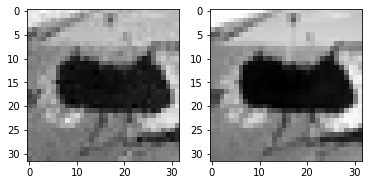

True label: 2
predicted label: 6
Time:  871.3998093605042  seconds
Initial fitness: 
 [0.22827814222785997, -0.22757658477431217, 0.0901143593469152, -0.05348126546654852, -0.15669865357137724, -0.10471549645901498, -0.05860030031162472, 0.07999082981554757, -0.1611713326712994, 0.1503671999665153, -0.16455269027067135, 0.24840687064202235, -0.239718196100252, 0.06396088927719706, -0.006855586488902027, -0.1585062828922235, -0.11041048957997915, -0.13745618227467055, 0.13768950130438645, -0.20880881112382838, 0.1975493956269737, -0.26898591191291543, -0.2968456982316213, -0.11648310754204255, -0.3297987239294774, 0.004411143777322768, -0.007748929291102824, -0.1077567806418801, -0.1642212594252567, -0.26529847388607036, -0.23218230656964595, 0.045291364015052904, -0.010370936751849302, -0.04700145243919224, -0.3673553155947049, -0.11270165965465273, -0.396001368042067, -0.2740417194183534, 0.03154734291161346, 0.09448450696841862, -0.06823007969045558, -0.23483108405988848, -0.32716411

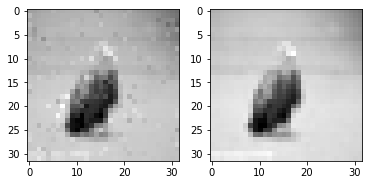

True label: 2
predicted label: 6
Time:  256.8110091686249  seconds
Initial fitness: 
 [-0.5968813054699006, -0.5926255571790964, -0.5964216219722696, -0.5844893089108798, -0.5986127538624071, -0.5955386667354483, -0.5944387391892714, -0.5962283911768964, -0.5955390127876703, -0.5928955001679297, -0.5947853138850089, -0.5946511920152595, -0.5946206102486212, -0.5956379799242544, -0.5950596926939923, -0.5956705083956975, -0.5960105932853017, -0.5944547960053772, -0.5984985780798371, -0.5963486566200733, -0.5953039587029081, -0.5942106105235052, -0.5952706363894299, -0.5962216556839292, -0.5967124757126673, -0.5942046755493724, -0.596193349620813, -0.5965745432831896, -0.5976688335335902, -0.597355305110243, -0.5935440378948983, -0.5955391597928749, -0.5975691479227097, -0.5969335098394919, -0.594533523375939, -0.5962798258599376, -0.5939812139113758, -0.5971689975982865, -0.5951816141453697, -0.5974577711507669, -0.5937725424252965, -0.5971498644593827, -0.5957927823710811, -0.5940719247

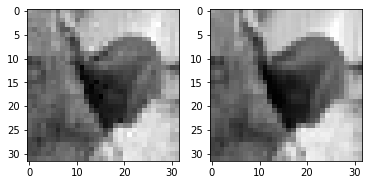

True label: 2
predicted label: 4
Time:  382.1489841938019  seconds
Initial fitness: 
 [-0.04566152976215951, -0.09549792909041743, 0.13905794949066191, 0.012810515998210537, -0.055068642900341636, -0.3230382497008095, -0.17818554600150913, -0.05078700665111502, -0.14108158792998274, -0.2813594744337149, -0.040348514720897316, -0.23842738381644013, -0.17832670557629784, -0.08940361028322982, -0.08709701010620016, -0.4160401395776143, -0.09394185991537105, -0.23890890275592694, -0.32302889816710123, -0.15221136717635472, -0.07637569606787176, -0.3029087454673802, -0.13157412022665227, -0.14734003266614282, -0.1507423165922708, -0.2138849980400844, -0.09406008833843879, -0.23350231575218625, 0.08252990605302471, -0.023787213639644672, -0.07355977157226151, -0.32475899902198757, -0.020540100737880373, -0.11316660585231847, -0.1303080070966876, -0.1033554049374345, -0.19887975671807942, 0.23622518437156906, -0.19221608797145334, -0.07431394928806972, -0.015865931608984196, 0.062155476002825

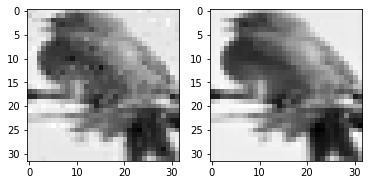

True label: 2
predicted label: 3
Time:  355.2390058040619  seconds
Initial fitness: 
 [-0.5833007584650958, -0.5855697891286457, -0.5861678167871094, -0.5826572618921391, -0.5729319277162759, -0.5864500553167551, -0.5651761250983469, -0.5736969626986037, -0.5759441498390272, -0.5699010745582748, -0.5734087419126485, -0.5790791425602396, -0.59053068044756, -0.5837262579055928, -0.5794016895278775, -0.5815658112629344, -0.5834250812972608, -0.5932475549737298, -0.5857955900724384, -0.5863937480947122, -0.5787372894782217, -0.5884480260519669, -0.575654522673373, -0.5830222502984206, -0.5913565808850088, -0.5830390546800986, -0.5787434192254862, -0.5838168323636241, -0.5602012424093767, -0.5824718361942832, -0.5876098542802499, -0.5528080896729132, -0.5862699330472978, -0.5829588790015617, -0.5895808119993146, -0.5710030608619042, -0.5822214837118821, -0.575353467773134, -0.5786038861691124, -0.5893778720889223, -0.5805260881151827, -0.5819248949360049, -0.5904129442592605, -0.58784439358

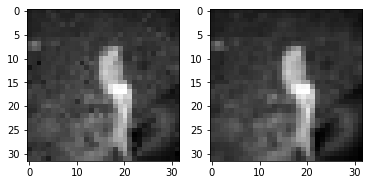

True label: 2
predicted label: 3
Time:  322.77410793304443  seconds
Initial fitness: 
 [-0.5285636110033084, -0.5677567409392653, -0.5526665685680904, -0.5401864936043862, -0.5575990380508367, -0.5212739646617064, -0.5628454722892908, -0.530969761003161, -0.5508506868547584, -0.552953977784852, -0.558183160873979, -0.5538091541128324, -0.559956281774108, -0.5546770533605925, -0.5620739229502643, -0.5677207465069309, -0.5677134901245574, -0.5523047209674443, -0.5643679741685372, -0.5568026985304783, -0.5625176927940416, -0.5570472587536672, -0.5663807891062155, -0.5625227836828743, -0.5438940493079888, -0.5296357586734414, -0.5418651439369101, -0.5121594877924545, -0.5620674419819965, -0.5577692930973522, -0.5520988151374242, -0.5532539561103649, -0.5310171206036363, -0.5617899863891713, -0.5466116200674495, -0.5529783528178971, -0.566877977289635, -0.5609185243248077, -0.5399125257191661, -0.5606197745854884, -0.5529796017364565, -0.5509017215006979, -0.5659965652172259, -0.56043537482

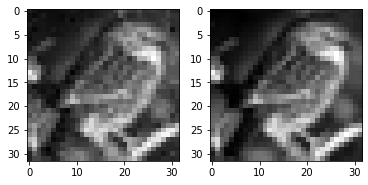

True label: 2
predicted label: 6
Time:  835.9533267021179  seconds
Initial fitness: 
 [0.8870644849361037, 0.825660488890977, 0.8850062462670183, 0.8900827950686152, 0.9364155896371551, 0.8952689451695071, 0.8678073817096806, 0.8811018520122296, 0.8855115823039856, 0.8564917965106558, 0.8944959792354095, 0.8857897149722602, 0.8796793523973806, 0.8861239080853298, 0.8515711454077233, 0.9019256524939063, 0.8928136685805208, 0.842366074652046, 0.8873397046896938, 0.8593834180852105, 0.897692819958215, 0.9330450787133092, 0.9144316252220809, 0.7257758528020681, 0.9138191315335047, 0.9383630737622464, 0.8939167024565413, 0.9000137064652446, 0.8293494193097439, 0.8993258961498966, 0.8864133592779697, 0.8936017632488629, 0.9234967678442363, 0.8961638830147285, 0.8799842325676388, 0.8963408310980361, 0.8414646459677521, 0.9064001136867238, 0.8763107048580033, 0.8863320158501952, 0.8544370872103625, 0.9062920918218779, 0.8869684050590292, 0.9266673084806705, 0.889308084562811, 0.887369952174147

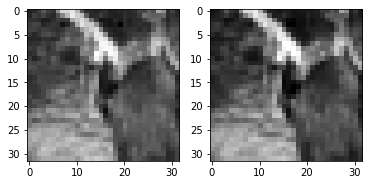

True label: 2
predicted label: 7
Time:  283.54596638679504  seconds
Initial fitness: 
 [-0.6136473860646663, -0.6020152499029721, -0.602836828708384, -0.6252181985158705, -0.6190413195896068, -0.6308899786178794, -0.6105392075178095, -0.6309527724606352, -0.6041229966222879, -0.6118761921046492, -0.6236580297631513, -0.6225015376535769, -0.6041545548730786, -0.612915969490661, -0.6052079111956838, -0.6209733807347328, -0.6219805318922518, -0.6318020159923429, -0.6109559711253838, -0.6114610865553087, -0.6098220610872156, -0.6104135824495007, -0.6204590399877018, -0.6250571189784007, -0.6198204453992998, -0.6203787959860688, -0.6159294227383192, -0.6133034149825336, -0.6228859847729376, -0.6009163402832747, -0.6178969895832833, -0.6174578508874444, -0.6032675229458002, -0.6220612388431828, -0.6165478037994998, -0.6214669910358339, -0.6178332399480708, -0.6135449626754543, -0.6282326112042855, -0.6086197092947156, -0.6203222595759459, -0.6120448424285578, -0.6321200931601209, -0.62389913

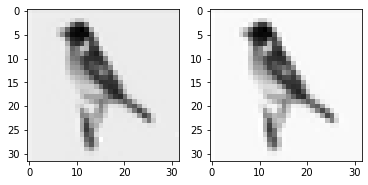

True label: 2
predicted label: 2
Time:  156.86636686325073  seconds
Initial fitness: 
 [-0.6005082291444988, -0.6003777539336144, -0.6004826296983075, -0.6001756272075027, -0.6002403897640222, -0.6003783100897256, -0.6000341501733659, -0.6001887906350629, -0.6001043516515465, -0.6001736361824924, -0.6003459476210995, -0.6001659382469657, -0.6001626317874169, -0.6002885861520575, -0.6002424523073373, -0.6000541054645889, -0.6003323611985419, -0.6005957745263051, -0.6001371100681694, -0.600078222779864, -0.6003580492941649, -0.6001828707257584, -0.6001117696000207, -0.6003064264644057, -0.6003713086486071, -0.6001255476676127, -0.6001830906147919, -0.6000991969742631, -0.6000503701847081, -0.6000587713911332, -0.600251922245504, -0.600443457944976, -0.5999932307760433, -0.6001464288369277, -0.6002054534705588, -0.6001802440681472, -0.6001660575242902, -0.6002740813595757, -0.6001253854353673, -0.6003223257386505, -0.600556741607866, -0.6000861601232753, -0.6002387366047491, -0.6006639277

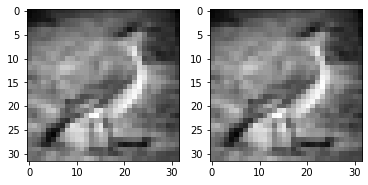

True label: 2
predicted label: 2
Time:  157.75191855430603  seconds
Initial fitness: 
 [-0.6010254824397578, -0.6017887274980209, -0.6013958578981191, -0.6027236824781299, -0.6004872079163284, -0.6006339141878122, -0.6001895666678672, -0.6019226431544298, -0.6013626505894757, -0.602904641617513, -0.6015771305260005, -0.6008997520591626, -0.6004249052113958, -0.6004630340883466, -0.6002601320322712, -0.6006286786828618, -0.6022107714797127, -0.6003006869836154, -0.6021309136410319, -0.6021624311595191, -0.6039724155915399, -0.6005179160945193, -0.6010651102684128, -0.6018779686988533, -0.6000989263827221, -0.603850080404164, -0.6029215813912094, -0.6001633082728562, -0.6019310549494387, -0.6021854688201385, -0.6022595089111527, -0.6037497949386512, -0.6011323499504437, -0.6000086616448673, -0.6013426216229814, -0.6017853152324139, -0.6018644935734295, -0.600307874030167, -0.6017461484923688, -0.6006123306884724, -0.6005675247149842, -0.6032293274272938, -0.601472399288887, -0.6022148549

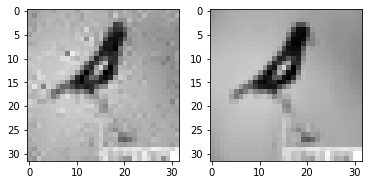

True label: 2
predicted label: 0
Time:  851.5180344581604  seconds
Initial fitness: 
 [0.9880437110642224, 0.974912404151691, 0.9769184604213802, 0.9896708755449662, 0.9872591809629165, 0.9882641069729231, 0.9885095441813593, 0.9908508097230282, 0.9873012933780334, 0.9795027539980813, 0.988649181291643, 0.9925331851676438, 0.9921952359140654, 0.9855776207096731, 0.9922579390409145, 0.9824794992533243, 0.9868989283894725, 0.9859083991651376, 0.986125794626308, 0.9898778837869948, 0.9829606146014022, 0.9910090214185644, 0.9902832069982942, 0.9916437535943448, 0.9865699423133787, 0.9895520913577595, 0.989036351941015, 0.9876039407028219, 0.9849112386519598, 0.9882753668349571, 0.9817139892050308, 0.9893081093765675, 0.9875603768343604, 0.9835703538418054, 0.9924564673779046, 0.9846888052526316, 0.9886691868958726, 0.9959893137682484, 0.9836807272231857, 0.9818157708371023, 0.991647984734657, 0.9903477441126675, 0.980811553249695, 0.9807863533871661, 0.9810788569140657, 0.982432496172152, 

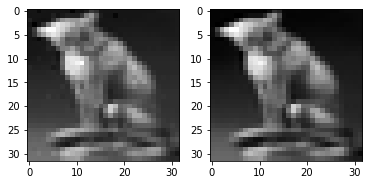

True label: 3
predicted label: 2
Time:  215.2657277584076  seconds
Initial fitness: 
 [0.406130225610791, 0.3518832509686948, 0.3851271927569958, 0.09859093793313566, 0.2512868092220622, 0.26222361837175995, 0.2172372671366944, 0.4090388767222044, 0.27212046735453055, 0.20485001982186185, 0.21444536739695846, 0.3603092390039646, 0.413065104553679, 0.31237040098035596, 0.1660841354985844, 0.18980426051201812, 0.4033025157326539, 0.4286615254805344, 0.3863502088939834, 0.1904359859311584, 0.3092256773519584, 0.28618352029014227, 0.24499417222863637, 0.2869302844655059, 0.11597586877094346, 0.5032975107386186, 0.10046043236299991, 0.23299472208289237, 0.2387853233187435, 0.4715973961529245, 0.36869041095301924, 0.12478690847633234, 0.10593109739462286, 0.2677692832847172, 0.3035790615237826, 0.4523292650453785, 0.3572448747190523, 0.46226849014978794, 0.5083789647952702, 0.2608159754722957, 0.4950388615170063, 0.25739653964672676, 0.479576394491225, 0.22127219331901957, 0.2053677041898179

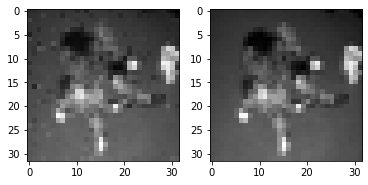

True label: 3
predicted label: 0
Time:  313.60587644577026  seconds
Initial fitness: 
 [-0.29522754840867615, -0.16235304816592097, -0.27063218452979304, -0.28088417586294967, -0.26894039845324536, -0.18572573227462796, -0.2611851772828058, -0.2333202451302819, -0.23815558848658475, -0.15165068739614979, -0.28745375858234046, -0.323293331872178, -0.2831842508885305, -0.19748992362025386, -0.28842863266675, -0.2706910088025984, -0.206395229648998, -0.3528615376888774, -0.31301861211988324, -0.31121120496842963, -0.23777577230510688, -0.28971750460944085, -0.2335935532630909, -0.28578203639258304, -0.1840918213403585, -0.34618847749017195, -0.301638371340643, -0.3329695858544717, -0.31776906355608525, -0.16574199063862008, -0.2739171291592057, -0.24750319406224922, -0.2400961463791346, -0.3543527779269709, -0.22348340740338962, -0.23076679579719625, -0.30395458923308283, -0.2851073397079322, -0.3230068246923353, -0.22037979343297234, -0.27373135532325366, -0.3413538195204536, -0.29698517

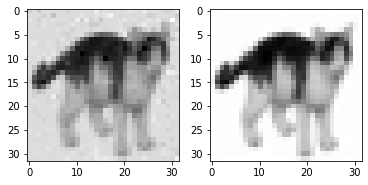

True label: 3
predicted label: 5
Time:  659.2035222053528  seconds
Initial fitness: 
 [-0.5701224071374665, -0.5607296659760846, -0.5622618271309662, -0.5650090939092541, -0.5496474491843371, -0.5571062740679019, -0.5788416913468653, -0.5678911715783334, -0.5660086139611475, -0.5567920117757111, -0.5590901654580749, -0.5737860643640582, -0.5684057919591304, -0.5700548165055962, -0.581226692442051, -0.5687673270951037, -0.5767028635100778, -0.549805153126246, -0.5643321469345897, -0.5526946946559436, -0.5516307856064508, -0.547042497667561, -0.5515833658742125, -0.5581462487596756, -0.5728743763714937, -0.5701814061874927, -0.5671125497545059, -0.569688551547325, -0.5605036367092523, -0.5421404937523345, -0.5628257276732934, -0.567425251689605, -0.5727705186929257, -0.557771838238803, -0.5690313588553331, -0.5722172814869888, -0.5484730699310179, -0.5665670694510051, -0.5632699563718134, -0.5385014315678276, -0.5704842624632299, -0.5663406140208141, -0.5801843051454558, -0.5597474501375

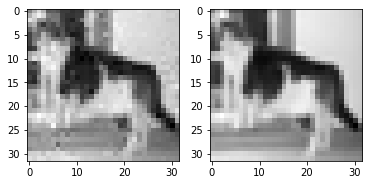

True label: 3
predicted label: 7
Time:  661.6549179553986  seconds
Initial fitness: 
 [0.7156327698199516, 0.6888405230870462, 0.6158191877777102, 0.7307843151732225, 0.6836770185867753, 0.7153278106473662, 0.6391972709980289, 0.7526283267659061, 0.5919489697411802, 0.6593907177074293, 0.6971085409679855, 0.6229472046812714, 0.669760828746111, 0.6870270783703875, 0.7176522636727594, 0.5091819052524389, 0.6767676364575183, 0.5626466104676697, 0.6363148289357912, 0.6000764753566071, 0.6368981272040594, 0.6888323598748314, 0.674336952923055, 0.6830833057973111, 0.7199021614997898, 0.6802291576007589, 0.7868166957357695, 0.7526780348376382, 0.527930351354666, 0.7131206220229497, 0.5931513839724353, 0.6272010940860204, 0.667357985453702, 0.6684149613432753, 0.6925630347010838, 0.6505875230751759, 0.6713587522741775, 0.7384459763125452, 0.5340412788890222, 0.5490976510821538, 0.6997068442075987, 0.3881335988225687, 0.6985124238298921, 0.7164835128791451, 0.596269762486445, 0.6219788742842836

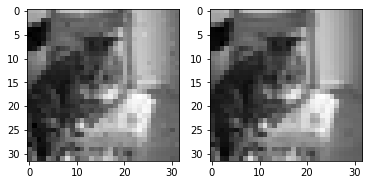

True label: 3
predicted label: 2
Time:  211.57046556472778  seconds
Initial fitness: 
 [-0.32815436575226165, -0.15661067339456133, -0.22216623233957383, -0.2695620953151846, -0.2612531486145725, -0.21572355528962603, -0.20603797554111586, -0.27451806254872213, -0.21462221355934308, -0.16692028241313323, -0.1646837189019752, -0.28988142336345424, -0.13178890997186252, -0.25309431103659397, -0.23802788437148512, -0.25454897467832754, -0.3389818268198943, -0.20026775976709182, -0.22756061633261848, -0.26408172649069667, -0.27929036529584694, -0.3531661575852122, -0.27931339380769227, -0.2428627784627414, -0.2172089148868512, -0.2884504966958451, -0.22700815361385418, -0.3330009335433137, -0.2839503041144278, -0.16348659158432063, -0.25507177032757644, -0.2852808473405625, -0.22939067523106038, -0.23546437157799208, -0.3336125891363564, -0.2761725056197132, -0.2153724057507642, -0.23188596116774737, -0.25109186662133653, -0.26676787510839595, -0.2795640682400383, -0.2757774830901675, -0.2

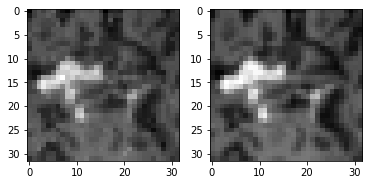

True label: 3
predicted label: 6
Time:  212.6217110157013  seconds
Initial fitness: 
 [-0.5850973760823599, -0.5830026569796251, -0.583098833269112, -0.5901174264065404, -0.5808387316474444, -0.5822975065825888, -0.5870762684247927, -0.5827620031820043, -0.5892007108067555, -0.583712183033086, -0.584081563495549, -0.5878868000318291, -0.5815511009920824, -0.5910179426350015, -0.5836109904675781, -0.5850475246294984, -0.5847835120637528, -0.5849719964967952, -0.5828274547433479, -0.583586529977633, -0.5801027195878405, -0.5886545953225226, -0.5852109050880766, -0.573593456411656, -0.5942354528136082, -0.5850772707481039, -0.5841427233143003, -0.586322969235782, -0.5872936261946188, -0.5867849047376413, -0.5886791955738445, -0.5753394961465638, -0.5781310897215131, -0.5839127892419611, -0.5866245728546534, -0.5883815586768647, -0.5696293208540781, -0.5794623280857932, -0.5791795751041644, -0.5836353198613509, -0.5915114101003403, -0.5844024961787464, -0.5830866164537963, -0.5881147958863

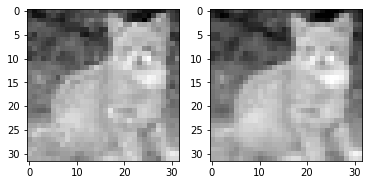

True label: 3
predicted label: 5
Time:  473.10258769989014  seconds
Initial fitness: 
 [-0.31675647730572265, -0.3858051671046171, -0.33962585172921256, -0.32838751117568843, -0.2686225229425864, -0.17665596215826496, -0.3382034211707261, -0.29177067844280613, -0.43122593014994803, 0.007210138352738038, -0.3610525178620309, -0.41736220983908645, -0.30880619205936266, -0.3454812905107036, -0.18278177625570702, -0.3859765009872607, -0.304479159926753, -0.32816339964121505, -0.38999686559897795, -0.18379753134489163, -0.38316388345388175, -0.3632539733097804, -0.3184545226236478, -0.25024607788716124, -0.3569751817760962, -0.15124471388728805, -0.339664401099366, -0.3183861708757667, -0.3991299697154521, -0.40647386376343697, -0.2634767309542091, -0.15991503293177944, -0.3840644614916615, -0.3027624019787398, -0.3400681850670482, -0.1283542837273073, -0.10666800577026411, -0.34400608556824, -0.23493261127532283, -0.43313053739250484, -0.3493516589954655, -0.39499749622215613, -0.396810959

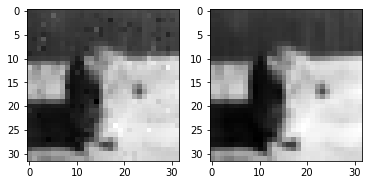

True label: 3
predicted label: 7
Time:  230.51135802268982  seconds
Initial fitness: 
 [-0.5719766579727756, -0.5879635523042621, -0.56784640703657, -0.5812876993298229, -0.5749341244650562, -0.5847227931289452, -0.5854515891916048, -0.5869328626599444, -0.5741042068101665, -0.5750528251934365, -0.5880301107129929, -0.5831417566863966, -0.5812906000129437, -0.5786419806236432, -0.5875389007862998, -0.5541539479115262, -0.576010685099527, -0.5880669954970672, -0.5846221235822882, -0.5885948671308704, -0.5829277378602133, -0.5852153244373841, -0.5843635141946089, -0.5809693580731579, -0.583446514722026, -0.5711320005628202, -0.5861685764402614, -0.5901731275379474, -0.5878952745031047, -0.5835543385548578, -0.5843582472047472, -0.5816509632709115, -0.5922376419175891, -0.5763009557234953, -0.5867354495647936, -0.5865330616936505, -0.5771165679176061, -0.5713480200906074, -0.5806833028198127, -0.5803521453040288, -0.5905949877201404, -0.5825272550496314, -0.5842174466699362, -0.5794007071

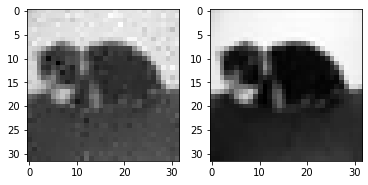

True label: 3
predicted label: 5
Time:  405.48027324676514  seconds
Initial fitness: 
 [-0.5614036800385036, -0.5166515914932425, -0.5447671266499047, -0.5602459901664953, -0.5598543008987746, -0.5577785689875342, -0.5615351434767395, -0.544225356929636, -0.5303855520977, -0.5377592528198131, -0.5419994629935015, -0.5480294840301235, -0.5521299819460193, -0.5342013404524238, -0.5487596878633071, -0.53978486079695, -0.5484582909774438, -0.5378920815542403, -0.5539942320405216, -0.5461160000789916, -0.5612470036477701, -0.5575881355158284, -0.5487553148305591, -0.551462846554946, -0.530334797234995, -0.5269407149377335, -0.524034127396844, -0.548281717930792, -0.5347802844540992, -0.5393340668467883, -0.546614458817726, -0.5421541014590588, -0.5541050606517878, -0.544683750953082, -0.5509319548375222, -0.5472710421076525, -0.5522532615073055, -0.5283586044220177, -0.558879489250238, -0.5493364372597663, -0.5408864975204415, -0.5521526427015603, -0.5495573041750328, -0.5448912896486646, -

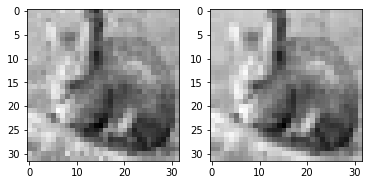

True label: 3
predicted label: 2
Time:  361.38716673851013  seconds
Initial fitness: 
 [-0.5091609883459716, -0.5342659341572203, -0.4728764077576562, -0.5285034870538939, -0.5220606158864601, -0.5227103946050384, -0.5411492258904368, -0.5242353986663522, -0.5259566986291029, -0.5355918791471797, -0.5024498164723488, -0.5017802534819659, -0.5203559665710393, -0.5334348508430642, -0.5086945803399157, -0.5010250605736488, -0.5121768208325632, -0.4862178023813465, -0.47979136791924015, -0.513561956853334, -0.5313943117935418, -0.5151416527272265, -0.5143605108646129, -0.5127063689338653, -0.5117434935871592, -0.4811427525808089, -0.49251100479866844, -0.5478284089557506, -0.5351526780077801, -0.5165048641764212, -0.519628892188936, -0.5078467882736862, -0.499483132991398, -0.5051752543696446, -0.5226160899637067, -0.5256530413435656, -0.500995131125537, -0.48589624052726044, -0.4822008390925162, -0.5380866842837482, -0.5277674913728971, -0.5101698041156725, -0.5120416871629037, -0.5088815

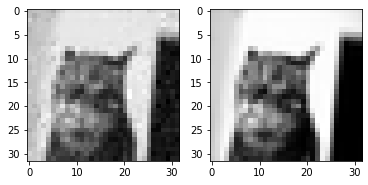

True label: 3
predicted label: 2
Time:  646.8252527713776  seconds
Initial fitness: 
 [0.6318450232962858, 0.6410216511990434, 0.5935665289533827, 0.7332768267366296, 0.539226745913948, 0.6658664259827123, 0.7189764489044286, 0.6933390320396824, 0.6326137862388898, 0.7671184950753517, 0.6636208517316396, 0.733256595413083, 0.6681159716347886, 0.7354027272106458, 0.7158613099426687, 0.5916168604719534, 0.60698234548432, 0.6928771377381379, 0.7411673524797552, 0.7152721368890039, 0.6784310505301536, 0.6774220454572221, 0.5910066350759077, 0.6135084997773701, 0.8475433496185287, 0.5561349843016866, 0.7069507061149839, 0.5867613195782679, 0.6628507125747689, 0.6863001551670398, 0.7721341854626421, 0.8144448954727226, 0.5989079785730341, 0.7263587614111209, 0.6248937877104561, 0.6250899366914205, 0.7524202640050637, 0.7160205529882173, 0.6933835076355801, 0.6039284277265086, 0.72671736187572, 0.7077090414879826, 0.6133487817074379, 0.5813690858948396, 0.6765573268986249, 0.6339970491806355,

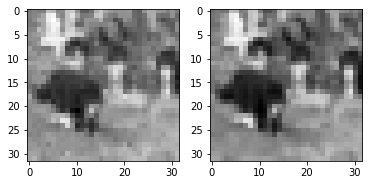

True label: 3
predicted label: 2
Time:  257.8335564136505  seconds
Initial fitness: 
 [0.40542569155698005, 0.3114928829749099, 0.375279561278047, 0.4101633422581332, 0.4021153150629947, 0.3162456996714943, 0.3109952588542942, 0.3752841991208097, 0.38031910550377346, 0.3137914383033246, 0.35018640874106033, 0.15492042049330307, 0.25118858885852924, 0.5148681280420693, 0.29051937904599273, 0.3339497187680396, 0.26234030999009206, 0.19456320586732648, 0.39676528003460243, 0.27254401102683956, 0.18982715853835022, 0.27037395601868, 0.1964937435302184, 0.3407202590622356, 0.5064546207199512, 0.3793126247871734, 0.4411349273486148, 0.2513347261300684, 0.21144615015401325, 0.3166910394784569, 0.2250611882863432, 0.4289332667596585, 0.16131905635117538, 0.3392572366909316, 0.32763590680535193, 0.3629528978262457, 0.49760621447621084, 0.2874067040975893, 0.40301540954406245, 0.29236590893720876, 0.28829965739282687, 0.35281799029216987, 0.3276367411351353, 0.5119699714935918, 0.257187114166954

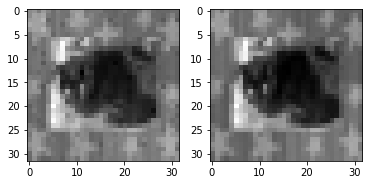

True label: 3
predicted label: 5
Time:  217.22053050994873  seconds
Initial fitness: 
 [-0.6001614913528409, -0.6005641004024889, -0.6001998236793689, -0.6003595538326789, -0.6002805597854955, -0.6001895451343283, -0.6000420201018601, -0.6001194443319949, -0.600109892014616, -0.6002311129378103, -0.6002570187597294, -0.6001930748444267, -0.6002388177808369, -0.600155671722943, -0.6001966577850159, -0.6002520051502116, -0.60042319641722, -0.6009391559948861, -0.600767810028638, -0.600044712425467, -0.6001651871943892, -0.6000385525330478, -0.6001791894407559, -0.6001363463096445, -0.6000673063561064, -0.6000294834772849, -0.6001260249091829, -0.6003660186841722, -0.600068562626832, -0.6006271262350151, -0.6002644387023917, -0.6003091290125884, -0.600092890513714, -0.6000913918889661, -0.6002542236195016, -0.6000543305404371, -0.6001258121131403, -0.6003386629236669, -0.6002098384527099, -0.6003668472273725, -0.600110880771808, -0.5999894057963862, -0.6003573001608837, -0.600153280230548

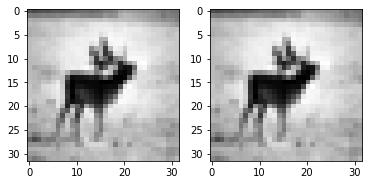

True label: 4
predicted label: 4
Time:  157.749502658844  seconds
Initial fitness: 
 [0.7806729633420451, 0.6419357369424135, 0.6506855251090138, 0.6510808701723404, 0.5610155478036498, 0.338268586162234, 0.7104156462311543, 0.6394184671881358, 0.6713770633311434, 0.7123194089994687, 0.7250923557137826, 0.7375621209119706, 0.530288485565437, 0.7378186556377961, 0.5375553036287192, 0.6877518980225862, 0.6353516544146298, 0.6452374363981463, 0.47582012966762166, 0.57088888158785, 0.6252265823003463, 0.6343690682364866, 0.573663522785145, 0.6117511334120123, 0.6547110752370847, 0.622050254719484, 0.6204965061343155, 0.6863232134096232, 0.7017171670006884, 0.3686928720423168, 0.6919075559276981, 0.5871721207081112, 0.5615097430469449, 0.601161048884121, 0.7192799253942755, 0.5936573414274481, 0.6755038830858257, 0.797057775912348, 0.43073012387800613, 0.640396290143837, 0.6827460423591925, 0.6108470438560423, 0.7400122279952721, 0.5067750769049916, 0.5892101877432274, 0.6535777820459878, 0

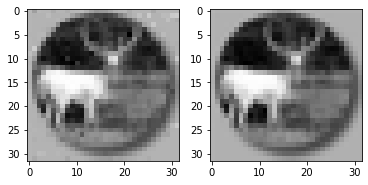

True label: 4
predicted label: 1
Time:  297.9099826812744  seconds
Initial fitness: 
 [-0.4764630841608203, -0.46347945884233666, -0.46245434285426845, -0.45442875566315544, -0.4614245273797579, -0.4316814318028242, -0.3474113991445099, -0.4683093517113676, -0.462674153682175, -0.40872809015324585, -0.5184255760089806, -0.36506019686847446, -0.4673276923578998, -0.34124777839890635, -0.47856528389238795, -0.467356790511937, -0.46724409368845976, -0.5422366217889709, -0.48011122374334636, -0.48762175081339604, -0.46303657286593136, -0.418267316262527, -0.43411408291841613, -0.4705556605537635, -0.4325730619104541, -0.4303667206521498, -0.4241193645273315, -0.4003669054379476, -0.4561742417997262, -0.46182173528047493, -0.47879774479680837, -0.45771092988068757, -0.36487615029681975, -0.48330838989099517, -0.5437813617006851, -0.4568404335840558, -0.4422860322261002, -0.4724149742489535, -0.44861814225628804, -0.491536781319329, -0.44254437459949675, -0.4094571569635206, -0.4546664069950

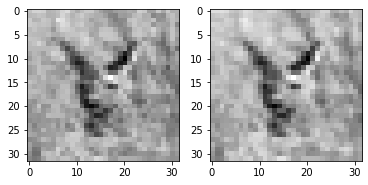

True label: 4
predicted label: 2
Time:  319.4809513092041  seconds
Initial fitness: 
 [-0.5923422849152001, -0.5967697636673321, -0.5936580596011038, -0.5969948791739659, -0.5962800746713868, -0.5937568618567616, -0.5949648977667357, -0.5946450535072063, -0.591213297913834, -0.5851078713342961, -0.5945859564047931, -0.5915417946129768, -0.5952067463740213, -0.5957862675057524, -0.5926302000801864, -0.5966308259223, -0.5921574917243182, -0.5922033392253783, -0.5921151660856929, -0.5953798165787968, -0.5923572781847121, -0.5969061838525097, -0.595734316156955, -0.5950635950657522, -0.5902054703430951, -0.5958570616956363, -0.5898010515201426, -0.5934427529164197, -0.5928677078415427, -0.5960425543017913, -0.5960043660408954, -0.5878054224067998, -0.5934519929213473, -0.5904668958988877, -0.587300504252335, -0.5927437944774294, -0.5930002490245243, -0.594975805873674, -0.5815242651569482, -0.5959289586076371, -0.5939404963673077, -0.5943949480387729, -0.5962847629873218, -0.59619385628668

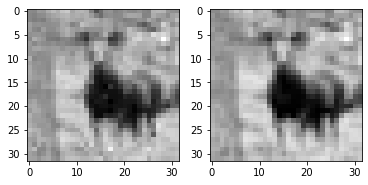

True label: 4
predicted label: 7
Time:  433.4080147743225  seconds
Initial fitness: 
 [-0.31091668194886235, -0.47512767334786893, -0.49011244378478813, -0.5786637943966413, -0.5499965725387529, -0.5228730357839375, -0.4853558913405449, -0.524160306350707, -0.39767626927245214, -0.5272931495053989, -0.1208341854104717, -0.5786644634600295, -0.5016717211360455, -0.42263724366483546, -0.5022078658644789, -0.5641473732825332, -0.5552923974307105, -0.5095841737836543, -0.5431340806644258, -0.547947927768677, -0.5237245047902328, -0.5332384495076847, -0.5209219888148457, -0.5137047842925297, -0.5664478713660831, -0.5129557258652134, -0.548240497329474, -0.44503649360994346, -0.5642494046498376, -0.3866905050300331, -0.3386747136612812, -0.4028270654480066, -0.4318389824963292, -0.5730535228437015, -0.564408204961179, -0.5202966402890673, -0.4428768541287271, -0.545402679203491, -0.49211730741216614, -0.5332296598761198, -0.3010307948732167, -0.3486886422332597, -0.5168372508885298, -0.31859

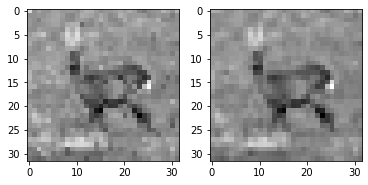

True label: 4
predicted label: 2
Time:  224.727778673172  seconds
Initial fitness: 
 [-0.5779317443741364, -0.5942066231215071, -0.596489482591983, -0.5944460410561001, -0.5925517517581117, -0.5952703611074089, -0.5947861066096176, -0.5951255447961634, -0.595582350164236, -0.5965620866112837, -0.5952611460198742, -0.5947505556469522, -0.5911130227939922, -0.5909684546971163, -0.5977280669029941, -0.5938423068986773, -0.58865041931747, -0.5966050758038646, -0.590243515658115, -0.5920348016671056, -0.5916363410773411, -0.5933673904350416, -0.5963689157670026, -0.5922520635381259, -0.5948772130566389, -0.5928049101521398, -0.5967444029017193, -0.5964493555935986, -0.5948955582077675, -0.5976375918863033, -0.5971148099429685, -0.5848744536021189, -0.5831000033578627, -0.594787697926377, -0.5939012448373568, -0.5889030230685611, -0.5904852885504096, -0.5952284945909644, -0.5938412881340742, -0.5961908580110574, -0.5937800848963671, -0.5962603932290209, -0.5920102046731825, -0.58591483544291

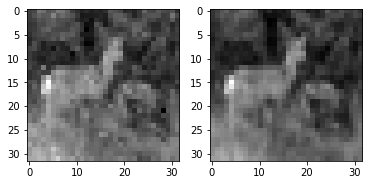

True label: 4
predicted label: 2
Time:  327.74784088134766  seconds
Initial fitness: 
 [0.027515332854036734, 0.4163201734220722, 0.33948038151279397, 0.47611129699883636, 0.2543461163562388, 0.3400307476447232, 0.17244442834847068, 0.40247317832496543, 0.29254812637713945, 0.37692505298624895, 0.15961672704212523, 0.5319018976250738, 0.10194684642432167, 0.2632514348586037, 0.19503757692940266, 0.33937509993793175, 0.6389723759717079, 0.4071980241667064, 0.6035542166798346, 0.38969107725835045, 0.30814298214522495, 0.38599698454254344, 0.22866108663491394, 0.3574067746384029, 0.39407400346141075, 0.014089652876697306, 0.3634380856770895, 0.25860868140158055, -0.04338366955552786, 0.43886998289268586, 0.4507569158320397, 0.2418853543363474, -0.003473927227277601, 0.18513281298106185, 0.4624663808566415, -0.03655528243806383, 0.18361878652840408, 0.266463401145978, 0.2960992009564225, 0.33025082115068727, 0.417162404067015, 0.19889148082165756, 0.19705615408725546, 0.5758106898514967, 0

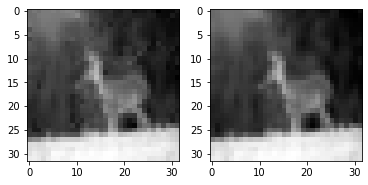

True label: 4
predicted label: 3
Time:  211.16384077072144  seconds
Initial fitness: 
 [0.9952242809511395, 0.9949415532172886, 0.9962097667157539, 0.9955733253666799, 0.995364410129941, 0.9967943380929076, 0.9937846678557087, 0.9962264557495711, 0.9940526008615563, 0.996224792648902, 0.9934711663416833, 0.9944405134524661, 0.9970912216143801, 0.9947919519465033, 0.9940823923548, 0.9914465005236028, 0.9954485321254585, 0.997292847175126, 0.993107709427988, 0.9956109016704435, 0.9796693084027727, 0.9975609744753072, 0.9927263083817839, 0.9973927702823467, 0.9962790201791866, 0.9968890660361363, 0.9956774360138353, 0.9964223101018723, 0.9892639144487456, 0.9944628544664974, 0.9948953695292945, 0.9892368512058763, 0.9955652155921715, 0.9978690996994487, 0.996580372694686, 0.9956415008062376, 0.9958387792902714, 0.9946703292695365, 0.995068923388987, 0.9951468910875102, 0.9963966822731968, 0.9968545818823131, 0.9963614880227967, 0.9927361168964178, 0.9937096153012993, 0.9906381604232928, 0

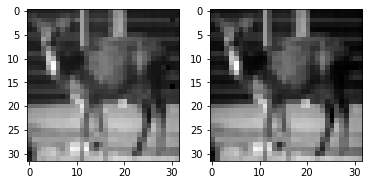

True label: 4
predicted label: 7
Time:  135.04084873199463  seconds
Initial fitness: 
 [-0.5287915428005667, -0.558150507990064, -0.5568796239877177, -0.5631649783746087, -0.5328952123104487, -0.5586897951834192, -0.5651328840735256, -0.5639097531010342, -0.5147028535641185, -0.5679067729983593, -0.544353103869285, -0.5622275606733945, -0.5554717338336576, -0.5574735399134746, -0.5634158680154515, -0.5637131886687393, -0.5586756334304317, -0.5642251614406217, -0.5738355133297074, -0.5650749950013116, -0.5804760183604423, -0.5765315773559196, -0.5626604802049145, -0.5738728291122408, -0.5702527985044069, -0.5530518571126708, -0.576326522679097, -0.5653241056448501, -0.5632350247812643, -0.5767601437207835, -0.5593439167687355, -0.5682778850702543, -0.563997919104623, -0.5746151783143985, -0.558592328013971, -0.55462070492052, -0.5697393746428254, -0.5731403478982394, -0.560143752615426, -0.5740630399075347, -0.5691907438394188, -0.5448107206913589, -0.5726370339976924, -0.55959080631483

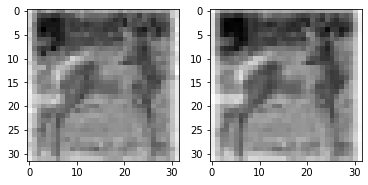

True label: 4
predicted label: 7
Time:  558.2430262565613  seconds
Initial fitness: 
 [-0.592037065502149, -0.5776492112145146, -0.5880784680137943, -0.5903083464063011, -0.5921948132139608, -0.5938288142142958, -0.5939525983133895, -0.5970526344972565, -0.5928663757712813, -0.5913602339637332, -0.5954084089515195, -0.5930324702849713, -0.590730178292185, -0.5888854782149371, -0.5920668619263278, -0.5929000484559112, -0.5934743429733511, -0.5950452836574474, -0.5948095603842608, -0.5818363117953864, -0.5939459915651522, -0.5943144193190054, -0.5900213811172736, -0.593094650815577, -0.5925372106483078, -0.5922418438178005, -0.5925873518787329, -0.5903945011281488, -0.5923033739626268, -0.593087343165865, -0.589324684002597, -0.593390642828503, -0.5952211920436755, -0.5944437328869455, -0.5943894821626072, -0.5929409541220033, -0.5922876903211873, -0.5939341143023712, -0.5905132638394269, -0.5952128751911427, -0.5948095738249826, -0.5949745044915713, -0.5948126919803967, -0.5930655977456

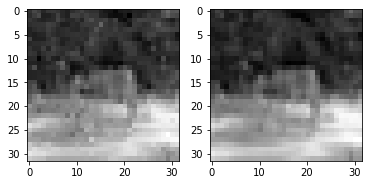

True label: 4
predicted label: 7
Time:  215.75353860855103  seconds
Initial fitness: 
 [0.05158086823182423, -0.03825954328578801, -0.08472206735552446, -0.020594543197890253, 0.05998301806389478, -0.12045302264953661, 0.12994430965590392, -0.09692139106622191, -0.05403640390198203, -0.11725149555562642, -0.08634554533390609, 0.003985508575067492, -0.2769044731401792, -0.0948178366357256, -0.2947807638564903, -0.056918946785467966, 0.026147310104884774, 0.0422938433583884, -0.04742375504682411, -0.2491417716172093, -0.11175174827091475, 0.0784146748358077, -0.08590668964582382, -0.31273778286013076, -0.09360865104661387, -0.16341140926457504, 0.046480655695185474, 0.0069035200597486746, -0.056096900634862334, -0.10470159457950454, -0.05041972356907051, -0.14824447927669593, -0.06419938110829215, 0.12119099255568061, 0.027392461369534743, -0.1834022888802787, -0.14612627954663246, 0.08756049110192507, -0.07512582852082028, -0.07245398560298374, -0.08877318247308089, -0.00411491921160825

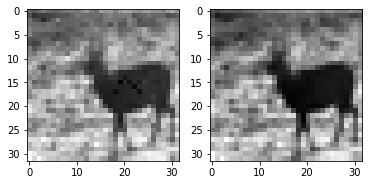

True label: 4
predicted label: 2
Time:  181.93656730651855  seconds
Initial fitness: 
 [-0.5955536123467071, -0.59509653192673, -0.5944956671868333, -0.596241157364551, -0.5981413112363804, -0.5967465288530539, -0.5913142143578837, -0.5949831325503404, -0.5943392650290377, -0.5941401712901111, -0.5959996625389785, -0.5948091090524634, -0.5966284190508969, -0.597603228524171, -0.5928887027801488, -0.5957154269791274, -0.5935967849005176, -0.5930509184619596, -0.592573209506557, -0.5932151024228177, -0.5958036457686078, -0.5949006578830115, -0.5981578549246562, -0.5911832704956033, -0.595130508601566, -0.5944489182081683, -0.5949770794170417, -0.5939068378901828, -0.5944493209915188, -0.5946796707957491, -0.5941047806851147, -0.5941566865281075, -0.5946575975361398, -0.5952272353102949, -0.5917313880923823, -0.5924693827134768, -0.5963108961461059, -0.5955781223107657, -0.5934001267271247, -0.5952970677889394, -0.5934489562491759, -0.5968453446163353, -0.5959001749121376, -0.597047220934

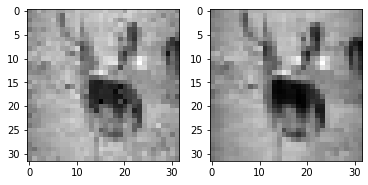

True label: 4
predicted label: 2
Time:  347.068740606308  seconds
Initial fitness: 
 [0.3658522385899122, 0.2830803662969064, 0.4695064632577807, 0.34187086401307143, 0.3664762108233585, 0.18127159726967595, 0.4449487715641222, 0.4087766515226403, 0.5034797131777162, 0.4274915750532834, 0.20857140491045886, 0.3924782713324604, 0.4443393299609464, 0.3896495045194459, 0.4332594350244961, 0.41880338524442384, 0.414913005538863, 0.478093889828754, 0.3872880898687661, 0.4659116069094798, 0.3578581771140324, 0.43877994624002215, 0.4026600012535413, 0.3277818768949797, 0.4416782294918944, 0.30316008534910793, 0.387305007403232, 0.38530581426278543, 0.3909335428697013, 0.30948437366832127, 0.4185719185445336, 0.3341707833771546, 0.43448896227885314, 0.5467604174420577, 0.3893018105925039, 0.3058457682953388, 0.3972212525298616, 0.3482021872303569, 0.4437901843189084, 0.30943419973165054, 0.2922809842089318, 0.3618582408387775, 0.4718630257625015, 0.4434480192440061, 0.5695231557091143, 0.36547

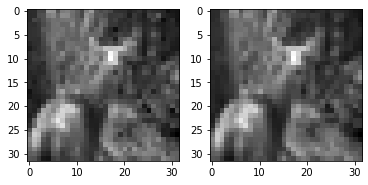

True label: 4
predicted label: 2
Time:  198.99598503112793  seconds
Initial fitness: 
 [-0.298652431837988, -0.17443612901708125, -0.19638766825967874, -0.254190702590659, -0.24939270493715798, 0.06266252694136018, -0.2504066992843943, -0.3010278122957126, -0.23633890789632706, -0.15524618054591555, -0.244488743049587, -0.3497446481993783, 0.046056964878343265, -0.4987865742762354, 0.08647138673102919, 0.15347132479183873, -0.21129295475674878, -0.26358398922769777, -0.1750324967453556, -0.256943903720718, -0.2903054079302473, -0.3494731515591738, -0.2486605589596948, -0.2880465366459412, -0.08023894611353644, -0.1528087894016172, -0.25026582491555294, -0.40443687543445145, -0.31099380103970087, -0.06397272186238492, -0.12290954575153373, 0.011032645217574744, -0.3740277185020421, -0.33633448284785417, -0.30631624067865004, -0.19052363324716481, -0.40450429678943356, -0.5011256877297698, -0.2845389856699639, -0.2089530759490506, -0.233957878585213, -0.33500619227971307, -0.505623381646

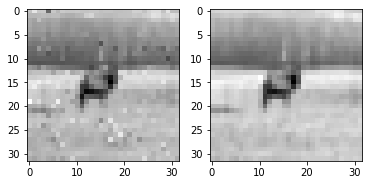

True label: 4
predicted label: 2
Time:  179.87984943389893  seconds
Initial fitness: 
 [-0.32621706909392667, -0.0910207545426184, -0.18753241394853665, 0.31625238913066067, -0.3087170399612338, 0.0010876654796171947, 0.32490222085253817, 0.04074175150296114, 0.05099496101377368, 0.22759778497805178, -0.08479797314741405, -0.23897493713569723, -0.21741837634386604, -0.06706049195317204, -0.2745327537426724, -0.18470856800119323, 0.0005369380396782197, 0.09647393153327709, -0.03578713182537102, -0.178631472075238, -0.23668732935110154, -0.2842408990612292, -0.1009397449053156, -0.06695329786104762, -0.18712589653585093, -0.08637406365394976, -0.05860504809111772, -0.13779606961906563, -0.24204785002458074, -0.2372438742726109, -0.18290408444716372, -0.3729925070957155, -0.14190980589838983, -0.2531466654422896, -0.15114074515148337, -0.12940175059270126, -0.1576921194992643, -0.09802986237706707, -0.07751948080942886, -0.15321613644613818, 0.07977476931414804, -0.03816871096546989, -0.3

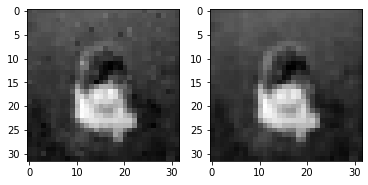

True label: 5
predicted label: 3
Time:  199.13969779014587  seconds
Initial fitness: 
 [-0.5865181483064568, -0.5912118321504751, -0.5815164112451469, -0.5912003288082316, -0.581001275463906, -0.5865865548218532, -0.5862385984556947, -0.5827800246123356, -0.5904947648269552, -0.582249006437408, -0.5871528200609315, -0.5889467597034681, -0.5844938223773511, -0.5865336703277874, -0.5846767476787655, -0.5871850285071686, -0.5868451146135581, -0.5773021804584441, -0.5833828229401645, -0.5793725154678038, -0.5858297558215427, -0.588874253489603, -0.5765525056703953, -0.5827261497314473, -0.5768005346745315, -0.5834310922851036, -0.5804635976225306, -0.5891466871802101, -0.5914914404575661, -0.5822688171635981, -0.5869969700415802, -0.5826593827691984, -0.583193027676922, -0.5820604321927542, -0.5874936330490843, -0.5887252295557788, -0.5805086939752111, -0.5818494464253221, -0.5822151637131114, -0.5805832213527542, -0.5786903736159819, -0.5876685703430122, -0.5896839657359697, -0.5843270780

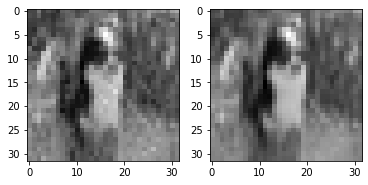

True label: 5
predicted label: 2
Time:  327.13240575790405  seconds
Initial fitness: 
 [-0.5282173684813045, -0.4255155846398558, -0.28200484388500613, -0.4497178030976485, -0.3740837419601746, -0.36718620508762667, -0.29301095523433923, -0.5045370448254529, -0.4091317105444323, -0.5068435460395501, -0.48740573929988196, -0.408107296765966, -0.5603734002135622, -0.44722284990107286, -0.4225682146563827, -0.4621499631738385, -0.45133630553096155, -0.33406631219938654, -0.4465838157486376, -0.45543644304257636, -0.5211784760371719, -0.4111765878157946, -0.4579718529379805, -0.42781206476664757, -0.28085033624578826, -0.4534660091572116, -0.5234256633939929, -0.4291253918574933, -0.42572334238121534, -0.4526267506996573, -0.48329038101501476, -0.4858858786721999, -0.4470984153895142, -0.42486238241559854, -0.49276590398895803, -0.40108360775190677, -0.5148899937184196, -0.44688211223909247, -0.34136588219555186, -0.49921109194362223, -0.3068586626105351, -0.45635307812255343, -0.463912057

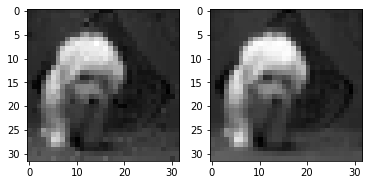

True label: 5
predicted label: 2
Time:  188.14804434776306  seconds
Initial fitness: 
 [-0.58104668042668, -0.5863206163813266, -0.5663842111798295, -0.5710242881307157, -0.5808995490097819, -0.5877130909905808, -0.5843720373947042, -0.5860007720802839, -0.5882070410117571, -0.5756439281787344, -0.5853621133589253, -0.586463403594806, -0.5908003339348871, -0.5810817412326921, -0.5863131444071461, -0.5798009153836299, -0.5827169739837704, -0.587053565652387, -0.5832780199177471, -0.5825422720178757, -0.5845210068610941, -0.579681442045547, -0.5853219156183843, -0.5802849939441204, -0.5721219606858828, -0.5846970413042645, -0.57460099074102, -0.5824705067934761, -0.5785110295563246, -0.5702050008783223, -0.5883192291388718, -0.5834035291439823, -0.5695380890352529, -0.586951227768072, -0.5878559762810367, -0.58823637459185, -0.5628595336277248, -0.5743786353605885, -0.5842337770121998, -0.5806679112186917, -0.5864672119102818, -0.5730216263835659, -0.5822186102451152, -0.5825913255291589

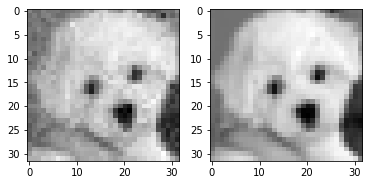

True label: 5
predicted label: 3
Time:  974.9589607715607  seconds
Initial fitness: 
 [0.06230964421156027, 0.0648847457134539, 0.08580830090637923, 0.23693690684985527, 0.09916489812300523, 0.23466414241303202, 0.06210078424964485, 0.1629332639898878, 0.21651385855019245, -0.024772395209779807, 0.3389024319181818, 0.06640614399967051, 0.3893796761550102, 0.09370818477938235, -0.05964926466856524, 0.010558670612537152, -0.03225523770724445, 0.13980328137965684, 0.2829063313291479, 0.15406527353820743, -0.04074851029941218, 0.18873370670989842, 0.3272385214919276, 0.06557908245324023, 0.08599674320921452, -0.09621091759113165, 0.1418627579069519, 0.14369751164007516, 0.13350074344760932, 0.41451731288405125, -0.045326596647038614, 0.23561129575808376, 0.035949937794337194, 0.05389432019209611, 0.07263235632860687, 0.0994182256141042, 0.06485086363566056, 0.17926280587767984, 0.48603395578734165, -0.039420784419718746, 0.19394989938447266, 0.23944533566796392, 0.07010970786932957, -0.057

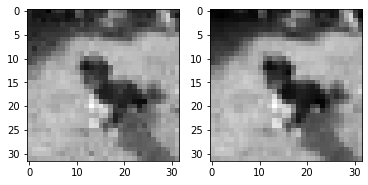

True label: 5
predicted label: 2
Time:  274.1568431854248  seconds
Initial fitness: 
 [-0.12529851135556822, -0.19320892762458586, -0.09952227336493732, -0.22199184519906245, -0.0418803754569366, -0.050891948551714805, -0.1465052136006439, -0.1634597750760512, -0.0746562391999778, -0.39398604191195746, -0.24389665281070627, -0.046277927454832, -0.13494905121335368, -0.12926849259769937, -0.18581320274508958, -0.0919280339992731, -0.10422538295314956, -0.11638611681570424, -0.18775138106734224, -0.11086298749751214, -0.06124943694826085, 0.45870892151074805, 0.016814825714452614, -0.12660745015595273, -0.18745008802080163, -0.11199767932749821, -0.02682463820915912, -0.0108131973919596, -0.270924512434831, -0.11221046446940425, -0.07484896019961129, 0.038410160249103875, -0.08246768795576348, -0.19609386974107582, -0.12353243346900145, -0.02859623752624524, -0.12805282583115246, -0.12159747121754957, -0.019020527344141697, 0.04733228011271509, -0.16715705584726204, 0.2209807389804061, -

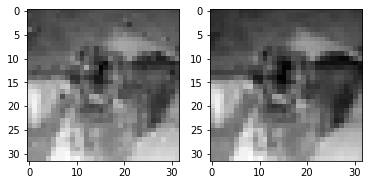

True label: 5
predicted label: 6
Time:  166.32911324501038  seconds
Initial fitness: 
 [-0.6002709035536873, -0.5988097213034895, -0.5990316589998836, -0.6008538135425701, -0.6003386099473373, -0.5995140505535476, -0.598821568365937, -0.5981860908066973, -0.5988003400378936, -0.6002132144887704, -0.5995715047398047, -0.5998147120297699, -0.6003633719478108, -0.5991374492556659, -0.6000935625884256, -0.5996914152812112, -0.5984890567913912, -0.5991655928581248, -0.5997457584892179, -0.5986860581091767, -0.5984048017791808, -0.6000953351140241, -0.5986367573467745, -0.5987732940103805, -0.6009175206657589, -0.5996013733681985, -0.5988151496203291, -0.5995802738456317, -0.5990972015173853, -0.5987941307485191, -0.5985024057075595, -0.5993101527965455, -0.5987092089992326, -0.5984344454860646, -0.5993453081553114, -0.5995213280259228, -0.5978573102998817, -0.6037569641363368, -0.5994596591350339, -0.5982748653560979, -0.599389134248913, -0.5990054008796137, -0.599469975084271, -0.599557849

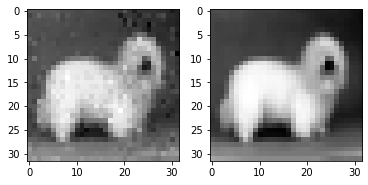

True label: 5
predicted label: 3
Time:  446.4533803462982  seconds
Initial fitness: 
 [0.7815315434866866, 0.7594037473034301, 0.7585840569038835, 0.6342587072168595, 0.709197873869938, 0.7025408719706988, 0.783255884993583, 0.7053915517358958, 0.7269178342538787, 0.7396622277218927, 0.7451707478205273, 0.744998356987041, 0.7235485119935827, 0.6999324643234245, 0.6682916052922379, 0.7242845058783398, 0.7968457776908264, 0.7188961817669564, 0.7314060863540097, 0.7008502567382945, 0.7792062623394126, 0.8245190617517468, 0.7421294539891529, 0.761645088202867, 0.7432872577201266, 0.7706409915123131, 0.7870991626872215, 0.7256481799218484, 0.6961309214849248, 0.7546630884761194, 0.7476046414745458, 0.7095830618511895, 0.7331477873715746, 0.7603097077553282, 0.7115443089641501, 0.7014604623704264, 0.6826280229150945, 0.7161907751252486, 0.720196034545398, 0.7458897774989812, 0.7235796456237789, 0.6970660006271368, 0.7274773756093486, 0.7616413369021349, 0.7668287568888444, 0.7185067224789354

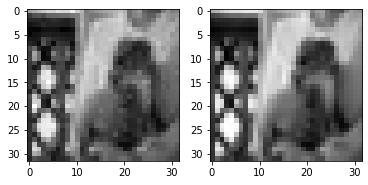

True label: 5
predicted label: 3
Time:  330.5824921131134  seconds
Initial fitness: 
 [-0.3796144229324967, -0.3797657087241547, -0.41073238612590235, -0.292782127205406, -0.3714764478320759, -0.3816131808777415, -0.22758551388449105, -0.3322685114003364, -0.3363861775445736, -0.3343601822474078, -0.3941315236413321, -0.3817431461479762, -0.39094946374216943, -0.4353040601153777, -0.4505517655648052, -0.37665820708316633, -0.2956878869040517, -0.3090988744617883, -0.33560883684028364, -0.35710779878228643, -0.370651297894133, -0.30562663466351186, -0.4240819145394467, -0.34539708165245764, -0.3606238058932534, -0.3431932441649539, -0.31250171661454507, -0.31533386837699573, -0.34158245915875274, -0.38168160673396656, -0.3990327950804955, -0.3257985322073871, -0.37620804898976423, -0.3587712796083089, -0.41725524140126174, -0.38065662863665584, -0.29886132897338635, -0.2939525666960363, -0.3380906396403105, -0.3996977837601192, -0.3212040344159651, -0.35962408873534923, -0.3036333755048

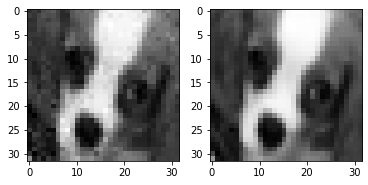

True label: 5
predicted label: 3
Time:  457.2394139766693  seconds
Initial fitness: 
 [0.15347998993475767, 0.18940046197197782, 0.15520327329659628, 0.16539534624668673, 0.21816612119708167, 0.13924179685290655, 0.32914365865237616, 0.20504665084558282, 0.16096248636516708, 0.20016491529945388, 0.10408510191428459, 0.21278994335216844, 0.09402223404692857, 0.18149383402375133, 0.12070311435879884, 0.1564153438006366, 0.1812906764122633, 0.06537016070697149, -0.017585403380177472, 0.23765027746602463, 0.07479948315104006, 0.18665684177200098, 0.19857358503106748, 0.22276801437708438, 0.12500523995867863, 0.2783126357781949, 0.221227820997665, 0.21986032154558074, 0.1833329146532782, -0.016303618675938797, 0.15998272519340248, 0.23214565797787923, 0.17329210048261576, 0.18452491490289158, 0.040223645622738946, 0.16236259941064807, 0.21552375562736453, 0.058790125739709376, 0.18057310927938575, 0.393247612048229, 0.2282547854545935, 0.14507342809585705, 0.1110449034014808, 0.155454823020

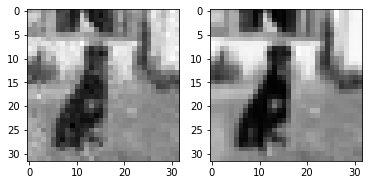

True label: 5
predicted label: 3
Time:  957.6179020404816  seconds
Initial fitness: 
 [0.39303711428187954, 0.5668884945608577, 0.4561349691144715, 0.5206650339220863, 0.4257143592077023, 0.49287249592127147, 0.6646333677637667, 0.7393504669236908, 0.6040834842169578, 0.571267690831941, 0.5873158971585428, 0.5118560325925645, 0.5147206951536218, 0.574635919337512, 0.63545842678105, 0.5545098981610551, 0.497281253007354, 0.4830740465706749, 0.5362430017396926, 0.6446732707942011, 0.40869326133365513, 0.39378644096627213, 0.48632277059714646, 0.5213179364589952, 0.5867833091105296, 0.5547437954641521, 0.5289819941622592, 0.5167052473565102, 0.6526915771355307, 0.3840258006647848, 0.8206336150315426, 0.5413696424570504, 0.5950072963123669, 0.43968050018623805, 0.5166440223436726, 0.5495720787552023, 0.617313206558415, 0.48072812428519074, 0.5025138163178967, 0.6410197635702176, 0.5933666749354749, 0.5118842542871268, 0.5863928826699618, 0.5891035857321258, 0.5785253425244785, 0.5991233133

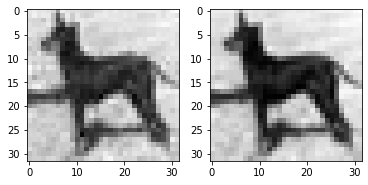

True label: 5
predicted label: 7
Time:  631.205304145813  seconds
Initial fitness: 
 [-0.6001374350220967, -0.6001109713275423, -0.6007256459679152, -0.6004232384090151, -0.6000039353295308, -0.6001284979854025, -0.6000491408868335, -0.6002032746486908, -0.600098804886603, -0.6000731723992577, -0.6002071648237896, -0.6001955194583586, -0.6005245587459291, -0.6001930270851495, -0.600172958919309, -0.6000718877846243, -0.6002609459896407, -0.6004214807842279, -0.6004375571120929, -0.6003090001925501, -0.6002735350199497, -0.6002263845771946, -0.6000770762149764, -0.600005546852993, -0.6000145366142089, -0.6002646832220123, -0.6000894106285408, -0.600146825282134, -0.6003690285826143, -0.6005161404381603, -0.6001537495545753, -0.6001123448009236, -0.6002618572497223, -0.6002497698532114, -0.6003278692424745, -0.6001129220884326, -0.5999974110874238, -0.6002301057056074, -0.6001171305188313, -0.6004200083129518, -0.6000566790387629, -0.6000767453761003, -0.6000285578308638, -0.600101201439

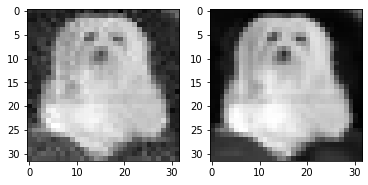

True label: 5
predicted label: 3
Time:  1667.6558184623718  seconds
Initial fitness: 
 [0.3476687750058295, 0.3278659808268505, 0.39576628479930687, 0.3456439203487647, 0.3426045098209016, 0.250792744526382, 0.447160761501238, 0.3386665303899671, 0.1787400699648161, 0.3390631374503565, 0.25346484730732977, 0.23560452589897576, 0.2263197743349752, 0.33295923080253453, 0.1896916203704985, 0.3772470912247782, 0.3679928489369412, 0.4094944643388141, 0.2644743086604147, 0.3501725019667544, 0.2862926126027461, 0.25510531865162384, 0.2897985984135043, 0.3285733127399323, 0.3025112327165026, 0.31449593118168606, 0.31096244330227274, 0.23016702537941358, 0.37654386992654426, 0.36471057064415857, 0.4085746127683726, 0.15969574547591786, 0.21139772890979147, 0.25510245829346134, 0.2877783823553022, 0.4164938149660226, 0.30656136093327246, 0.34655038758642503, 0.25876054856905445, 0.38285294530756964, 0.23337581498615972, 0.3477424689176767, 0.37078199149369584, 0.38773218514286656, 0.495066075253

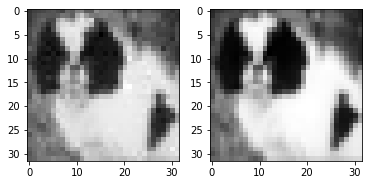

True label: 5
predicted label: 3
Time:  552.5808598995209  seconds
Initial fitness: 
 [0.40225194971279593, 0.3817210174240323, 0.3899045941859828, 0.4340459514034212, 0.3209614900115967, 0.6466110157074203, 0.645204268980859, 0.34519843003927475, 0.5489319542313001, 0.6399838725296194, 0.3443959593991778, 0.055900206791794194, 0.1891322708640447, 0.4610182964756287, 0.36031430721109375, 0.3843845042123402, 0.5798004253151473, 0.31484651451591683, 0.4846498853991857, 0.46833906685733867, 0.31557488648363696, 0.4672481709550519, 0.500399583057541, 0.40841844958610374, -0.027764432782406506, 0.58580743745781, 0.5360232925092211, 0.4891915665325341, 0.5092971600653734, 0.36651997852404156, 0.3945090106924344, 0.701220944361315, 0.41868802989714027, 0.4156631448185688, 0.5406768934105881, 0.6592212690173656, 0.406274001593935, 0.3164488375523939, 0.4167875040222251, 0.3598108796483338, 0.39908600772905717, 0.48191903298777417, 0.33710441637216704, 0.4700145186515433, 0.517705347482037, 0.4

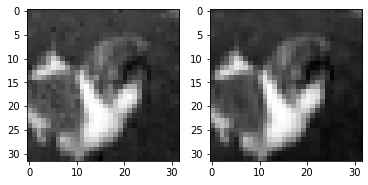

True label: 5
predicted label: 3
Time:  272.9492664337158  seconds
Initial fitness: 
 [-0.6000506844585792, -0.6004824180845877, -0.600294584817086, -0.6002870553620655, -0.6002711045764364, -0.6002507842505855, -0.6003221964591884, -0.6000573027450427, -0.6009571088620028, -0.6000304794460569, -0.6002165751718012, -0.6003763167834563, -0.6001593122290036, -0.60075412059288, -0.6005240652210533, -0.6002982902950119, -0.6000565825338264, -0.6001345103234993, -0.60023307849176, -0.6003426918587117, -0.6000710023427706, -0.6001890790322756, -0.6002428619653936, -0.6000595857700761, -0.600741111925954, -0.600898076747533, -0.6002196716247482, -0.6001543485373455, -0.6002215305059694, -0.6000867480015035, -0.6002510077612436, -0.6003264615422161, -0.6002891317470129, -0.6000561652285911, -0.6001460126402782, -0.6000589934717082, -0.6001315114020838, -0.6002448102490968, -0.6002092430023395, -0.600402328189878, -0.6002654303494454, -0.6005147013093282, -0.600056315374063, -0.6002174672695987

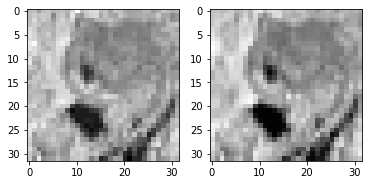

True label: 6
predicted label: 2
Time:  1109.876187801361  seconds
Initial fitness: 
 [-0.5577815365121648, -0.5478018613281332, -0.5478993467430684, -0.5264826010239381, -0.5477651455099806, -0.5716289237685417, -0.5710644734239978, -0.5317858576674553, -0.5648318544684964, -0.5741483999081226, -0.5522197691277462, -0.5538008394525202, -0.537273155986766, -0.5425249515119899, -0.5453694098420797, -0.5514969770897294, -0.5363634491506084, -0.5671881230113218, -0.5433295640310838, -0.572319767076281, -0.5067634932960015, -0.5532048852070617, -0.5235638696990859, -0.5455328771161309, -0.5293638547311302, -0.5506608504485347, -0.5587414012702536, -0.5451620801580014, -0.5507415020135984, -0.5530194561006583, -0.5430513164627514, -0.5627881626785785, -0.5559795307108653, -0.554030667246594, -0.5456585656741075, -0.5569384291608006, -0.5439443751582383, -0.5378272095112738, -0.5501061655361, -0.5786718158605015, -0.5462337532151211, -0.542552264079434, -0.5400193544056995, -0.54662506971296

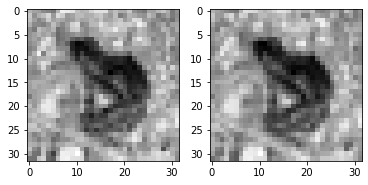

True label: 6
predicted label: 2
Time:  337.1802945137024  seconds
Initial fitness: 
 [0.5374889695948678, 0.5122058342983945, 0.5627826296109859, 0.5276532950804942, 0.5591642875563122, 0.5844858081727183, 0.648893792642269, 0.5872805752898962, 0.5392041449352503, 0.5814165012490293, 0.5589149967243344, 0.6048700833772085, 0.4641936285590269, 0.5371588348622032, 0.5147343249109922, 0.5449814843523049, 0.5432269142554579, 0.5659991423583834, 0.554615791190361, 0.525364588532304, 0.5721229980820326, 0.5471286662992708, 0.47701872456806155, 0.6292200152695102, 0.5872777729805734, 0.611337401011503, 0.657108403701559, 0.6034168793038912, 0.6683087953674798, 0.522404327540418, 0.5888515149621085, 0.6152957829316552, 0.5644440778153312, 0.5253003240364658, 0.5585129845068117, 0.46990293711493497, 0.5588699559768912, 0.5286536707876882, 0.5171703234758368, 0.6569095902310766, 0.5488837517078557, 0.5441410328293041, 0.5604492280465047, 0.5692290364357023, 0.5390880883999143, 0.682818732267948

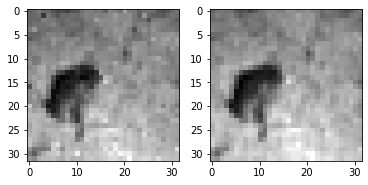

True label: 6
predicted label: 2
Time:  228.8482220172882  seconds
Initial fitness: 
 [-0.599535875112083, -0.5996994671023775, -0.5995131623299516, -0.5995593564313443, -0.5997907052493283, -0.5995591042298101, -0.5996268269136134, -0.5994419489042216, -0.6000329571160933, -0.5998120655850139, -0.5995471650114572, -0.5994104195260488, -0.5993765651716362, -0.5995020918508415, -0.5999429039282255, -0.5996069580916092, -0.5995365232134457, -0.5996265123559503, -0.5995360713541673, -0.5996686226715823, -0.5995093707367807, -0.5995931907537476, -0.5996473141282742, -0.59969546903186, -0.5998196076306141, -0.5997547375603343, -0.5996323768979942, -0.5996015193582325, -0.5996662325738217, -0.5994376484531867, -0.5993799256850643, -0.5995121644267518, -0.5994358171872236, -0.5995047559193705, -0.599628165950461, -0.59958984139711, -0.5993613591488716, -0.5994798924754092, -0.5997745673940352, -0.599409764205553, -0.5994925778829261, -0.5995957534574605, -0.599633420974836, -0.599535392916182

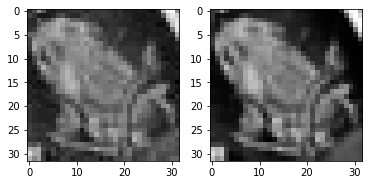

True label: 6
predicted label: 2
Time:  732.7205274105072  seconds
Initial fitness: 
 [-0.6010333469596345, -0.6065474369849251, -0.601053497000699, -0.6043545225537985, -0.598124233563493, -0.601035495399436, -0.6042036791499907, -0.6042140927382087, -0.6046669409580647, -0.6003849031138715, -0.6068077932848392, -0.6058750662779704, -0.6052853902520174, -0.5993130689778213, -0.5974453619913707, -0.6045946945222765, -0.6080123005281248, -0.5961966648167717, -0.5953627565469368, -0.6020352904246564, -0.6083656239283899, -0.6028321977054226, -0.6076518097291526, -0.5952693507580501, -0.5965171553752264, -0.5967385075704629, -0.6061586531116303, -0.6000274545414419, -0.6074750288548818, -0.5974806454884949, -0.5992750555145622, -0.6104909767233595, -0.5972358524045588, -0.5964123520447276, -0.5976995374324486, -0.5972206417615227, -0.6082884790014573, -0.60829964465065, -0.5952634651758919, -0.6071785159542529, -0.6073530400489375, -0.5972833241553728, -0.6028614894874086, -0.601155486500

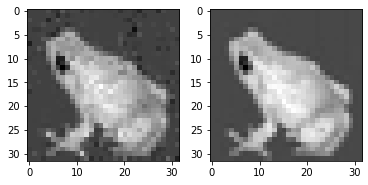

True label: 6
predicted label: 2
Time:  295.4146616458893  seconds
Initial fitness: 
 [-0.45555649789395836, -0.5251223238772419, -0.4939788544523274, -0.45948470481652076, -0.48790364191922975, -0.4962090774716951, -0.5313306739057547, -0.5459174586008899, -0.5354200058662079, -0.5439959443331099, -0.48400942706418826, -0.4730279278014896, -0.5160416224684776, -0.5240163727179956, -0.47002867998480924, -0.47119478016205224, -0.49780669329849303, -0.5055652777021253, -0.4523598522870626, -0.5320612177110753, -0.5070311526719309, -0.5189790829197517, -0.4820813372599079, -0.5369614210738101, -0.501676963979105, -0.48741434366925557, -0.49341541478465434, -0.4730834645979332, -0.5125059706740642, -0.47619102782606293, -0.5122530186423144, -0.4665476250142246, -0.1983188159992262, -0.48752139828999586, -0.548355799302965, -0.5265742815155405, -0.4178790189065934, -0.5157800860314072, -0.4961121953644134, -0.4674376160484568, -0.40282099061609866, -0.5864984100072578, -0.5523990731481438, 

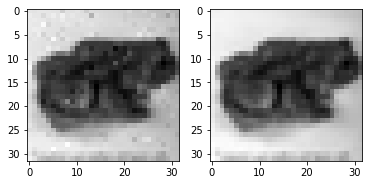

True label: 6
predicted label: 3
Time:  240.95298862457275  seconds
Initial fitness: 
 [-0.5991388308099853, -0.599312044842806, -0.5953821735033034, -0.5992288413597726, -0.5997216826713244, -0.5990426290017103, -0.599079203226737, -0.5998921580507875, -0.5994945111195332, -0.599421124081357, -0.5997419971211225, -0.5996698341149749, -0.5994587845673021, -0.5989034968176068, -0.5988801202773928, -0.5994945923144528, -0.5988193131444458, -0.5993149841029792, -0.5989750486605459, -0.5991590436470882, -0.599629209731838, -0.5993211208730711, -0.5990845576674799, -0.5996542976969528, -0.5998192564863692, -0.59923286298774, -0.5993940996922015, -0.5995643607604489, -0.5990537853301523, -0.5997025125339521, -0.5993080142656092, -0.5990348951378831, -0.5999128392877868, -0.6008285401594415, -0.5987476220252778, -0.5987536357088341, -0.5990407100353345, -0.5990132788000805, -0.5993154997512352, -0.5995543860467117, -0.5999043756723212, -0.599077233567826, -0.5989757178946927, -0.5993937773636

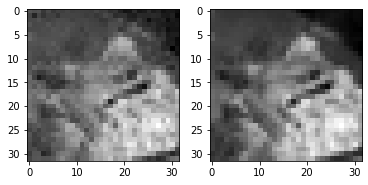

True label: 6
predicted label: 2
Time:  641.7325356006622  seconds
Initial fitness: 
 [0.12201549416778547, -0.0835116055866452, -0.05368326466425355, -0.10092515409265068, -0.11101992417309295, -0.16506678927038326, -0.009628490387612043, -0.09292518800859739, -0.28949308998548323, -0.4443684383383606, -0.09973745658438424, -0.1630584822212032, -0.46478424661321227, -0.04366109739122717, 0.09667996320323051, -0.2699072626004416, 0.09320683212602837, 0.11620617477865171, -0.08811008435190079, -0.16120992457660457, 0.11457445421831086, -0.13248466763636146, -0.0817245054823359, -0.0046241368371924, -0.14649942154282622, 0.0019959799414804857, -0.2149583207978758, -0.1893301682279891, 0.12242831245291715, -0.059336406150386184, -0.2623414265364386, -0.0900500842836579, -0.15855686674668107, -0.2054123917273576, -0.14289423958225972, -0.2536041702653826, 0.08408098796680054, -0.06291634520747696, -0.11593535268174182, -0.1351758740719414, -0.019389985714737545, -0.08027248628045036, -0.16

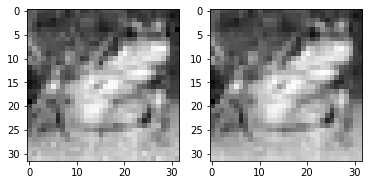

True label: 6
predicted label: 4
Time:  229.32737350463867  seconds
Initial fitness: 
 [-0.599877984465913, -0.5998389819845289, -0.5997814355590547, -0.5998221167533674, -0.5999465528044104, -0.5999036125929108, -0.5998895842174757, -0.5997735616641015, -0.599817750647368, -0.5999329819930128, -0.5998850424395326, -0.5999446415615125, -0.5999408978250148, -0.5999343412696897, -0.599958630867332, -0.6000054084355569, -0.6000679115193694, -0.6001132073960742, -0.5998570385258034, -0.5998768645951935, -0.599939036104408, -0.6000260985917474, -0.5999519410806387, -0.6001357932938428, -0.6000314115387803, -0.5997579339128891, -0.6002185066451178, -0.599911425941588, -0.6002415176225833, -0.5998152654156881, -0.5999348632979513, -0.5998159238362015, -0.600006397582137, -0.5999896250442385, -0.5998923502269023, -0.6004249332925127, -0.5997723026175199, -0.5998486852441259, -0.5997765991253173, -0.599802353708621, -0.5998330339507606, -0.5997704939132074, -0.5999752255044288, -0.5998015936093

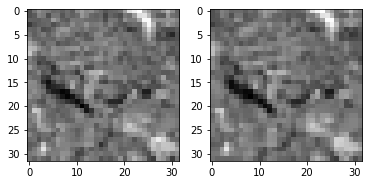

True label: 6
predicted label: 2
Time:  472.4078414440155  seconds
Initial fitness: 
 [-0.5894748270910501, -0.597583860147129, -0.5883122554689124, -0.5880245647978892, -0.592328640774012, -0.590350503200439, -0.5885291891928786, -0.5874736974143353, -0.5921614005339035, -0.588716492961778, -0.5885453676347601, -0.5819538493253408, -0.5823355418384277, -0.5933772782865327, -0.5875390461764195, -0.589104024898928, -0.5883663241530334, -0.5890417249182726, -0.5838715461591327, -0.5863335347421436, -0.5903804291465637, -0.5910891816191349, -0.5940017210182201, -0.5946721043622951, -0.588984072526436, -0.5959267812538234, -0.5955587897464076, -0.5839800475670603, -0.583384967407353, -0.5807177620738933, -0.5863802918358392, -0.5917643934709279, -0.5849597591077034, -0.5852650583496055, -0.5891809860506436, -0.5837882132628963, -0.5862682022468985, -0.5887314247561535, -0.5880308692453817, -0.5935796072272722, -0.5884913978415601, -0.5785244237722107, -0.5836930074414906, -0.58733661168183

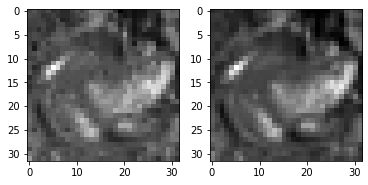

True label: 6
predicted label: 3
Time:  343.3601408004761  seconds
Initial fitness: 
 [-0.5978144607234857, -0.5969589113632265, -0.5979038935561611, -0.5980126976246077, -0.598416576272084, -0.5974535779817853, -0.5969431474070555, -0.5974844307113761, -0.5977153178880604, -0.5981400743269814, -0.5981777082310069, -0.597919956933221, -0.5975104495718476, -0.5976223468178098, -0.5980948769327528, -0.5980529440151925, -0.5976224975476461, -0.5982496223975983, -0.5979772898927113, -0.597658820253253, -0.597839176139526, -0.5984746755396386, -0.5979104559628496, -0.596803432411702, -0.5978412669831324, -0.5982390972424951, -0.5978042273913606, -0.5978516590201602, -0.5983236625727724, -0.5972290579290294, -0.5976446426944465, -0.5984390572188307, -0.5973728358313404, -0.5975695493475122, -0.5978503529855621, -0.5976102271702487, -0.5982071274695806, -0.5986519054589575, -0.5975037902824909, -0.5987429470457587, -0.5980532976127075, -0.5980674372448203, -0.5977406759570194, -0.598343120253

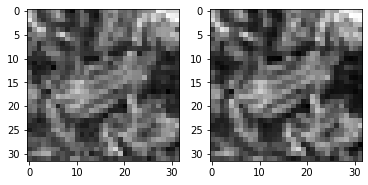

True label: 6
predicted label: 2
Time:  384.3442826271057  seconds
Initial fitness: 
 [-0.5956395926494124, -0.5969420249962908, -0.5963797563744455, -0.5972298546963384, -0.5948241755749835, -0.5958741345050353, -0.5965377761834658, -0.5966712519745461, -0.5967394519006136, -0.5974271191293672, -0.5963285207791357, -0.5965386833282016, -0.5984284135351998, -0.5953771284114003, -0.5954592003518587, -0.593666979292882, -0.597513508960064, -0.5943334958382315, -0.5974344954506657, -0.5946461873850367, -0.595878980190176, -0.595411568574986, -0.593664906709714, -0.5987707177199979, -0.5974957931424617, -0.5976809169697611, -0.5949431134273813, -0.5955570023937704, -0.5961389163288313, -0.5969013369461209, -0.5982173437072182, -0.595819541039908, -0.5955083242249348, -0.5951888142979047, -0.5973053715062564, -0.5974639289285864, -0.596586560541247, -0.5967720213059832, -0.5974772613719715, -0.596376437154907, -0.5961093280889302, -0.5960898502346454, -0.5959674100633382, -0.598704223071171

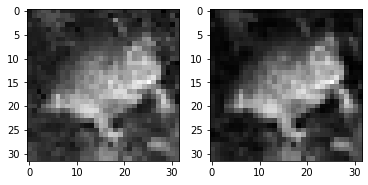

True label: 6
predicted label: 2
Time:  307.21043038368225  seconds
Initial fitness: 
 [-0.5979536539638548, -0.5976427890704, -0.5982674778259809, -0.5980852665102179, -0.5981053864221043, -0.597815418350446, -0.5980973217851904, -0.5984244804914849, -0.5985572122593565, -0.5976634695416617, -0.5985194218534545, -0.597295547655327, -0.5987605228791617, -0.5977149048104003, -0.5972944608548492, -0.5981000481339156, -0.5984072240157352, -0.5982234349709362, -0.5977628235908651, -0.598589307243909, -0.5971172550310329, -0.5980730147443796, -0.598542869291429, -0.5988238622871012, -0.597982918887538, -0.5995041513147978, -0.5983948592290983, -0.5981680005633697, -0.5980964933044288, -0.5972767625068276, -0.5986265691185165, -0.5968481855694371, -0.5963501956463302, -0.5978634582513254, -0.5970808414183506, -0.5979210078760401, -0.5981292064696677, -0.5988398036904145, -0.5992540740787213, -0.5981156510600956, -0.5986634131759287, -0.5980107398303446, -0.5980601048426948, -0.59921904655256

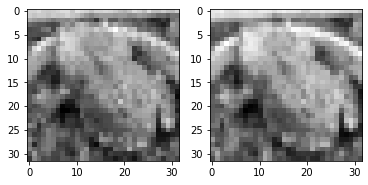

True label: 6
predicted label: 2
Time:  523.8254096508026  seconds
Initial fitness: 
 [-0.5993190214840256, -0.601710853836215, -0.5990960721821932, -0.6020546004218648, -0.6019770921515847, -0.6001724424905448, -0.6011380209007892, -0.6002315602172789, -0.6023705734515427, -0.6012467832779249, -0.5991697675140988, -0.6018540475894477, -0.6008824317983736, -0.5983383705041285, -0.6027681166124954, -0.6001245363417844, -0.5997521604443818, -0.5995928115803822, -0.6011815362611885, -0.6016514523108101, -0.6013173350016692, -0.601758944844766, -0.5995287954394457, -0.5992793776360505, -0.6017872956292231, -0.6008214808671755, -0.6007492591468021, -0.6015973321342142, -0.6000396139610557, -0.5994573394160648, -0.5993981206875328, -0.6017725854028394, -0.5984649329913359, -0.6031139841530878, -0.5993511676675152, -0.6013375937654215, -0.600865071024337, -0.5999661200166112, -0.5993380062929899, -0.6006536174296393, -0.6025712318387844, -0.599758461524282, -0.5991668651436473, -0.60082806728

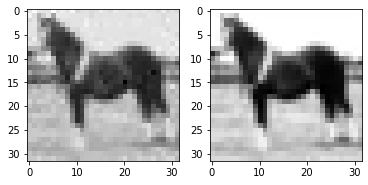

True label: 7
predicted label: 5
Time:  561.2149753570557  seconds
Initial fitness: 
 [-0.5990441262089581, -0.5999958120646165, -0.6022047786987698, -0.6004231025325246, -0.601237671964257, -0.6001698780570031, -0.5989920178061807, -0.6024853883296244, -0.6022506138810715, -0.6057885149727131, -0.6008517176178734, -0.6020378093081609, -0.6044620973400107, -0.5995746780762359, -0.600376471127468, -0.6012075867975543, -0.6006260389735851, -0.5988382876837174, -0.6053545420465178, -0.6020464660772585, -0.6025442607818432, -0.6004876614691649, -0.5994866506845165, -0.604932925732213, -0.6011160287167561, -0.6077853876862893, -0.6041322384901572, -0.6010793201176318, -0.5998603852932916, -0.601323666528238, -0.5998893326654191, -0.6027246222590674, -0.600222849045225, -0.6049862161341029, -0.6034611485070323, -0.5993495692997619, -0.6010964433485032, -0.5993498781001644, -0.5995126875416146, -0.6012360424478125, -0.6063352600012571, -0.600977867791191, -0.5993477043643543, -0.5989354734262

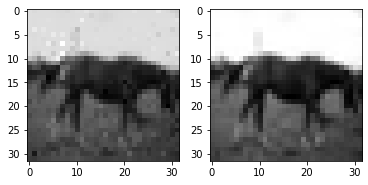

True label: 7
predicted label: 4
Time:  195.05299353599548  seconds
Initial fitness: 
 [-0.6002004441692388, -0.6004169845427071, -0.600056454943955, -0.6002947549323132, -0.600277970567754, -0.6005047411584817, -0.5997535514611013, -0.600579939582262, -0.600308940737827, -0.5997863525015351, -0.6007654340842165, -0.5997447674304861, -0.5996677100473136, -0.6005057280773419, -0.6001389454511011, -0.5998867003287317, -0.5997520933270344, -0.6000780672220724, -0.599810294817497, -0.6000803849172434, -0.6010993230949064, -0.6000878118106353, -0.6004986836766287, -0.5999751782449849, -0.5997506387500808, -0.601672773370564, -0.6008175331833544, -0.6010636123797996, -0.599919217564933, -0.6000714291446598, -0.5998335574196744, -0.5997299311307314, -0.6000721894666106, -0.5998819953890137, -0.5996510374707762, -0.5999466268586702, -0.6005077170728099, -0.599874675870401, -0.5997378150876799, -0.600008218731465, -0.5998039794412927, -0.5999147825940936, -0.5998520205077283, -0.599479479840173

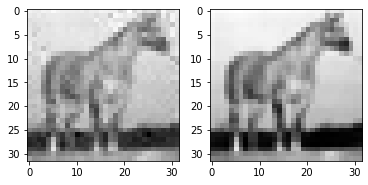

True label: 7
predicted label: 3
Time:  884.7694027423859  seconds
Initial fitness: 
 [-0.5263673821679415, -0.5246942756165804, -0.5274508443206807, -0.5463116599927546, -0.5389439305269229, -0.4897733480678206, -0.48844164121586886, -0.49180305620165293, -0.5111304395392218, -0.4918807058962893, -0.5368540468960978, -0.5180421848449486, -0.5220171800994179, -0.529044136210671, -0.514421013306734, -0.4763331799398374, -0.5349003801901004, -0.5370200270550292, -0.5622519573491767, -0.5132115897755042, -0.5106683290384034, -0.5277944792509653, -0.5254097013933218, -0.5095302725386478, -0.5189091685630352, -0.5080528882400193, -0.4487712223461874, -0.532050737189152, -0.5089550996976253, -0.526200541943408, -0.5703222321082344, -0.5021125543915579, -0.5036970079477512, -0.57371931510726, -0.5066626035480297, -0.5694086385151713, -0.5198416754146434, -0.4889194061104687, -0.5030623993640916, -0.5134211810185283, -0.48447825174462567, -0.5299827418265782, -0.5133824418814603, -0.5516866102

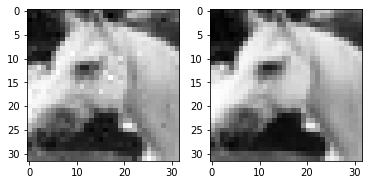

True label: 7
predicted label: 3
Time:  251.40711212158203  seconds
Initial fitness: 
 [-0.4678268772343428, -0.4742796990280737, -0.4802638923811273, -0.4261756873861472, -0.4976231264495762, -0.49349638061955203, -0.4982857204000607, -0.506408156242474, -0.3403972337713027, -0.48044397253565024, -0.43593641845262376, -0.5041180788868278, -0.414118845239386, -0.508826011716136, -0.5054225366923135, -0.5022864913246741, -0.49635875801558876, -0.44684519688259894, -0.48955926854018395, -0.44832386685670356, -0.4519166770990667, -0.4804300852248292, -0.481154699673045, -0.5205123041745163, -0.48075088511441555, -0.5042086968671109, -0.5307190968539638, -0.5325513694513919, -0.49464496832993465, -0.44784423272776397, -0.3185927728313779, -0.5076486432142918, -0.485376215004223, -0.4742779212156818, -0.49346005252296543, -0.48947545443414886, -0.4640676632970844, -0.4843444160572806, -0.49279082061403456, -0.4633622436904431, -0.4582656510181782, -0.49381569469162634, -0.459165223261667, -

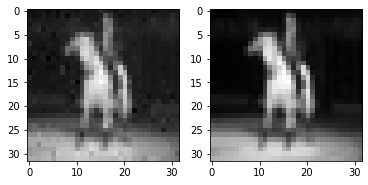

True label: 7
predicted label: 5
Time:  315.8739984035492  seconds
Initial fitness: 
 [-0.6005041162758955, -0.6003093887816917, -0.6002891536757743, -0.6003152829673883, -0.6008486012001497, -0.6003705098948553, -0.6011394338075188, -0.6002922084712017, -0.6004543977046082, -0.600663297550803, -0.6001907804806385, -0.6007122826901641, -0.6001616132072704, -0.6001003757914871, -0.6007457075531785, -0.6016112269580811, -0.6001360016959117, -0.6000901197841635, -0.6000071157690652, -0.600127889943388, -0.6006502173260176, -0.6003545872634292, -0.6004073034967067, -0.6003184214622169, -0.601176544297967, -0.6001418990564088, -0.600866489069031, -0.6001089355715662, -0.6004506511264284, -0.6011031316629457, -0.6002280990093132, -0.6005496667224143, -0.600288668993621, -0.6005318790784634, -0.6003511142460201, -0.600343295178766, -0.6004299385094736, -0.6010726644606287, -0.6002950128726917, -0.6005252013443123, -0.6002925015799391, -0.600825202462571, -0.6004929748906549, -0.60062679251330

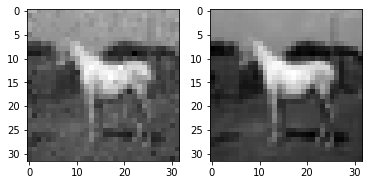

True label: 7
predicted label: 5
Time:  399.9885878562927  seconds
Initial fitness: 
 [0.6515474348102827, 0.5375923303558805, 0.6008149601853426, 0.5902538907921238, 0.5734400778779466, 0.6420793120618057, 0.6537800091045441, 0.669245112356099, 0.5998099525630574, 0.5767361520232694, 0.6481074411973913, 0.6293026490071358, 0.582808310448763, 0.5949673041684734, 0.5860358007673747, 0.6009550522415283, 0.6052950862130059, 0.5840124047708641, 0.5260179122607014, 0.574355401394653, 0.5955524248197739, 0.5235367077520735, 0.5888102323540193, 0.6311919193618146, 0.6080937578811147, 0.6082675798563677, 0.542457195171397, 0.5724482421146856, 0.6187306273819725, 0.525547719028214, 0.5258240396981166, 0.6032459536400263, 0.5658718130842219, 0.6888204845224521, 0.5792276126224666, 0.552899134622563, 0.5404025414804331, 0.6071126496997736, 0.6638943815723688, 0.5546683668989283, 0.5745893326835735, 0.6988018454748712, 0.6070095450744872, 0.6188420495171076, 0.5625901334899887, 0.7752069448627688,

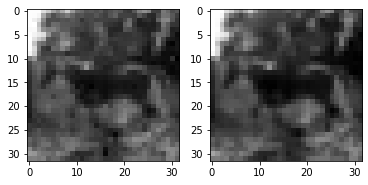

True label: 7
predicted label: 2
Time:  207.02198266983032  seconds
Initial fitness: 
 [0.404702942161546, 0.38756034949645835, 0.5903446097740375, 0.31504002580943147, 0.41445729826249217, 0.3460711161791802, 0.3609304366071629, 0.176438917063854, 0.3211598856774739, 0.26408288731824947, 0.3603945434207827, 0.35304597581288716, 0.29750042514545294, 0.5057681785225335, 0.3397981481167843, 0.32343107896882256, 0.3163949849404932, 0.3316492142492519, 0.21288330237026024, 0.3015428080189157, 0.3819768255349817, 0.311941892189618, 0.31369676970794846, 0.2598006236058455, 0.3394743044521789, 0.3249145324417587, 0.2819648101823756, 0.47178866625088756, 0.24360320310619676, 0.4187805914462077, 0.32594725957393, 0.2413250892703076, 0.36816274213740097, 0.3000631809105886, 0.3751989873950925, 0.2940147900412247, 0.4432272160037848, 0.36338180914003626, 0.43336599875159587, 0.2240169781344261, 0.5012718608669829, 0.2727539911885587, 0.21776504744142183, 0.35231089010404726, 0.547684362903998, 0.

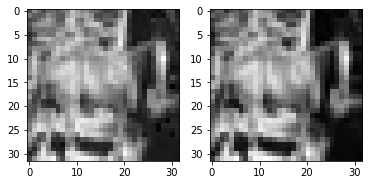

True label: 7
predicted label: 9
Time:  284.2208294868469  seconds
Initial fitness: 
 [0.23239261138290238, 0.2223830453622284, -0.025856228974129952, 0.30172811787267273, 0.2683230700058291, 0.41014317615463874, 0.22465364851559746, 0.3865815667044896, 0.32516335137332925, 0.3565801018621303, 0.11132733136500145, 0.30557348107881516, 0.2525557721254347, 0.1493525100856692, 0.10392670497439822, 0.2984152131208497, 0.23012619767879078, 0.21791840060143183, 0.23087228282561223, 0.38019380390564184, 0.2582428555353903, 0.12145873341106092, 0.23087566253238104, 0.2063911076599405, 0.16173731759372686, 0.11144723137692444, 0.23566560121281713, 0.3249723592081156, 0.21853596667105182, 0.3338680864521627, 0.49495125756561864, 0.18997459506488806, 0.30619016673212845, 0.037036864128466324, 0.21605992702359159, 0.14359909749087857, 0.2688431187098799, 0.5416901264764422, 0.43757778085122956, 0.38845468478068534, 0.28973005441062183, 0.31560172922802676, 0.05332007556568141, 0.2844335109426018, 

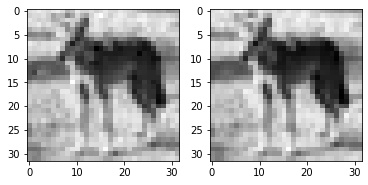

True label: 7
predicted label: 4
Time:  188.09501385688782  seconds
Initial fitness: 
 [-0.5677611553954498, -0.5822275778256085, -0.5758212283385121, -0.5859583956913083, -0.5795864783278163, -0.5667265208576144, -0.5556186155765576, -0.5747922365361843, -0.5750106156676058, -0.5698173459600819, -0.5875295025000205, -0.5838215612976209, -0.5765815864153911, -0.5746769929453062, -0.5592455861906934, -0.5828948589276765, -0.5534177843694815, -0.5871867509002109, -0.5770139752171185, -0.5777555274428586, -0.5758628731229865, -0.5799934982103195, -0.5800684160403943, -0.5790250347427107, -0.5758525139675466, -0.5831243678883709, -0.5786048407270574, -0.58004013938568, -0.5711267093653535, -0.5735389711375611, -0.5776811123360049, -0.5785918213245292, -0.5849241180938242, -0.5848889123572589, -0.5753385503253773, -0.5751415242430924, -0.5782540305640496, -0.5620033297468778, -0.5748051753444792, -0.5776268898223911, -0.5846313271397969, -0.5775689585156526, -0.5481399324559533, -0.58780808

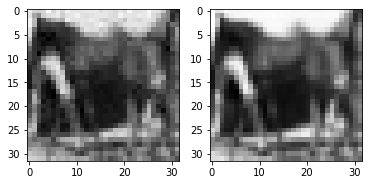

True label: 7
predicted label: 6
Time:  529.5114681720734  seconds
Initial fitness: 
 [-0.5966804175126381, -0.5968971362946989, -0.5976285645451838, -0.5959236933630065, -0.5965713390205968, -0.5972925589554023, -0.5975718919595028, -0.5962027331740847, -0.5976931349975059, -0.5951901961292917, -0.5983105664563455, -0.5967699042368442, -0.5983098267548732, -0.5953010886599087, -0.5963870000905045, -0.5936129624279606, -0.5981127017329614, -0.5911630273161375, -0.5963404409074244, -0.5959243798341292, -0.5980864614530325, -0.5974786125855143, -0.5980550567755526, -0.5974331989551518, -0.5970258215416345, -0.5970801567157965, -0.5968030255349581, -0.596429983909017, -0.5961622261644438, -0.5967137051970759, -0.597256937542926, -0.5977345163708527, -0.5974218771670404, -0.5982898440326098, -0.5936742475142994, -0.5930457824014406, -0.5976301274233513, -0.597579775210667, -0.5953859616118303, -0.5954072416766254, -0.5982286825328798, -0.5967168330020679, -0.594930120386402, -0.59536622206

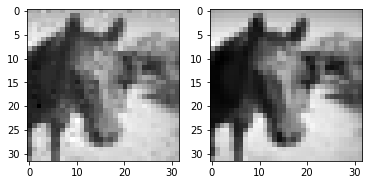

True label: 7
predicted label: 3
Time:  334.72207617759705  seconds
Initial fitness: 
 [-0.5898414079733756, -0.5901409767489756, -0.5872428852663194, -0.5924550677708466, -0.5869246380779525, -0.5921668595743942, -0.5900858598349066, -0.5886141041147104, -0.5816310331735757, -0.5916415322726292, -0.5902663970516855, -0.5911122076628735, -0.5885102111623464, -0.5832811640723372, -0.5766754147676613, -0.5896482740092278, -0.5929709921339426, -0.5927120442681051, -0.5841422969103488, -0.5909682185510491, -0.5912038746660693, -0.5857233790282752, -0.5791868372502886, -0.5800876464640127, -0.5874051304662397, -0.5925218895263369, -0.5873208346194118, -0.5857986079913103, -0.5691099408790301, -0.5922227462709689, -0.5790503005024104, -0.5807307255883614, -0.5892610645182511, -0.5827653797029693, -0.5918279019011707, -0.5790029896591484, -0.5887348719248542, -0.5902731984237527, -0.5893338876175815, -0.5848322488843899, -0.5906191440918371, -0.588575400502489, -0.5852783618848261, -0.5876265

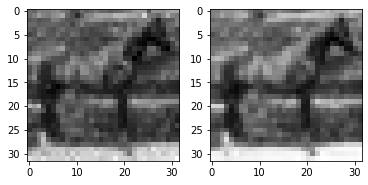

True label: 7
predicted label: 4
Time:  617.7576334476471  seconds
Initial fitness: 
 [-0.253025599705091, -0.31209235633387, -0.21625522643415693, -0.33361057871049826, -0.320069951769986, -0.1356928922103897, -0.2945616249935237, -0.28090575648188293, -0.3224245747962585, -0.4173353300587207, -0.1744594940542292, -0.2836101358136272, -0.3543798874903542, -0.32276854817909884, -0.3104694829668755, -0.42249014454998424, -0.31853854430909645, -0.3475362375490335, -0.32932985537473947, -0.2619457528854809, -0.2611339164888622, -0.24941000048998369, -0.4122131605247618, -0.3052933958486911, -0.2696840364159564, -0.168848940180661, -0.2905452236450846, -0.08766177202578057, -0.36072206530557527, -0.30866737650515474, -0.24466530839103215, -0.3848889638464797, -0.1705649751964678, -0.2566333245132224, -0.3119525623621118, -0.2789336967844315, -0.30353786452971987, -0.2928556872303932, -0.288817409215931, -0.24947922651484308, -0.326375767174503, -0.41817662238986586, -0.26423832459814767, -

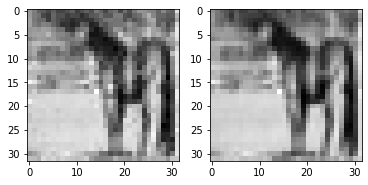

True label: 7
predicted label: 4
Time:  418.3401963710785  seconds
Initial fitness: 
 [-0.5989456644559868, -0.5994563664077006, -0.5995475176739531, -0.6004592619653797, -0.5999132785272698, -0.5992834195259965, -0.5992557677625834, -0.5999159632806756, -0.5991881202563063, -0.5990605492671773, -0.6001220114784608, -0.5992681077205352, -0.5993140062195383, -0.5997683648300638, -0.5994313282550322, -0.5993166289629598, -0.5993793095003451, -0.6005152074466334, -0.6001051819763532, -0.5996083216733179, -0.600044651315137, -0.5988140392717767, -0.5996632387328049, -0.5993063991203545, -0.599635404437225, -0.5996503700877277, -0.5978912050947982, -0.5998211750109795, -0.5990724272084434, -0.5999015694369744, -0.5995142946849211, -0.5999473685247695, -0.5992315172742932, -0.5985683008496605, -0.6004062828355639, -0.6002509213759527, -0.5989341794616434, -0.5992990634185658, -0.5993968588454712, -0.59972161644168, -0.5994084484772007, -0.5998072961788038, -0.5999477661011464, -0.59966395159

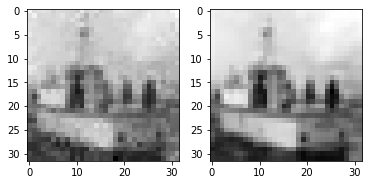

True label: 8
predicted label: 9
Time:  748.6921494007111  seconds
Initial fitness: 
 [-0.5710883519518941, -0.5795871982888957, -0.5444559742582841, -0.5533325664927764, -0.5847688164798359, -0.5760580884913338, -0.5489575919793188, -0.5773039495708792, -0.5642558552349041, -0.5657308935643515, -0.570422993238401, -0.5731162769072522, -0.5662072629668843, -0.5649012615100414, -0.5726270631612191, -0.5672663906174567, -0.5658522287590382, -0.5621419728210256, -0.5580439717438515, -0.5634325035415866, -0.560683958447759, -0.5744373224154095, -0.5678057179769777, -0.5571585899365327, -0.5835950190085883, -0.5754362917847091, -0.5761488071285795, -0.5646256167993717, -0.5654941567395341, -0.5785944514900792, -0.5692801652496801, -0.5745708972390996, -0.5754078887206321, -0.5660183673416372, -0.5791543340721668, -0.5711574845516684, -0.5755339128046498, -0.5454538125413362, -0.571106794266487, -0.5723452584010269, -0.5747534647270159, -0.5755349035339801, -0.5735015351366834, -0.5785994220

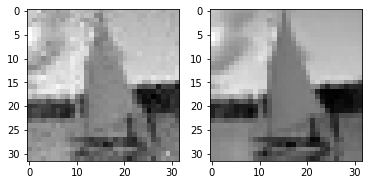

True label: 8
predicted label: 2
Time:  612.0649707317352  seconds
Initial fitness: 
 [-0.13703534377567142, -0.28392292167511246, -0.25677837764322636, -0.42024121255189856, -0.3910600327045209, -0.21511294085384167, -0.22618222637659705, 0.09499055575796304, -0.23629499588837272, -0.31688121583526474, -0.24773193627768797, -0.3210768491171946, -0.1794855645077383, -0.20131855952344452, -0.27718343667564266, -0.43706950134223854, -0.12461266094976448, -0.09303687304743871, -0.23202892032664885, -0.332309242904577, -0.3489867302976326, -0.17398841157098496, -0.151287827883573, 0.08633151018009723, -0.4363137202666193, -0.3712167625801531, -0.20228969366497054, -0.3533359845882791, -0.42500385212769753, -0.3352793261888602, -0.3146626199695045, -0.2723467653459628, -0.135431069294045, -0.3603971802912086, -0.34160422110656674, -0.09852369321012994, -0.19406689351691467, -0.3265027250846661, -0.11834750898218308, -0.3647646599448635, -0.5351951865432609, -0.3827399570059635, -0.217821414

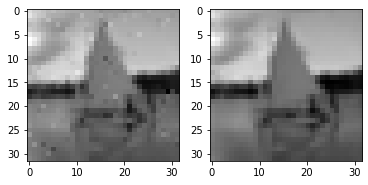

True label: 8
predicted label: 0
Time:  187.20365619659424  seconds
Initial fitness: 
 [-0.6058766810043276, -0.6030614507463733, -0.6037678726173448, -0.6047034093491779, -0.6059371194443708, -0.6036167626290744, -0.6021854864740709, -0.6017530262011697, -0.6001067538116025, -0.5997725368193839, -0.6059556260254475, -0.6031862931470082, -0.6052902469071666, -0.6026481078068852, -0.6039674470942532, -0.6012313869044007, -0.6030304713278778, -0.6024321239875098, -0.5999288695470785, -0.6022472265426544, -0.5999988817973111, -0.602763520585735, -0.6081690895707412, -0.6017158599693239, -0.6000521039577329, -0.6091845160008507, -0.6005704917492519, -0.6019356911151823, -0.6048440779847863, -0.5999902975265339, -0.602410068306225, -0.5999036454627892, -0.6145897441436481, -0.6006759969015565, -0.6010336518996094, -0.6010265742600871, -0.6059306910348868, -0.605423880664526, -0.6074122182852508, -0.6045574066665992, -0.6061005543201984, -0.6039611303178991, -0.6000831686429283, -0.600687296

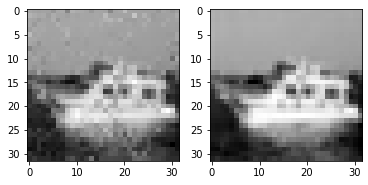

True label: 8
predicted label: 0
Time:  398.2202100753784  seconds
Initial fitness: 
 [-0.5995998192865808, -0.5994312662859778, -0.5995843934014781, -0.5996428848701625, -0.5996805097774658, -0.5995611080731942, -0.5997502933969514, -0.5997677808942744, -0.5995226155478705, -0.599490311779764, -0.599499270125311, -0.5994955838733769, -0.5997964005090345, -0.599897634863309, -0.5998017104094342, -0.5997403263580554, -0.5995096909652932, -0.5997242333585503, -0.5994397015192505, -0.5996530047440095, -0.5997595495383626, -0.5992868784703396, -0.5996041866944908, -0.6000208894474471, -0.5996982989997868, -0.5995647394371647, -0.5995819353445321, -0.599766390373351, -0.5995865782789085, -0.6000505153180946, -0.5994976083760888, -0.5995471971549087, -0.5995789783778043, -0.5994538879520561, -0.5996311782291915, -0.5995336380095706, -0.5993485896804521, -0.5996389246806497, -0.5995194343712792, -0.5995655427594259, -0.5996330997142563, -0.5996373136570748, -0.599557024683147, -0.599577174698

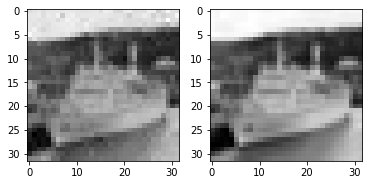

True label: 8
predicted label: 6
Time:  409.86593079566956  seconds
Initial fitness: 
 [-0.5841933833962609, -0.5930108822030222, -0.5916845661223471, -0.5962343167360866, -0.5936337828489865, -0.5892956164997745, -0.5865561157167802, -0.5809353268053998, -0.5918460240696582, -0.5969199497899678, -0.588877227182777, -0.5794559322244572, -0.5873901819442847, -0.5886425006265381, -0.5946009788177501, -0.593452461743703, -0.5905756171671072, -0.5897236189232411, -0.5894865467802509, -0.5895666414474958, -0.5916145262886017, -0.5892198889152086, -0.5915100939105414, -0.5914496777769788, -0.5929510633892398, -0.5912554345487946, -0.5894411590855646, -0.5923473606437862, -0.5869576582840728, -0.5949978626745953, -0.5913754281263394, -0.5878181183948042, -0.5906597937365167, -0.5904896281514995, -0.5907392969290028, -0.587760949624399, -0.5895903968368797, -0.5855086959812063, -0.5962932096911724, -0.5931885151707122, -0.5930787873787098, -0.5901904829125515, -0.5977861477521393, -0.593002115

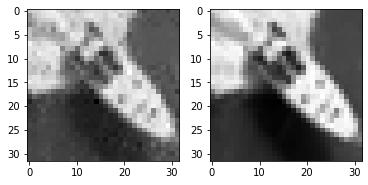

True label: 8
predicted label: 0
Time:  475.7640926837921  seconds
Initial fitness: 
 [-0.6013304498914056, -0.6018031411181387, -0.6038547588219988, -0.6007575463321491, -0.6013366935730385, -0.6056006937630798, -0.6015440018671945, -0.6021662151608289, -0.6006552031538313, -0.6062514356804914, -0.6013403486506146, -0.6015383101475149, -0.6017262974724705, -0.6009699742633119, -0.6048813544321031, -0.6013094019373633, -0.6012978487594716, -0.6039856279018108, -0.6028649100574403, -0.6009071168053134, -0.6029982028301629, -0.6033316909348572, -0.6066228154898231, -0.6005722157020001, -0.6023561704964697, -0.6029652207028645, -0.6006123626305834, -0.6034931882226888, -0.6011027219252387, -0.6020666566550228, -0.6006749637694138, -0.6022717997402071, -0.6001257208397168, -0.6020027022343319, -0.6020896622910364, -0.6002761473906822, -0.6002038461845829, -0.602327154178003, -0.6032419629524043, -0.600595099164086, -0.6034233622288717, -0.6021419727237242, -0.6034798315966406, -0.602460511

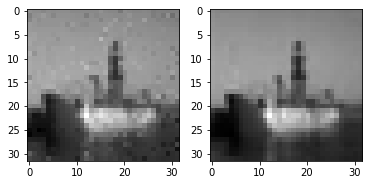

True label: 8
predicted label: 4
Time:  256.18677282333374  seconds
Initial fitness: 
 [-0.599751949787172, -0.5997752775018197, -0.5997225050446805, -0.5996670748871924, -0.5998315682642127, -0.5998022879973401, -0.5993925333709224, -0.5997292524158874, -0.5996170936918145, -0.5998853308450289, -0.5997214824756032, -0.5997685213820296, -0.5997727441638177, -0.59975158929883, -0.5995715783245787, -0.5998506179998555, -0.600004509132479, -0.5996366028194983, -0.5997502695667032, -0.5998860903477895, -0.5997245926474734, -0.5994413367501751, -0.5996735667523126, -0.5997014674922347, -0.5996843683316164, -0.6001206773608987, -0.5997160688232147, -0.5997865933367315, -0.5998583835596137, -0.5996481183792238, -0.5998367680603578, -0.5997836964657165, -0.599670268155986, -0.5998287973406047, -0.5996430168343323, -0.5992466487479973, -0.5997330033113807, -0.5996390829112768, -0.5995279384426662, -0.5996710887484329, -0.5998541991617184, -0.5999195886504309, -0.5997265111883202, -0.59953402149

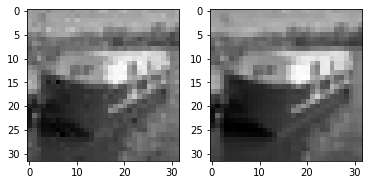

True label: 8
predicted label: 6
Time:  266.2851495742798  seconds
Initial fitness: 
 [-0.27713221894733675, -0.2554552447363554, 0.04506567500024339, -0.3678200831510585, -0.20710107021960927, -0.26444244860099675, -0.17422297186799204, -0.25345858040638325, -0.08651194334453, -0.38810241565425574, -0.38130089968430814, -0.3595743608631963, -0.38127746145413355, -0.20522033352820085, -0.38064181377598505, -0.013794239976304995, -0.19813357053468272, -0.23555686362490696, -0.23700656275203197, -0.24668845672499437, -0.2887998311208676, -0.264217692762336, 0.23494160712249457, -0.3512004308680581, -0.2764540365636323, -0.5456932472058461, 0.18921152082909298, -0.5044382638633276, -0.28818519275074905, -0.5089835019234243, -0.2679212953464943, -0.2820816586476663, -0.38976459243285067, -0.39620540806411053, -0.08401685053485433, -0.35881699671021877, -0.32998344473498553, -0.07326173768599936, -0.33820512930587265, -0.25422201890723206, -0.24563495391548232, -0.16608929805773975, -0.3992

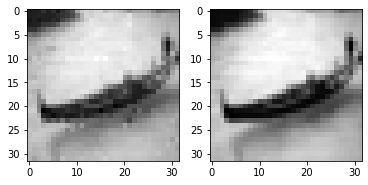

True label: 8
predicted label: 0
Time:  233.91571879386902  seconds
Initial fitness: 
 [-0.5998975059057221, -0.6045367379442548, -0.6030621238251591, -0.600378593273436, -0.6023935108208196, -0.6045478301712566, -0.6006982382408692, -0.6013256768113754, -0.603574200564804, -0.6026193303184417, -0.6023496243243874, -0.6032812360639026, -0.5993034297896083, -0.6069646751049675, -0.5994309783278616, -0.601775929212485, -0.6013640686308918, -0.6062798878821865, -0.6048758120847231, -0.6006508132057822, -0.6047262385060043, -0.60238172775656, -0.5998718525098371, -0.5987905540104095, -0.6000594101040941, -0.600143380428027, -0.6010952448909221, -0.6006481716546058, -0.6010670759038215, -0.6008897396098991, -0.5999531038346525, -0.6022723305757695, -0.6012016980855158, -0.5991535968042498, -0.6011254239386558, -0.6022088212746334, -0.6048056706154844, -0.6024114120688072, -0.6015311995387624, -0.6009800051843674, -0.6044938119571412, -0.600673420313706, -0.59952333600489, -0.602122430038007

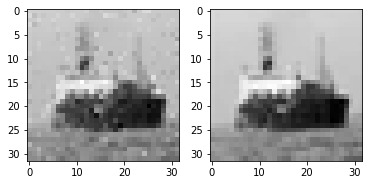

True label: 8
predicted label: 6
Time:  287.47972321510315  seconds
Initial fitness: 
 [-0.6004619602336855, -0.6009463195647735, -0.6001785640907408, -0.6002040294197879, -0.6010697136327282, -0.6002622331414912, -0.6001940429401359, -0.6002904192175704, -0.6005982762630567, -0.6005691311869773, -0.6000539121045663, -0.6001900292483165, -0.6001852523618424, -0.6002200942427738, -0.6001071086107015, -0.6002672217927842, -0.6006885762692987, -0.600055476793943, -0.600263772721513, -0.6003288751511737, -0.600160493084351, -0.6002886976229608, -0.6002812148707403, -0.6003935400722552, -0.6008173130419957, -0.6002632080252899, -0.6001258431046237, -0.6003257118251044, -0.6007610938286693, -0.600144211406909, -0.6000375217420932, -0.6001007542825747, -0.6005035438565893, -0.6001885924802556, -0.6001469436892656, -0.6001483916070173, -0.6001044111244379, -0.6000755322905482, -0.6000424322743747, -0.6000589305439271, -0.600355243787311, -0.6002697000141775, -0.6002366866850961, -0.60003403787

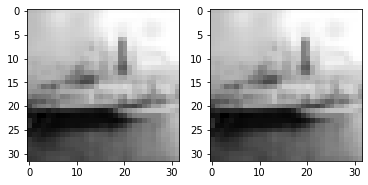

True label: 8
predicted label: 8
Time:  117.66741561889648  seconds
Initial fitness: 
 [-0.5996396299670707, -0.5990508801943398, -0.5995511915551116, -0.5992537656549156, -0.5996761421425891, -0.5996741432595931, -0.5996688160507855, -0.5996409314586679, -0.5997374450654992, -0.5994744324178403, -0.5996043207575296, -0.5995026351448264, -0.5992026632149013, -0.5994977806512498, -0.5994595214107659, -0.5992839780102577, -0.5996210875834925, -0.5999475986569633, -0.5995382901509697, -0.5995385817488836, -0.5994739723703155, -0.5994996111876648, -0.5994537942003578, -0.5996341784094674, -0.5994912070030842, -0.5990460063412533, -0.5997238097673914, -0.5996090571911148, -0.5996168561970824, -0.5997050578660575, -0.5994194077644226, -0.6000546701154191, -0.5995249020878088, -0.59939936099947, -0.599278115571694, -0.5999053677961745, -0.5995633331508547, -0.5994220609721479, -0.5995750929009106, -0.5996838803336305, -0.5991336800528104, -0.5995551212312097, -0.5994989997227496, -0.597681161

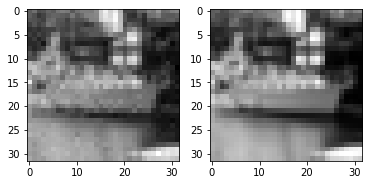

True label: 8
predicted label: 3
Time:  365.05264592170715  seconds
Initial fitness: 
 [-0.6019285473837503, -0.6037832491434219, -0.6025922606325484, -0.6063020620408797, -0.6026490725160569, -0.6007097662633342, -0.6024768992887504, -0.600558079511235, -0.6023749881806021, -0.600675625092744, -0.6007140057723103, -0.6028701396941015, -0.600711036566633, -0.6031835701000806, -0.6018753607838223, -0.6018051440279211, -0.6026215199143077, -0.6029977442787062, -0.6007596010705452, -0.6021585093313997, -0.6030505941574189, -0.6005329981862488, -0.602852496172898, -0.6026876757887376, -0.6039680006431601, -0.6011092214571173, -0.6042441290886778, -0.6050695593184323, -0.6050003727238598, -0.600265670586194, -0.6005238630722778, -0.6052027601131627, -0.6041610124965864, -0.5664472666446204, -0.6009927519288718, -0.6014430314407349, -0.6022054442393483, -0.6076082462322836, -0.6043012074416299, -0.60159775097197, -0.6018261506894572, -0.6033218774026194, -0.6049694641025196, -0.6041065157827

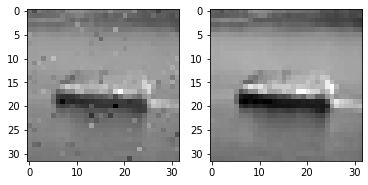

True label: 8
predicted label: 0
Time:  194.09355068206787  seconds
Initial fitness: 
 [-0.5999562103432535, -0.6000075240036398, -0.5998946199519973, -0.6000904464571284, -0.6000634649430004, -0.5999652510420737, -0.600026773373136, -0.5999327225993776, -0.5999572415714782, -0.5999083464665333, -0.6000315664033922, -0.6000270782752319, -0.6000053462017678, -0.5999197733310255, -0.6000504258596346, -0.6002560553624431, -0.5999596062725584, -0.5999660149046262, -0.6000409972749063, -0.5999490135786055, -0.6000316504462412, -0.5999675610003672, -0.6000739561719828, -0.6000257318717044, -0.6000370010689133, -0.5999877773747172, -0.6000534941636146, -0.5998589259526038, -0.5998812656916565, -0.5998935186275578, -0.5999384292477979, -0.6000853130194158, -0.5999217380307249, -0.600050497052356, -0.5999957749641514, -0.6002635241342109, -0.5999794713235886, -0.5999113234706691, -0.5999274081912057, -0.6000321899969532, -0.5999765922768379, -0.5999008574183765, -0.6000356798906492, -0.60003294

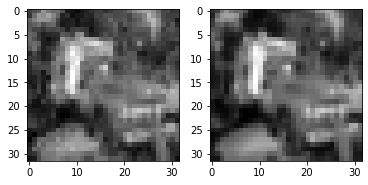

True label: 9
predicted label: 4
Time:  926.1064291000366  seconds
Initial fitness: 
 [-0.17667567725195854, -0.17148571249388253, -0.2507291244569816, -0.288002145508761, -0.20380358578741656, -0.05847916103510123, -0.2646369071530198, -0.2407966826424598, -0.27056517851454487, -0.22908052262683648, -0.2614932976861365, -0.29524567502710886, -0.25483643213086227, -0.24926251444377526, -0.34582384531997934, -0.2287337186314496, -0.21194612966611823, -0.1021655368306327, -0.1358505265807719, -0.12691812455271637, -0.3411161044100883, -0.21015871575814565, -0.12354339293960859, -0.23462860569004984, -0.3036058117620579, -0.29655829876146667, -0.26558875714995267, -0.21300347386520502, -0.2834805392435411, -0.1634585640382735, -0.11114616236089359, -0.27419390846599656, -0.2691622921025054, -0.16532656835511655, -0.19809216956518744, -0.3238084977134222, -0.1850728516454049, -0.21650858678833618, -0.2329100590705914, -0.10589932442779712, -0.1150308595475048, -0.11806770967219732, -0.2776

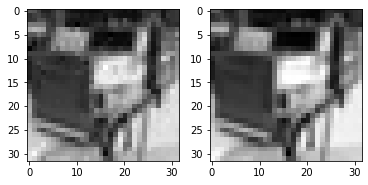

True label: 9
predicted label: 1
Time:  313.12814378738403  seconds
Initial fitness: 
 [-0.5990485746433896, -0.5980791501365967, -0.5983551330246808, -0.5985391239108127, -0.5973095129214411, -0.5985518885463846, -0.5978397164614998, -0.5964844796737354, -0.5982754847262727, -0.5975400253378125, -0.5981233749170303, -0.5978876760073412, -0.598824028477191, -0.5994508083154695, -0.5997309851717594, -0.5986344717677684, -0.5987846887478356, -0.5984077811205013, -0.5988819775132651, -0.5980399351239906, -0.5987020091744085, -0.5977488010811292, -0.5963251724798198, -0.5987127852791116, -0.597729148841751, -0.5982553436219851, -0.5948375878752707, -0.5988379461137003, -0.5982719974635435, -0.5983250635997991, -0.5978618056209333, -0.5983479653844005, -0.5986503019563295, -0.5989361151385966, -0.596421448442703, -0.5982809452242066, -0.5978464238033427, -0.5990062157245092, -0.5979044386934244, -0.5983637197716413, -0.597324472271282, -0.5979851033386291, -0.5986546989666008, -0.5985626954

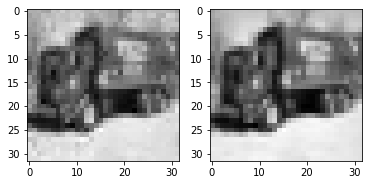

True label: 9
predicted label: 1
Time:  410.48961567878723  seconds
Initial fitness: 
 [-0.6000213725692909, -0.6073067105619223, -0.6072931725435641, -0.6033721471815287, -0.602325722433634, -0.5998796720474096, -0.6037600210758178, -0.6042751487883294, -0.6008278189168691, -0.600481939181843, -0.6001927554041098, -0.6029829492351403, -0.6035440119779587, -0.6028123341636771, -0.6002619219615022, -0.6006330282554724, -0.6001076659666518, -0.6000631232521346, -0.5999731563904799, -0.6016228362720083, -0.600750982513713, -0.6001806112792113, -0.6002068786751152, -0.6007122430565964, -0.60383725121195, -0.6048914604370955, -0.6018334262366845, -0.6035021948666838, -0.6000725347468852, -0.5999569448308041, -0.5997540766222926, -0.6080233391424258, -0.6041626427964959, -0.6051444951082525, -0.6017845565698268, -0.6029930399431042, -0.60048195791804, -0.6030816689582322, -0.6043781554463509, -0.6059487593794671, -0.600758229965015, -0.602202774380861, -0.601606890331012, -0.6027897773954104

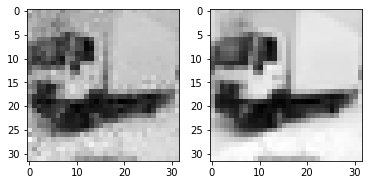

True label: 9
predicted label: 8
Time:  601.8581371307373  seconds
Initial fitness: 
 [-0.6024560083704801, -0.6003125112250225, -0.602902422765762, -0.6003334485959413, -0.6062091823893234, -0.5999625168542378, -0.6007783244099315, -0.6002385400262293, -0.6001572728192357, -0.6004829200316915, -0.6034984577178002, -0.6019109478653438, -0.599812440417802, -0.602905846066412, -0.6013753203091486, -0.5998556762242121, -0.6001871743987321, -0.5999337431419287, -0.6004181806681056, -0.6011028199302989, -0.6035215382631921, -0.5999687142567538, -0.6047098546829907, -0.6016547742692986, -0.6026511404620094, -0.6021224662181689, -0.6000329961459967, -0.6031906915058285, -0.6036291693033821, -0.6011940060942441, -0.6003526499867, -0.5993271978019274, -0.5997594048941454, -0.6004247831181884, -0.6000114119800125, -0.5997250905166677, -0.6004095109110326, -0.6000584336248515, -0.6071461891905732, -0.6011639674200921, -0.5999557607666447, -0.600359849688355, -0.6001590184637347, -0.60001212674774

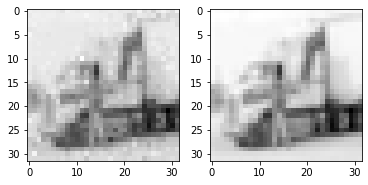

True label: 9
predicted label: 8
Time:  371.7305769920349  seconds
Initial fitness: 
 [-0.6001945028348815, -0.6001539322942964, -0.600127873011448, -0.6001877756549131, -0.600042619109083, -0.6001689827489419, -0.6001803742475215, -0.6000807969713, -0.6003161587808659, -0.6002877853529109, -0.6000616957465887, -0.6001431509168806, -0.6001913634800509, -0.6000608223781245, -0.6002297894151785, -0.6000310462613669, -0.6000761723112845, -0.6000631371125802, -0.6001167068559838, -0.6001675969257809, -0.6001029474945644, -0.6000901176464097, -0.6001448984650275, -0.6001314652074473, -0.6001388867508757, -0.6000399613564589, -0.6001838750017545, -0.6002128335028533, -0.6001725504294482, -0.6000561867746823, -0.6002428876642498, -0.6001552967208017, -0.6001027464885029, -0.600341581615962, -0.6000257799187707, -0.6000911754785316, -0.6001185372735034, -0.6001402445770635, -0.6000690035246928, -0.6000608080268865, -0.6000498042087896, -0.6003175188782056, -0.6001522058865298, -0.6001537384046

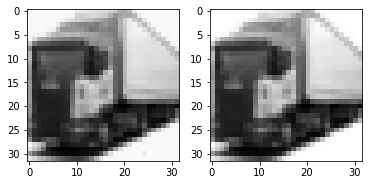

True label: 9
predicted label: 9
Time:  112.95255279541016  seconds
Initial fitness: 
 [-0.4906224150093981, -0.41761411407782467, -0.482199858994653, -0.49358351727864924, -0.5097961136028946, -0.47420474801829465, -0.48466515310524716, -0.5135161183955439, -0.49945418250927504, -0.48304811517007507, -0.510767650411644, -0.48199322876481643, -0.4351047018109365, -0.48528193447304313, -0.49931699741981533, -0.4496875755956834, -0.5044475117521439, -0.3895002210663982, -0.5070103858775238, -0.5070295111758374, -0.4947357829575995, -0.46028328659731943, -0.47501075171103113, -0.49975483648782343, -0.514848124772588, -0.529043031828319, -0.45287509376539825, -0.4898697395730732, -0.40183680727626875, -0.5348391588387339, -0.5220649934504733, -0.5043708628047138, -0.42801838581374785, -0.45339329947182627, -0.47035129783071083, -0.5043093708057311, -0.49168626256696635, -0.5135120189328386, -0.4880725001997092, -0.4788269925330023, -0.47457826042997625, -0.5321458326629239, -0.479737969028

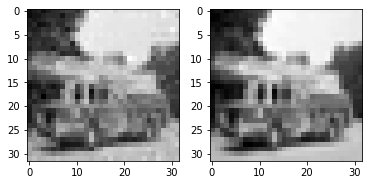

True label: 9
predicted label: 1
Time:  612.0022206306458  seconds
Initial fitness: 
 [-0.5999340374128288, -0.5999084426920884, -0.5997427652443412, -0.5998218892551762, -0.6000447844344782, -0.5999325320501493, -0.6000185049255228, -0.5999448989662546, -0.5998075803926673, -0.5997704531091762, -0.5998666458055883, -0.5996436021698899, -0.5998550537029586, -0.5998458731902171, -0.5998444621233142, -0.5997938777473087, -0.5998229893546666, -0.5999029622517795, -0.6000494943747792, -0.5998696518877973, -0.5998033222911602, -0.599934630097951, -0.6000172778838508, -0.5999226905584951, -0.599877693283586, -0.5998482841618971, -0.5997493830941125, -0.6000109860874536, -0.5998600145461653, -0.5998847343211723, -0.5997369504247009, -0.5998958520137734, -0.5999937822588527, -0.6001172112936296, -0.599805340770979, -0.599719562190234, -0.5998703107766923, -0.5997117248669186, -0.5999466375445772, -0.5998444463393121, -0.5996602103757976, -0.599832903852263, -0.6002182469818839, -0.599766989538

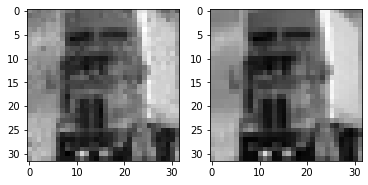

True label: 9
predicted label: 1
Time:  730.1486556529999  seconds
Initial fitness: 
 [-0.5470748985250997, -0.5092459687042593, -0.5415125742226696, -0.5094874314711034, -0.5202859566652174, -0.5355297434222483, -0.4962618509461413, -0.5319670453178824, -0.5196167444739572, -0.5260657543872728, -0.5391705350346048, -0.5264543633629001, -0.5236024073534339, -0.5046784803758655, -0.5156624612954084, -0.49658882961951667, -0.535514293841576, -0.5402702977455689, -0.5274691604491799, -0.5525443541482155, -0.505744308354085, -0.5173392437466431, -0.4944133964022852, -0.5146408225844121, -0.5182864942785954, -0.5336210910457724, -0.5495878119838824, -0.5482152826494695, -0.5261581062894599, -0.5134566370189679, -0.4936711755885892, -0.5205704482347518, -0.5228065041517229, -0.49794854893675977, -0.508198220262559, -0.5342887440280737, -0.5212971841433887, -0.5185095202677386, -0.5082554190261706, -0.522358116094571, -0.5460728417614157, -0.5375646631579339, -0.5238953251681355, -0.509422991

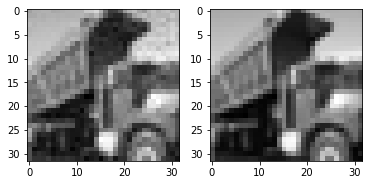

True label: 9
predicted label: 2
Time:  784.8296225070953  seconds
Initial fitness: 
 [-0.5959821356170181, -0.5969845504736924, -0.5962832537973652, -0.5962311988108575, -0.5987549991307903, -0.5975348915577134, -0.5976498204885475, -0.5988912936859904, -0.5939497662052738, -0.5981159426416427, -0.5978548365746046, -0.5968813125389476, -0.5977089184705557, -0.5976432898629378, -0.5978294921462873, -0.5982350012469759, -0.5997183994045142, -0.5983079187008757, -0.5972418542010928, -0.5988626095060449, -0.5983837821356354, -0.59837446658614, -0.5979246972695436, -0.5957889116432126, -0.5989518663847315, -0.5982590675772568, -0.5976908624755538, -0.5983058525503886, -0.5986092673283089, -0.5981039665767679, -0.5965038719284, -0.5973087524396388, -0.5983536403410255, -0.5983364312970775, -0.5979079987576734, -0.5978728782432399, -0.5980353091552908, -0.5988026453021292, -0.5987233824068309, -0.5999429127289392, -0.598096134019054, -0.5973314587663, -0.5983442705749334, -0.5972170404323364

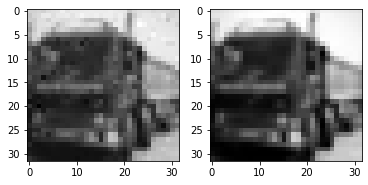

True label: 9
predicted label: 1
Time:  277.9021828174591  seconds
Initial fitness: 
 [0.27628652759379035, 0.45096786232723174, 0.115545469988417, 0.00665834764687942, 0.11013730218169171, -0.07606259834546653, 0.04665197950358252, 0.05636154533700069, 0.22324500788102689, 0.06721245774192727, 0.13204310731437247, 0.06312315562909152, 0.3830113148182966, 0.2734216430235246, 0.037295926685992825, 0.16924627038343237, 0.04401133886604125, 0.058011850072307164, 0.15639414766916004, 0.047959595387500886, -0.023674220858308004, 0.34444075923189593, 0.2529095008094139, 0.07831800907754131, 0.15756882246525913, 0.0062416747944579465, -0.1315597530298971, 0.14703776125358436, 0.47867742626759596, 0.10918408317735998, 0.23820807246961462, 0.3510835852627076, -0.012163911005670935, 0.1252002514170461, 0.1366652712271758, -0.006498589826712253, 0.09273253751597135, 0.3175872321469184, 0.32437890679709047, 0.2764696444616854, 0.019399642030397374, -0.00333505350198654, 0.012037854940656595, 0.095

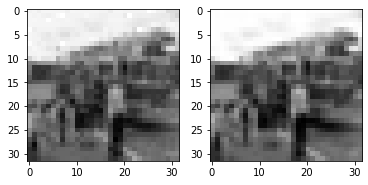

True label: 9
predicted label: 7
Time:  243.85134315490723  seconds
Initial fitness: 
 [-0.6004272629575074, -0.6005056603653453, -0.6030751122830404, -0.6000360638292979, -0.6004648463866403, -0.6008145371187389, -0.600378737773017, -0.6004034717460157, -0.5999872491989698, -0.599922845676516, -0.6001152079065326, -0.600173121722673, -0.6003372602413939, -0.6000601354167171, -0.6004404478168751, -0.6000927859348506, -0.6003975430888782, -0.6004089427940406, -0.6003722254694883, -0.6006020894396328, -0.5999332418403656, -0.6001540667051679, -0.6012929061566228, -0.6007332388919151, -0.6002980222895985, -0.6009135364852553, -0.6006186116404414, -0.6002332270435149, -0.6002054286248226, -0.6000881372626803, -0.6000474790141903, -0.6001555704869526, -0.6009757193112752, -0.6004576943665497, -0.6004236705321031, -0.5999938137123615, -0.5999471408344046, -0.6002071105680379, -0.6000481185940193, -0.6000878379268445, -0.600612689345859, -0.6000245536346616, -0.6003268276179012, -0.6000612135

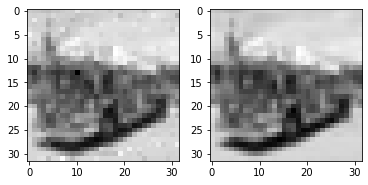

True label: 9
predicted label: 6
Time:  237.62634778022766  seconds
Initial fitness: 
 [-0.6001350460562821, -0.6001397787571678, -0.6001444183673021, -0.6000767077319291, -0.6008122398736518, -0.6001162042659862, -0.600040230788542, -0.6000580842081045, -0.599995673283126, -0.6004549054502727, -0.6001061853170867, -0.6003205921642742, -0.6001531971180892, -0.6000783059172171, -0.6000861484866884, -0.6001543808580833, -0.6000485374806311, -0.6000650398880724, -0.601054541872621, -0.6000197833965407, -0.6001551698246803, -0.6002145081335617, -0.6001484812858804, -0.600023781327055, -0.6008037152623361, -0.6004719056861332, -0.6001553744444387, -0.6002580480133046, -0.6000447019935607, -0.6000999638472675, -0.6006528758448976, -0.6003587751178956, -0.6000782093487179, -0.6001317932922241, -0.6001740592908075, -0.6004389047819269, -0.6000049680194215, -0.6000781753191226, -0.6000908042269608, -0.6001436622305549, -0.6002706900211586, -0.6000646515436019, -0.6002828931501238, -0.6001928894

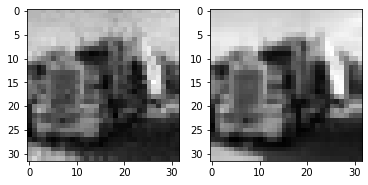

True label: 9
predicted label: 8
Time:  932.8734767436981  seconds
Initial fitness: 
 [0.3048185635486593, 0.2895441997441271, 0.07327648057182967, -0.20243525384960967, 0.29533999361265195, 0.3748795309923015, -0.14515399779571722, 0.32922672224644717, 0.22620737162731863, 0.3853912539448017, 0.29124015758143323, 0.3893492164044928, 0.4826461451080639, 0.35297543914464136, 0.5033692276890437, 0.30715715735644117, -0.08247962932997774, 0.12419956551251111, 0.39714785398867103, 0.13922619888645654, 0.20239456448791845, 0.3989046867570506, -0.1967806510335912, 0.3008383476725983, 0.2501252065202319, 0.47486793535895294, 0.3728508122386994, 0.49525217811564914, 0.4435624058615136, 0.37088390025129164, 0.2987280590971969, 0.3525442353661702, 0.24989536321452027, 0.4568927464183213, 0.43271000973563767, 0.3294774614569773, 0.5483356012877384, 0.02496289459417339, 0.28450940596346597, 0.3249333109152751, 0.33962808230548813, 0.3504859611415674, 0.35172219347261247, 0.3598687745929504, 0.2398

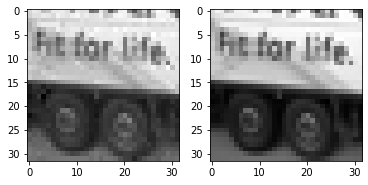

True label: 9
predicted label: 1
Time:  378.0172698497772  seconds


In [14]:
# for each image and label in adversarial
n=50
import time
# these are the examples that are found as adversarialwe will save these at the end in a file
evolved_examples= []
# fitness of the adversarials
fitness_of_evolved=[]
# time necessary to evolve the adversarial
times=[]
# the distance between the original image and the adversarial
ssim_values=[]
# number of round necessary to produce adversarial 
number_of_rounds=[]
# this will serve to see if the fitness changes or not 
best_fitness = 0


numb_of_found_after30=0
numb_of_adv_found=0

#dictionary to keep the best individual to check if the fitness is improving or not 


predicted_class= []
for img,label in zip(adversarial,adversarial_y):
  winner_of_gen = {"image":[],"label": None, "fitness": None}
  #temporary variable to check generations:
  fitness_no_change = 0
  start = time.time()
  label=label[0]
  #intialize population from the image and with the given label
  population = init_pop_from_sample(n,img,label)
  # calculate fitness of these individuals
  fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label)
  print(f"Initial fitness: \n {fitness}")
  #retun the best one from the population
  best,fit_max = return_best_individual(population,fitness)
  #check if adversarial
  check_adv = check_adv_termination(best,label,img, model)
  #define max generation
  max_gen=0
  winner_of_gen.update(image= best)
  winner_of_gen.update(label= label)
  winner_of_gen.update(fitness= fit_max)

  while (len(check_adv)==0 or max_gen<10000):
      new_pop=[]
      for i in range(50):
        parent1= tournament(population, model, img, label) 
        parent2 = tournament(population, model, img, label)
        if 0.8 > np.random.uniform(0.0, 1.0):
          child1, child2 = k_crossover(parent1, parent2) # crossover
          new_pop.append(add_noise(choose_better_child(child1, child2,img,label,model)))
        else:
          new_pop.append(add_noise(choose_better_child(parent1, parent2,img,label,model)))

      # to reshape into an array 
      population= np.array(new_pop)
      #check fitness of the generation
      fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
      #find the highest fitness
      best,fit_max1 = return_best_individual(population,fitness)
      # check adversarial - check if pred != target, distance < 0.001 or fitness didn't improve 0.001 after 30 generations(this is in else condition)
      check_adv = check_adv_termination(best,label,img,model)

      #check if the first termination true 
      if(len(check_adv) != 0):
        print("Adversarial example image: \n")
        evolved_examples.append(check_adv) #add evolved example
        ssim_values.append(1-compare_ssim(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG))) #add the distance
        end=time.time()
        times.append(end-start) #add the time 
        fitness_of_evolved.append(calculate_fitness(model,check_adv,img,label)) #add the fitness value of adversarial
        number_of_rounds.append(max_gen)
        pred_l=np.argmax(model.predict(check_adv.reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(check_adv.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}") 
        print("Time: ",end-start ," seconds")
        numb_of_adv_found+=1
        break
      #check the second termination 
      else:
          #check if fitness increases, if not , add +1 to temporary var
        if fit_max1>fit_max:
          fit_max=fit_max1
          winner_of_gen.update(image= best)
          winner_of_gen.update(label= label)
          winner_of_gen.update(fitness= fit_max1)
          fitness_no_change=0
        else:
          fitness_no_change+=1
      
      #print after every 10 generations to see the progress
      if (max_gen % 10 == 0):
        print(f"Generation {max_gen}")
        print(f"Max fitness value {fit_max}")
      max_gen+=1

      # if fitness did not improve for 30 generations, save the image that was best , saved it in a dicitonary
      if fitness_no_change==30:
        print("FITNESS DID NOT IMPROVE FOR 30 GENERATIONS")
        print("Best adversarial image we could find: \n")
        evolved_examples.append(winner_of_gen["image"])
        ssim_values.append(1-compare_ssim(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),img.reshape(CIFAR_IMG,CIFAR_IMG)))
        number_of_rounds.append(max_gen)
        end=time.time()
        times.append(end-start)
        fitness_of_evolved.append(winner_of_gen["fitness"])
        pred_l=np.argmax(model.predict(np.array(winner_of_gen["image"]).reshape(1,CIFAR_IMG,CIFAR_IMG,1)/255.0))
        predicted_class.append(pred_l)
        print("Left: adversarial \t Right: ground truth")
        fd, idx = plt.subplots(1,2)
        idx[0].imshow(np.array(winner_of_gen["image"]).reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        idx[1].imshow(img.reshape(CIFAR_IMG,CIFAR_IMG),cmap='gray')
        plt.show()
        print(f"True label: {label}")
        print(f"predicted label: {pred_l}")
        print("Time: ",end-start ," seconds")
        numb_of_found_after30 +=1
        break




# Save files


In [15]:
import pickle
file_ = open('GA_adv_cifar_ssim_uniform_seed1', 'wb')
pickle.dump(evolved_examples, file_)
pickle.dump(times, file_)
pickle.dump(ssim_values, file_)
pickle.dump(fitness_of_evolved , file_)
pickle.dump(predicted_class, file_)
pickle.dump(number_of_rounds, file_)
file_.close()

print(f"Max time: {np.max(times)}")
print(f"Min time: {np.min(times)}")
print(f"Mean time: {np.mean(times)}")
print(f"Std time: {np.std(times)}\n")

print(f"Max fitness evolved: {np.max(fitness_of_evolved)}")
print(f"Min fitness evolved:: {np.min(fitness_of_evolved)}")
print(f"Mean fitness evolved: {np.mean(fitness_of_evolved)}")
print(f"Std fitness evolved:: {np.std(fitness_of_evolved)}\n")

print(f"Max ssim: {np.max(ssim_values)}")
print(f"Min ssim: {np.min(ssim_values)}")
print(f"Mean ssim: {np.mean(ssim_values)}")
print(f"Std ssim: {np.std(ssim_values)}\n")

print(f"Max round: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")




print(f"Percentage of adversarial founds sucessfully : {numb_of_adv_found/len(adversarial_y)} %")
print(f"Percentage of adversarial founds after fitness not improving for 30 generations: {numb_of_found_after30/len(adversarial_y)} %")


Max time: 1667.6558184623718
Min time: 112.95255279541016
Mean time: 392.55138804321
Std time: 253.6264000648243

Max fitness evolved: 0.9989590402996747
Min fitness evolved:: -0.6009163402832747
Mean fitness evolved: 0.8704847908127794
Std fitness evolved:: 0.4194229320659775

Max ssim: 0.3615408098634225
Min ssim: 2.4894489478399784e-05
Mean ssim: 0.04416522293151677
Std ssim: 0.04848948770264252

Max round: 312
Min rounds: 30
Mean rounds: 94.62406015037594
Std rounds: 57.384811265406334

Percentage of adversarial founds sucessfully : 0.0 %
Percentage of adversarial founds after fitness not improving for 30 generations: 1.0 %


Open adversarial

In [16]:
with open('GA_adv_cifar_ssim_uniform_seed1', 'rb') as f:
    evolved_examples = pickle.load(f)
    times= pickle.load(f)
    ssim_values = pickle.load(f)
    fitness_of_evolved = pickle.load(f)
    predicted_class = pickle.load(f)
    number_of_rounds = pickle.load(f)

In [17]:
#Correction of ssim values
new_ssim=[]
for s in ssim_values:
    new_ssim.append(1-s)
    
print(f"Max ssim: {np.max(new_ssim)}")
print(f"Min ssim: {np.min(new_ssim)}")
print(f"Mean ssim: {np.mean(new_ssim)}")
print(f"Std ssim: {np.std(new_ssim)}\n")

Max ssim: 0.9999751055105216
Min ssim: 0.6384591901365775
Mean ssim: 0.9558347770684832
Std ssim: 0.04848948770264251



In [18]:
#Correctionf of rounds  (replacing 0 with 1)
number_of_rounds = np.where(np.array(number_of_rounds)==0, 1, number_of_rounds) 
number_of_rounds

array([124,  66,  43, 142,  57,  51, 159, 162,  75,  39,  90,  54,  78,
       200,  55,  30,  49,  48,  72,  30,  70,  30,  58,  30,  30, 221,
        47,  44,  77, 166,  49,  73,  68,  62, 160,  54,  30,  30, 163,
        41,  60, 126, 131,  50,  56, 123,  59, 103,  87, 163,  65,  51,
        30,  57,  62,  82,  43,  73,  54,  35, 143,  56,  47,  93,  53,
        48,  53,  87,  50, 258,  73,  44, 119,  88, 122, 202, 120, 312,
       105,  53, 215,  69,  54, 181,  74,  59, 152,  57, 122,  92, 103,
        82, 140, 150,  52, 236,  66,  83, 106,  55,  75,  50, 141,  89,
       164, 111, 199, 163,  50, 106, 109, 125,  68,  71,  62,  76,  30,
        97,  50, 245,  83, 105, 160,  99,  30, 163, 194, 209,  74,  65,
        63, 248, 100])

In [19]:
print(f"Max round: {np.max(number_of_rounds)}")
print(f"Min rounds: {np.min(number_of_rounds)}")
print(f"Mean rounds: {np.mean(number_of_rounds)}")
print(f"Std rounds: {np.std(number_of_rounds)}\n")



Max round: 312
Min rounds: 30
Mean rounds: 94.62406015037594
Std rounds: 57.384811265406334



# Examples of what functions do

In [20]:
population = init_pop_from_sample(50,adversarial[15],adversarial_y[15][0])
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),adversarial_y[15][0])
print(fitness)

[-0.7985465162923521, -0.7986143083750571, -0.7987471051598604, -0.7985707668610373, -0.7982924257403384, -0.7986327403276119, -0.7985371486357186, -0.7985994008038856, -0.7986489211692849, -0.7986328414261329, -0.7984458209104648, -0.7984243186786316, -0.7986808364148438, -0.7985361335297634, -0.7986223931863521, -0.7985934793588448, -0.7985824238975603, -0.7988441971646905, -0.7987014476161194, -0.7985461135578481, -0.7990548797213475, -0.7987683905017589, -0.7987217591636139, -0.7982758675457193, -0.7985617593840181, -0.7985848285873556, -0.7987301557841994, -0.7991410791966216, -0.7986603301300249, -0.7985413760052505, -0.7987699575381428, -0.7985720458357408, -0.798955996097742, -0.798579105842811, -0.7985950601799465, -0.7988551747635011, -0.7987739212531476, -0.7986167813577487, -0.7987854349489499, -0.7986451627215853, -0.7987192631907932, -0.7984980869985312, -0.7988911513972523, -0.7990398345027385, -0.7987669523115083, -0.7986125483502851, -0.7986265189097643, -0.79865529576

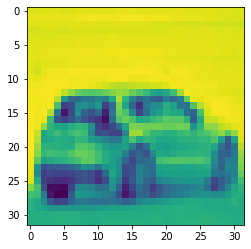

Class for this 1
[[2.6434999e-10 1.0000000e+00 7.0909743e-14 4.5650541e-12 4.3118281e-13
  1.4432735e-13 1.0789726e-12 1.0530981e-12 1.4951328e-13 4.9216830e-08]]


In [21]:
plt.imshow(population[0].reshape(CIFAR_IMG,CIFAR_IMG))
plt.show()
print(f"Class for this {adversarial_y[15][0]}")
print(model.predict(population[0].reshape(1,CIFAR_IMG,CIFAR_IMG,1) /255.0))

In [22]:
parent1 = tournament(population, model, adversarial[15], adversarial_y[15]) 
parent2 = tournament(population, model, adversarial[15], adversarial_y[15])

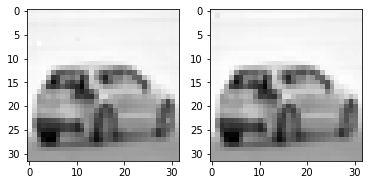

In [23]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(parent1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(parent2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")

In [24]:
child1, child2 = multi_crossover(parent1, parent2,adversarial[15]) # crossover 
#child1, child2 = add_noise(child1), add_noise(child2) # apply mutation to pixels 

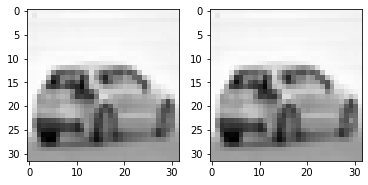

In [25]:
fd, idx =  plt.subplots(1,2)
idx[0].imshow(child1.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")
idx[1].imshow(child2.reshape(CIFAR_IMG,CIFAR_IMG),cmap="gray")


In [26]:
print(f"diff between children {np.unique(child1-child2)}")
print(f"diff between parents {np.unique(parent1-parent2)}")
print(f"diff between p1 and c1 {np.unique(parent1-child1)}")
print(f"diff between p1 and c2 {np.unique(parent1-child2)}")
print(f"diff between p2 and c1 {np.unique(parent2-child1)}")
print(f"diff between p2 and c2 {np.unique(parent2-child2)}")

diff between children [-26.474258  -11.0143585  -6.996811   -5.0584183  -4.2319946   0.
  16.191185   23.026329 ]
diff between parents [-23.026329  -16.191185   -7.238968    0.          0.9351196   3.4584656
   4.2319946   5.0584183   6.996811    8.899292   10.452713   11.0143585
  14.125168   16.190605   26.474258 ]
diff between p1 and c1 [-23.026329  -16.191185   -7.238968    0.          4.2319946   5.0584183
   6.996811   10.452713   11.0143585  14.125168   26.474258 ]
diff between p1 and c2 [-7.238968  0.       10.452713 14.125168]
diff between p2 and c1 [-16.190605   -8.899292   -3.4584656  -0.9351196   0.       ]
diff between p2 and c2 [-26.474258  -16.190605  -11.0143585  -8.899292   -6.996811   -5.0584183
  -4.2319946  -3.4584656  -0.9351196   0.         16.191185   23.026329 ]


In [27]:
bb = choose_better_child(child1, child2,adversarial[15],adversarial_y[15][0],model)

In [28]:
fitness = pop_fitness(model,np.expand_dims(population.reshape(population.shape[0],CIFAR_IMG,CIFAR_IMG),axis=3),img.reshape(CIFAR_IMG,CIFAR_IMG),label) 
print(fitness)

[0.8014533883402163, 0.8013855962575113, 0.801252799472708, 0.8014289470366678, 0.8017074788922299, 0.8013671643049565, 0.8014627559968498, 0.8014005038286828, 0.8013509834632835, 0.8013668724715722, 0.8015540837221036, 0.801575299851642, 0.8013190682177246, 0.801463771102805, 0.8013775114462163, 0.8014064252737235, 0.8014174807350081, 0.8011557074678779, 0.8012985523838807, 0.8014537910747203, 0.8009450249112209, 0.8012315141308095, 0.8012782408363862, 0.801724037086849, 0.8014381452485503, 0.8014150760452128, 0.8012695581135058, 0.8008578717616304, 0.8013393837676802, 0.8014585286273178, 0.8012297563595623, 0.8014278587968275, 0.8010439085348263, 0.8014207987897574, 0.8014048444526218, 0.8011444437667725, 0.8012257926445575, 0.8013829325399564, 0.8012141835813237, 0.8013547419109831, 0.8012804507069119, 0.8015015315317424, 0.8011083717655896, 0.8009598793949666, 0.8012327615861968, 0.8013871655474201, 0.801373385722804, 0.801344608872052, 0.8014492399679474, 0.8012973028671962]
